In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import colossus.cosmology.cosmology as cosmo
from colossus.halo import  mass_so
import seaborn as sns
from scipy.stats import kde
import matplotlib as mpl
from scipy.signal import savgol_filter as svg
from astropy.io import fits
from astropy.table import Table
#from bces import bces
from scipy.stats import linregress
from scipy.stats import norm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
cosmol=cosmo.setCosmology('planck15')    #cosmology for colossus. By default hmf uses planck15
cosmo.setCurrent(cosmol)



plt.rcParams['font.size']=45
plt.rcParams['figure.figsize']=(16,16)
#mpl.rcParams['xtick.minor.visible']=True
plt.rcParams['axes.linewidth']= 3.
plt.rcParams['axes.titlepad'] = 20
plt.rcParams['axes.linewidth']=5
plt.rcParams['xtick.major.size'] =15
plt.rcParams['ytick.major.size'] =15
plt.rcParams['xtick.minor.size'] =10
plt.rcParams['ytick.minor.size'] =10
plt.rcParams['xtick.major.width'] =5
plt.rcParams['ytick.major.width'] =5
plt.rcParams['xtick.minor.width'] =5
plt.rcParams['ytick.minor.width'] =5
plt.rcParams['axes.titlepad'] = 20 


In [2]:
def make_percentiles(rhalo,re, rhalobins):
    
    med = []
    up =[]
    low=[]
    
    for i in range(len(rhalobins)-1):
        
        try:
            mask = np.ma.masked_inside(rhalo, rhalobins[i], rhalobins[i+1]).mask
            re_ = re[mask]
                
            if len(re_)>10:
                res = np.percentile(re_,[1,16,50,84,99])   
                mask = np.ma.masked_inside(re_, res[0], res[-1]).mask
                res = np.percentile(re_[mask],[16,50,84])   
                low.append(res[0])
                med.append(res[1])
                up.append(res[2])
            else:
                low.append(np.nan)
                med.append(np.nan)
                up.append(np.nan)

        except:
            low.append(np.nan)
            med.append(np.nan)
            up.append(np.nan)
        
    return np.array(low),np.array(med),np.array(up)    

# Read catalogs

In [3]:
h = fits.open('TNG_cat_forLorenzo')  #Rodriguez-Gomez+19   - is it in hless units?
df_morpho = Table(h[1].data).to_pandas()
df= pd.read_csv('./IllSnaps/snap_95_unfiltered_bis.csv') #all galaxies
#df = pd.read_csv('./IllSnaps/snap_95.csv') #Identify Centrals #in h units with h from Planck
df = pd.merge(left=df_morpho, right=df, left_on='Illustris_ID_2_1', right_on='Unnamed: 0') 


In [4]:
jstar = pd.read_csv('./IllSnaps/TNG_jstar_s95_lzanisi.csv')


In [5]:
df = pd.merge(left=df, right=jstar, on='Illustris_ID_2_1')  #merge with info about angmom

In [6]:
df['R200Parent'] = mass_so.M_to_R(df['ParentDM'].apply(lambda x: 10**x), z=0.458,mdef='200c') # in h units
df.loc[:,'R200Parent'] = df['R200Parent'].apply(np.log10)-np.log10(cosmol.h) #de-h
df.loc[:,'LogMass30'] = df['LogMass30']-np.log10(cosmol.h) #de-h

df.loc[:,'ParentDM'] = df['ParentDM']-np.log10(cosmol.h) #de-h

In [7]:
df.loc[:,'sJ_star_2re'] = df['sJ_star_2re'].apply(np.log10)
df.loc[:,'sJ_star_all'] = df['sJ_star_all'].apply(np.log10)
df.loc[:,'sJ_star_1re'] = df['sJ_star_1re'].apply(np.log10)

df['sub'] = df['sJ_star_2re']-df['sJ_star_all']

In [8]:
def convert_radii(x):
    return np.log10(x*0.276/((1+0.0485)*cosmol.h))

In [9]:
df.loc[:,'rhalf_ellip'] = df['rhalf_ellip'].map(lambda x: convert_radii(x))
df.loc[:,'rhalf_circ'] = df['rhalf_circ'].map(lambda x: convert_radii(x))
df.loc[:,'r50'] = df['r50'].map(lambda x: convert_radii(x))
df.loc[:,'r80'] = df['r80'].map(lambda x: convert_radii(x))
df.loc[:,'sersic_rhalf'] = df['sersic_rhalf'].map(lambda x: convert_radii(x))

df.loc[:,'rmax_ellip'] = df['rmax_ellip'].map(lambda x: convert_radii(x))

In [10]:
df.loc[:,'Re'] = df['Re'].apply(np.log10) - np.log10(cosmol.h)

In [11]:
len(jstar)

7222

In [12]:
n = df['sersic_n']
df['R80_sersic'] = df['sersic_rhalf'] + np.log10(0.0012*n**3-0.0123*n**2+0.5092*n+1.2646)

# exploration of jstar

AttributeError: module 'matplotlib.pylab' has no attribute 'ylabe'

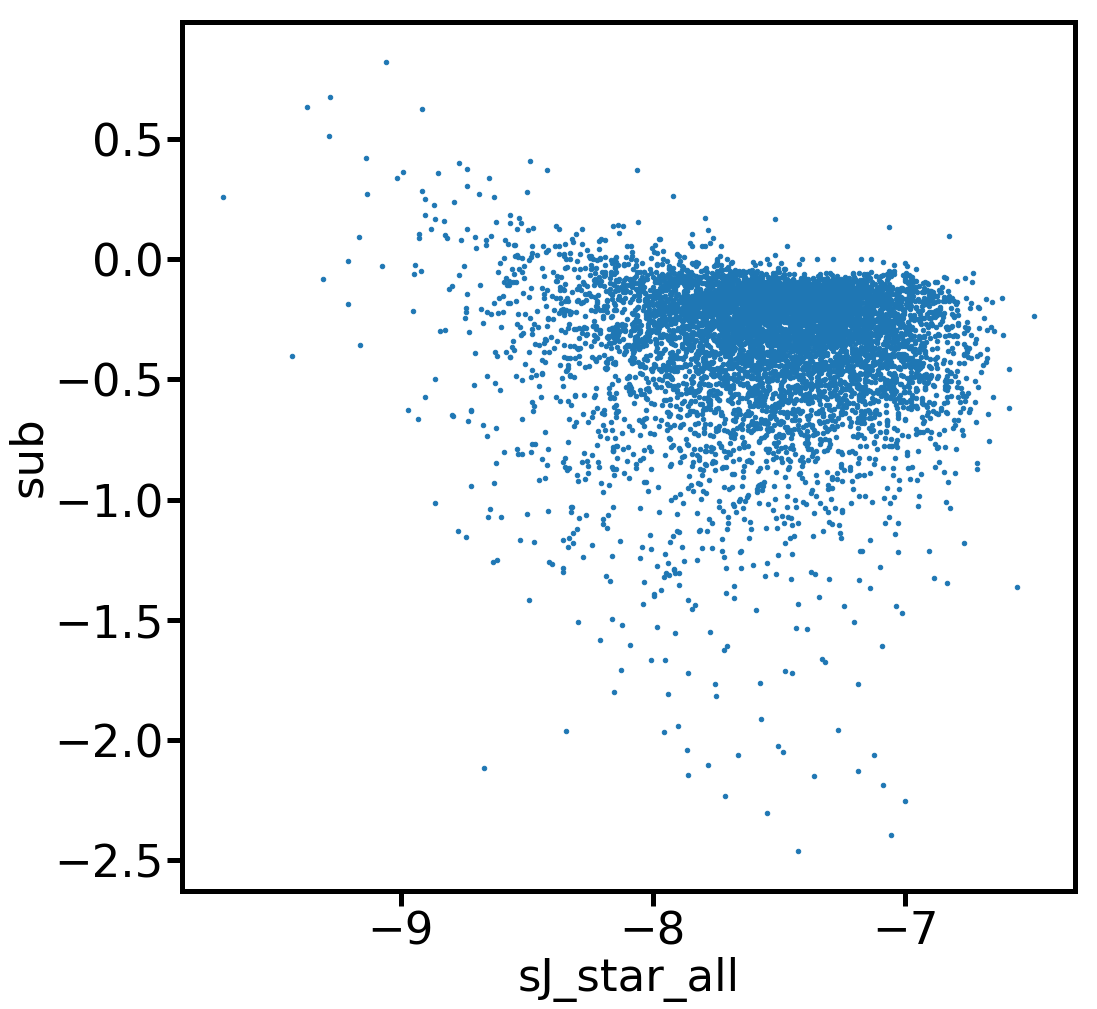

In [13]:

df.plot.scatter('sJ_star_all','sub')
#sns.kdeplot(data=jstar['sJ_star_2re'], data2=jstar['sJ_star_all'], shade=True)
plt.ylabel('sJ_star_2re-sJ_star_all')
#plt.xlim(-50,5000)
#plt.ylim(-50,5000)

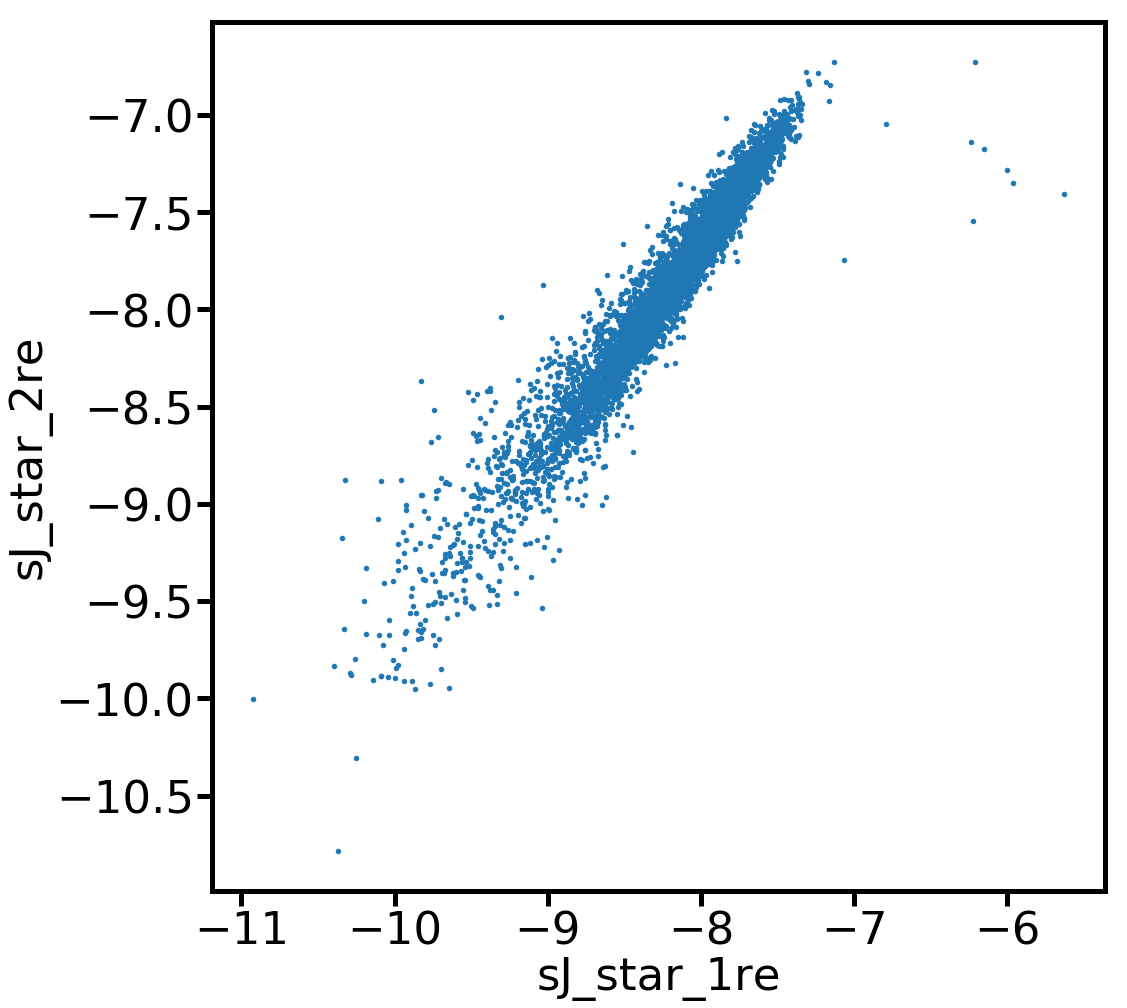

In [14]:
df.plot.scatter('sJ_star_1re','sJ_star_2re')

In [44]:
from scipy.stats import linregress

s,i,_,_,_ = linregress(jstar['sJ_star_2re'],jstar['sJ_star_all'])
coeffs= np.polyfit(jstar['sJ_star_2re'],jstar['sJ_star_all'], deg=3)

jstar.plot.scatter('sJ_star_2re','sJ_star_all')
x=np.arange(1,3.5,0.1)
y = s*x+i
plt.plot(x,y, color='red', lw=5)

y = np.polyval(coeffs, x)
plt.plot(x,y, color='magenta', lw=5)


In [83]:
jstarL = df.query('P_Late_comp>0.5')
jstarL = jstarL[['sJ_star_2re','sub','sJ_star_all']]

jstarE = df.query('P_Late_comp<0.5')
jstarE = jstarE[['sJ_star_2re','sub','sJ_star_all']]


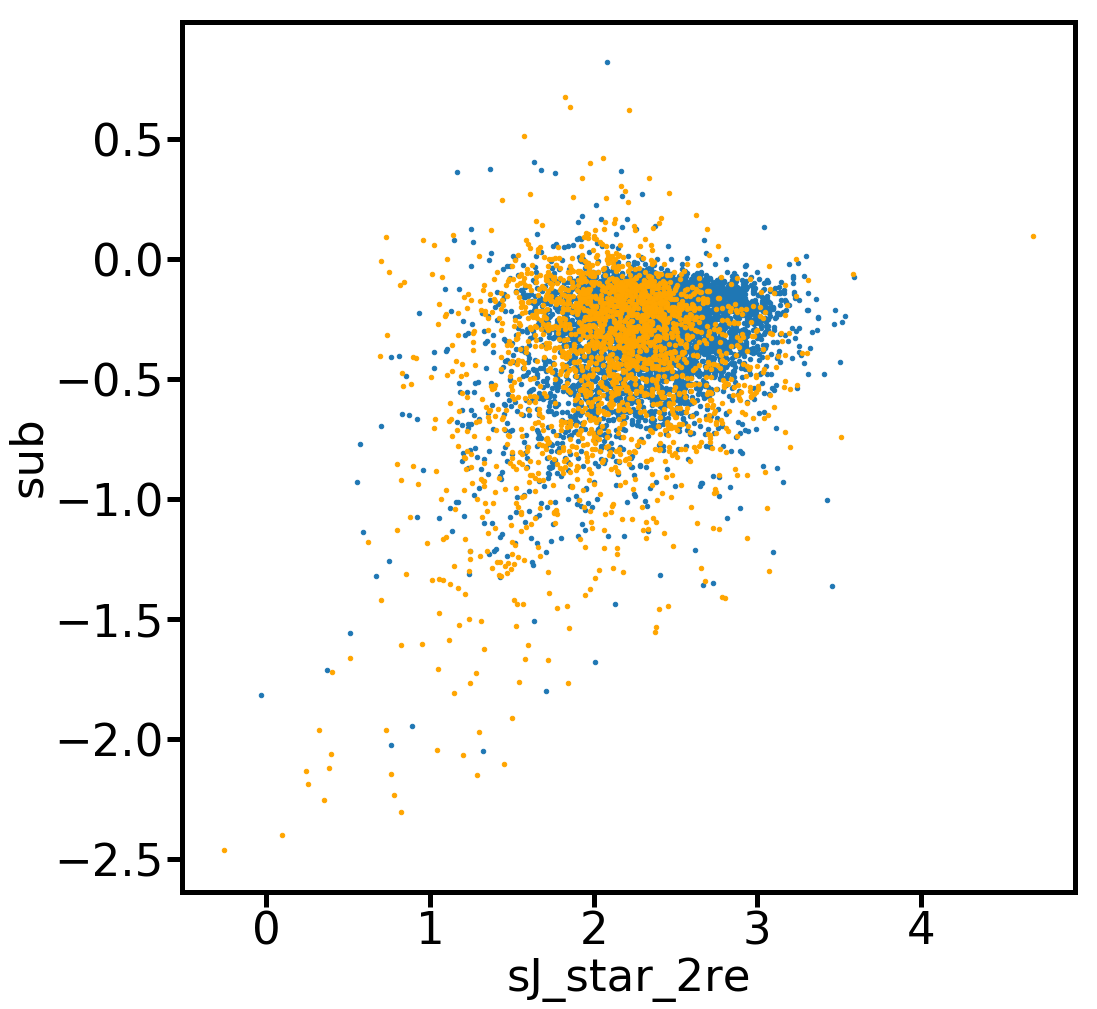

In [76]:
fig,ax =plt.subplots(1,1)
jstarL.plot.scatter('sJ_star_2re','sub',ax=ax)
jstarE.plot.scatter('sJ_star_2re','sub', color='orange', ax=ax)

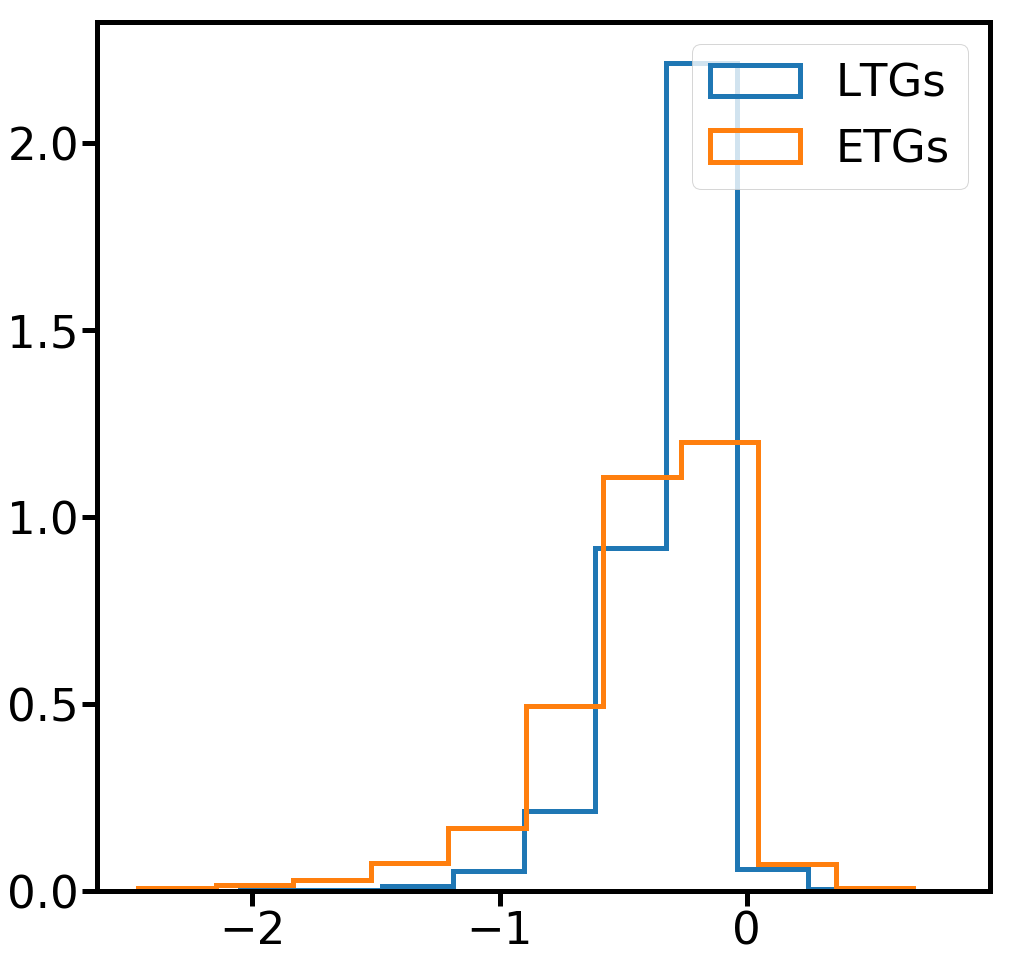

In [81]:
bins=np.arange(-2.5,0.5,0.1)
plt.hist(jstarL['sub'], label='LTGs', histtype='step',lw=5, normed=True)
plt.hist(jstarE['sub'], label='ETGs', histtype='step',lw=5, normed=True)
plt.legend()

In [84]:
jstarL.columns

Index(['sJ_star_2re', 'sub', 'sJ_star_all'], dtype='object')

In [86]:
low,med,up = np.percentile(jstarL['sJ_star_2re'], [16,50,84])
print(med-low,up-med)

0.35473828433094656 0.3397585124605418


5053

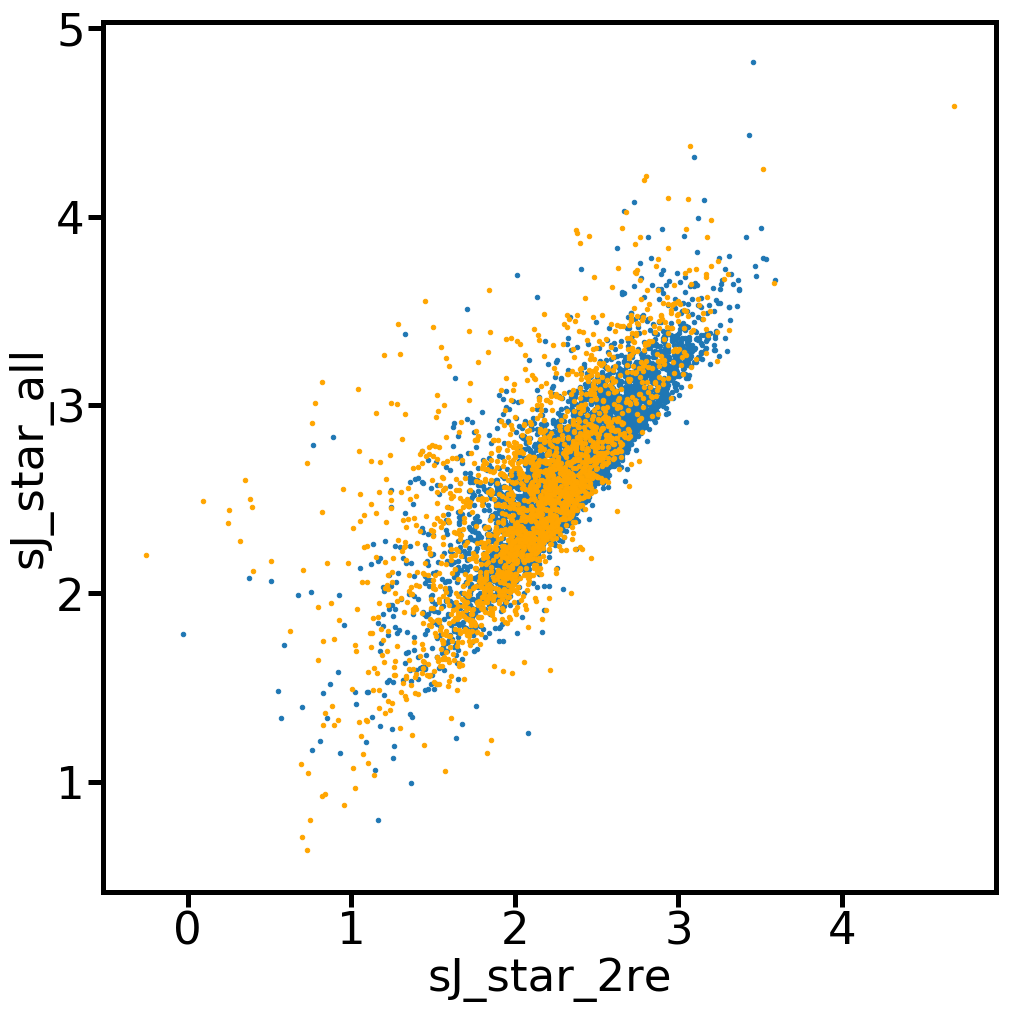

In [60]:
fig,ax =plt.subplots(1,1)
jstarL.plot.scatter('sJ_star_2re','sJ_star_all',ax=ax)
jstarE.plot.scatter('sJ_star_2re','sJ_star_all', color='orange', ax=ax)

len(jstarL)

# link between 3d and observed sizes

In [26]:
dfL.columns

Index(['Illustris_ID_2_1', 'asymmetry', 'concentration', 'deviation',
       'ellipticity_asymmetry', 'ellipticity_centroid', 'elongation_asymmetry',
       'elongation_centroid', 'flag', 'flag_sersic', 'flux_circ', 'flux_ellip',
       'gini', 'gini_m20_bulge', 'gini_m20_merger', 'intensity', 'm20',
       'multimode', 'num_badpixels', 'nx_stamp', 'ny_stamp',
       'orientation_asymmetry', 'orientation_centroid', 'outer_asymmetry',
       'r20', 'r50', 'r80', 'rhalf_circ', 'rhalf_ellip', 'rmax_circ',
       'rmax_ellip', 'rpetro_circ', 'rpetro_ellip', 'runtime',
       'sersic_amplitude', 'sersic_ellip', 'sersic_n', 'sersic_rhalf',
       'sersic_theta', 'sersic_xc', 'sersic_yc', 'shape_asymmetry', 'sky_mean',
       'sky_median', 'sky_sigma', 'smoothness', 'sn_per_pixel', 'subfind_id',
       'xc_asymmetry', 'xc_centroid', 'xmax_stamp', 'xmin_stamp',
       'yc_asymmetry', 'yc_centroid', 'ymax_stamp', 'ymin_stamp', 'LogMass30',
       'subhaloIDs', 'DR7ID', 'P_Late_comp', 'Sigma_ale

In [14]:
dfL = df.query('P_Late_comp>0.5 & flag_sersic==0')# & P_Sab_comp<0.5')
dfE = df.query('P_Late_comp<0.5 & flag_sersic==0')

-0.11395163081559773 0.0035043738115018153 0.10655964119623035
-0.0937051388674241 -0.006333905226745734 0.0975573055822887


/home/lz1f17/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:49: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
/home/lz1f17/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:50: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
/home/lz1f17/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:71: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


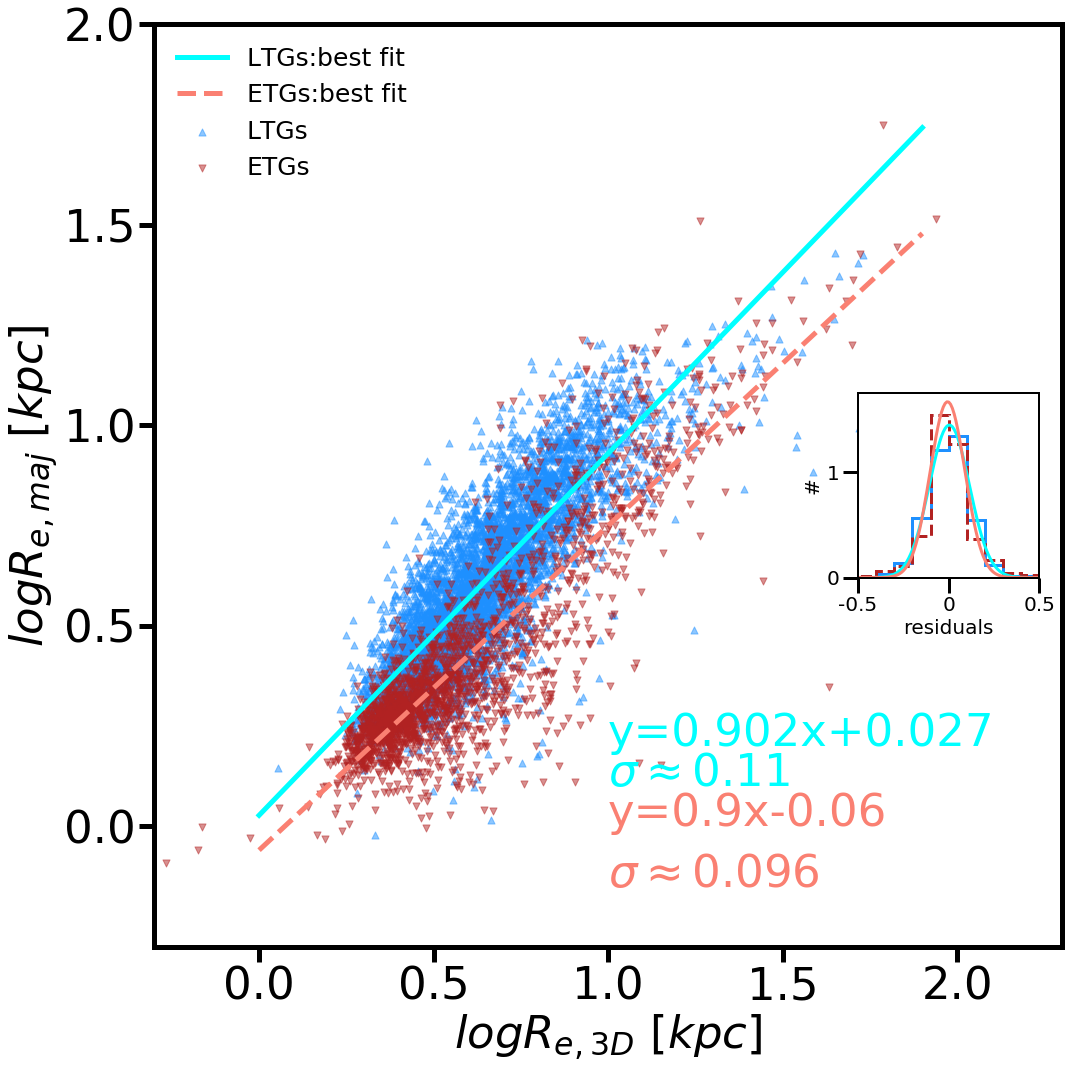

In [15]:
fig,ax = plt.subplots(1,1)
dfL.plot.scatter('Re','r50',ax=ax, marker='^', color='dodgerblue',alpha=0.5, label='LTGs', s=50)
dfE.plot.scatter('Re','r50',marker='v',ax=ax, color='firebrick',alpha=0.5, label='ETGs', s=50)

sL,iL,_,_,_ = linregress(dfL['Re'], dfL['r50'])
x=np.arange(0,2,0.1)
yL = lambda x,s,i: s*x+i
ax.plot(x,yL(x,sL,iL), color='cyan', lw=5, label='LTGs:best fit')
ax.text(x=1.,y=0.2, s='y={}x+{}'.format(np.round(sL,3),np.round(iL,3)), color='cyan')

yhat = dfL['r50']
x = dfL['Re']
resL = yL(x,sL,iL) - yhat
lowL,medL,upL = np.percentile(resL, [16,50,84])
print(lowL,medL,upL)
sigma=(abs(lowL)+upL)/2
ax.text(x=1,y=0.1, s=r'$\sigma\approx${}'.format(np.round(sigma,3)), color='cyan')

sE,iE,_,_,_ = linregress(dfE['Re'], dfE['r50'])
x=np.arange(0,2,0.1)
yE = lambda x,s,i: s*x+i
ax.plot(x,yE(x,sE,iE), color='salmon', lw=5, label='ETGs:best fit', ls='--')
ax.text(x=1.,y=0.,s='y={}x{}'.format(0.900,np.round(iE,3)), color='salmon')

yhat = dfE['r50']
x = dfE['Re']
resE = yE(x,sE,iE) - yhat

lowE,medE,upE = np.percentile(resE, [16,50,84])
print(lowE,medE,upE)
sigma=(abs(lowE)+upE)/2
ax.text(x=1,y=-0.15, s=r'$\sigma\approx${}'.format(np.round(sigma,3)), color='salmon')


yhat = dfL['r50']
x = dfL['Re']
resL = yL(x,sL,iL) - yhat
lowL,medL,upL = np.percentile(resL, [16,50,84])
sigma_resL = (abs(lowL)+upL)/2

yhat = dfE['r50']
x = dfE['Re']
resE = yE(x,sE,iE) - yhat
lowE,medE,upE = np.percentile(resE, [16,50,84])
sigma_resE = (abs(lowE)+upE)/2

axins = inset_axes(ax, width="20%", height="20%", loc=5, )
bins= np.arange(-1,1,0.1)
axins.hist(resL, bins=bins,normed=True, color='dodgerblue',histtype='step', lw=3)
axins.hist(resE, bins=bins,normed=True, color='firebrick' ,histtype='step', lw=3, ls='--')
bins= np.arange(-1,1,0.01)
axins.plot(bins, norm.pdf(bins,loc=medL, scale=sigma_resL), color='cyan',lw=3)
axins.plot(bins, norm.pdf(bins,loc=medE, scale=sigma_resE), color='salmon',lw=3)
axins.set_ylabel('#',fontdict={'fontsize': 20} )
axins.set_xlabel('residuals',fontdict={'fontsize': 20} )

for axis in ['top','bottom','left','right']:
    axins.spines[axis].set_linewidth(2)
axins.set_xlim(-0.5,0.5)
axins.set_xticklabels([-0.5,0,0.5],fontdict={'fontsize': 20}  )
axins.set_yticklabels([0,1,2,3,4],fontdict={'fontsize': 20}  )
axins.tick_params('both',width=3)
    
    
ax.set_xlabel('$logR_{e,3D} \ [kpc]$')
ax.set_ylabel('$logR_{e,maj} \ [kpc]$')
ax.set_xlim(-0.3,2.3)
ax.set_ylim(-0.3,2.)
ax.set_xticks(np.arange(0,2.5,0.5))
ax.set_yticks(np.arange(0,2.5,0.5))
plt.tight_layout()
ax.legend(fontsize=25, frameon=False, loc='upper left')
plt.savefig('/home/lz1f17/Pictures/Paper/simulations/Re_R3D_TNG.png')

In [52]:
yhat = dfL['rhalf_ellip']
x = dfL['Re']
resL = yL(x,sL,iL) - yhat

yhat = dfE['rhalf_ellip']
x = dfE['Re']
resE = yE(x,sE,iE) - yhat

lowL,medL,upL = np.percentile(resL, [16,50,84])
print(lowL,medL,upL)

-0.11422741775599987 0.0077714232617343 0.11004743416852475


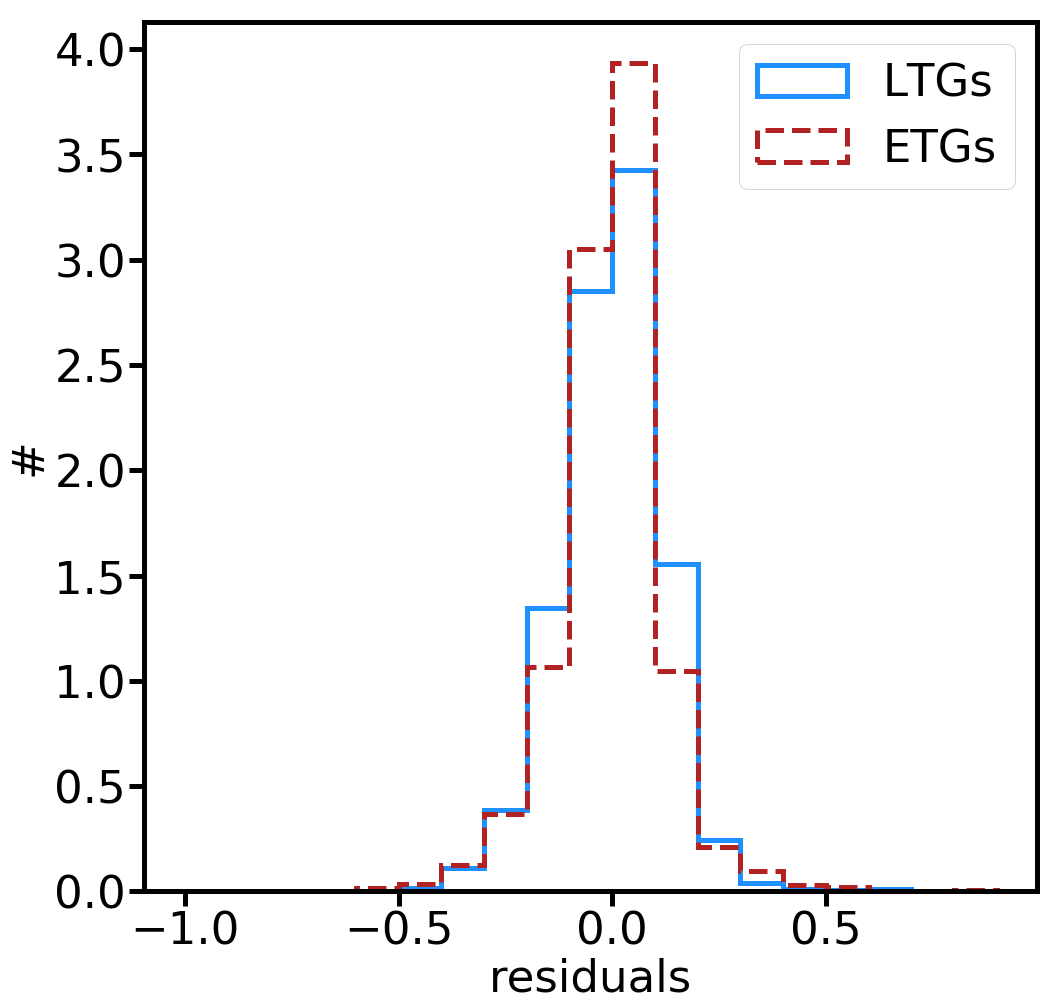

In [53]:
bins= np.arange(-1,1,0.1)
plt.hist(resL, bins=bins,normed=True, color='dodgerblue', label='LTGs',histtype='step', lw=5)
plt.hist(resE, bins=bins,normed=True, color='firebrick', label='ETGs',histtype='step', lw=5, ls='--')
plt.xlabel('residuals')
plt.ylabel('#')
plt.legend()

In [57]:
from scipy.stats import ks_2samp

In [59]:
ks_2samp(resL,resE)


Ks_2sampResult(statistic=0.058291925780365746, pvalue=1.0)

# rename for simplicity 

In [13]:
jstar['sub'] = jstar['sJ_star_2re']-jstar['sJ_star_all']
dfL = df.query('P_Late_comp>0.5')# & P_Sab_comp<0.5')
dfE = df.query('P_Late_comp<0.5')
dfL = dfL.rename(columns={'sJ_star_2re':'jstar_2re', 'sJ_star_all':'jstar_all','sJ_star_1re':'jstar_1re'})
dfE = dfE.rename(columns={'sJ_star_2re':'jstar_2re', 'sJ_star_all':'jstar_all','sJ_star_1re':'jstar_1re'})


In [36]:
dfL.columns

Index(['Illustris_ID_2_1', 'asymmetry', 'concentration', 'deviation',
       'ellipticity_asymmetry', 'ellipticity_centroid', 'elongation_asymmetry',
       'elongation_centroid', 'flag', 'flag_sersic', 'flux_circ', 'flux_ellip',
       'gini', 'gini_m20_bulge', 'gini_m20_merger', 'intensity', 'm20',
       'multimode', 'num_badpixels', 'nx_stamp', 'ny_stamp',
       'orientation_asymmetry', 'orientation_centroid', 'outer_asymmetry',
       'r20', 'r50', 'r80', 'rhalf_circ', 'rhalf_ellip', 'rmax_circ',
       'rmax_ellip', 'rpetro_circ', 'rpetro_ellip', 'runtime',
       'sersic_amplitude', 'sersic_ellip', 'sersic_n', 'sersic_rhalf',
       'sersic_theta', 'sersic_xc', 'sersic_yc', 'shape_asymmetry', 'sky_mean',
       'sky_median', 'sky_sigma', 'smoothness', 'sn_per_pixel', 'subfind_id',
       'xc_asymmetry', 'xc_centroid', 'xmax_stamp', 'xmin_stamp',
       'yc_asymmetry', 'yc_centroid', 'ymax_stamp', 'ymin_stamp', 'LogMass30',
       'subhaloIDs', 'DR7ID', 'P_Late_comp', 'Sigma_ale

# Compute R200 completeness 

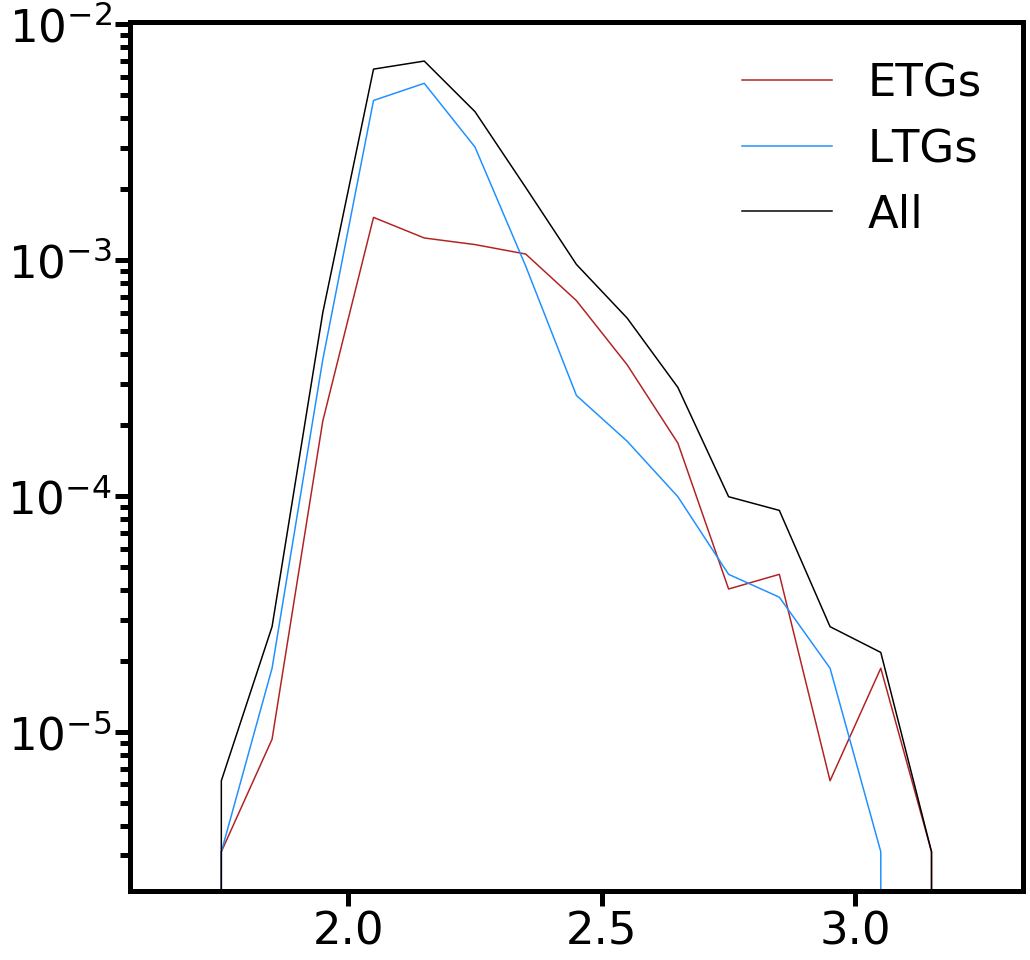

In [16]:
Vol = (100/cosmol.h)**3
width = 0.1
R200bins = np.arange(1.6,3.4,width)
R200 = R200bins[1:]-width/2.

hist = np.histogram(dfE.R200Parent,R200bins)[0]
plt.plot(R200, hist/width/Vol, label='ETGs', color='firebrick')

hist = np.histogram(dfL.R200Parent,R200bins)[0]
plt.plot(R200, hist/width/Vol, label='LTGs', color='dodgerblue')

hist = np.histogram(df.R200Parent,R200bins)[0]
plt.plot(R200, hist/width/Vol, label='All',color='black')

plt.legend(frameon=False)
plt.yscale('log')

In [14]:
len(dfL)+len(dfE)

7222

In [15]:
m = np.ma.masked_equal(hist,2250).mask
completeness = R200[m][0]

5685882927.646979

In [34]:
mass_so.R_to_M?

Signature: mass_so.R_to_M(R, z, mdef)
Docstring:
Spherical overdensity radius from mass.

This function returns a spherical overdensity halo mass for a halo radius R. Note that this 
function is independent of the form of the density profile.

Parameters
-----------------------------------------------------------------------------------------------
R: array_like
        Halo radius in physical kpc/h; can be a number or a numpy array.
z: float
        Redshift
mdef: str
        The mass definition
        
Returns
-----------------------------------------------------------------------------------------------
M: array_like
        Mass in :math:`M_{\odot}/h`; has the same dimensions as R.

See also
-----------------------------------------------------------------------------------------------
M_to_R: Spherical overdensity mass from radius.
File:      ~/anaconda3/lib/python3.6/site-packages/colossus/halo/mass_so.py
Type:      function


# Make Re-R200

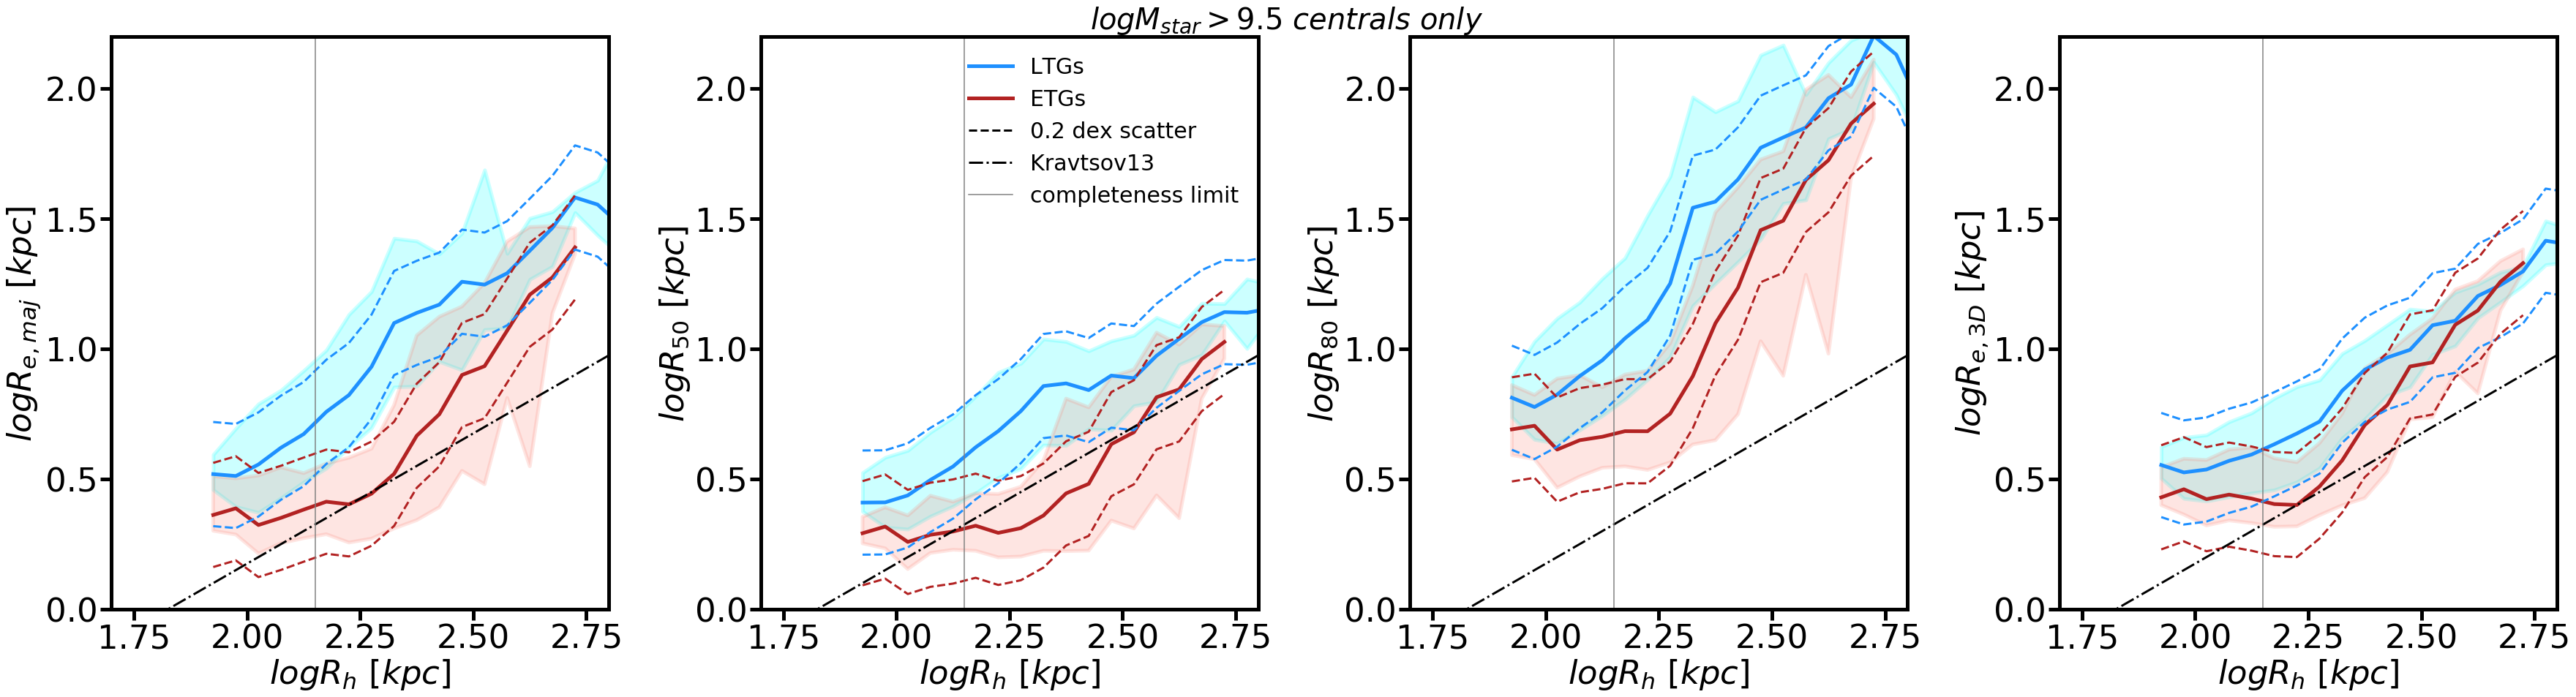

In [170]:
### for Reff
fig, (ax0,ax1,ax2,ax3) = plt.subplots(1,4, figsize=(50,14))
width = 0.05
rhalobins = np.arange(1.5,3,width)
weights = df['P_Late_comp'].values




#for Rsersic
dfL_ = dfL[dfL.flag_sersic==0]
dfE_ = dfE[dfE.flag_sersic==0]

low_LTGs,med_LTGs,up_LTGs = make_percentiles(dfL_['R200Parent'].values, dfL_['sersic_rhalf'], 
                               rhalobins)
weigths = 1-weights
low_ETGs,med_ETGs,up_ETGs = make_percentiles(dfE_['R200Parent'].values, dfE_['sersic_rhalf'], 
                               rhalobins)

rhb = rhalobins[1:] -width/2.
ax0.plot(rhb, med_LTGs, color='dodgerblue',lw=5, label='LTGs' )
ax0.fill_between(rhb,low_LTGs,up_LTGs, color='cyan', alpha=0.2,lw=5)
ax0.plot(rhb, med_ETGs, color='firebrick' ,lw=5,label='ETGs')
ax0.fill_between(rhb,low_ETGs,up_ETGs, color='salmon', alpha=0.2,lw=5)


ax0.plot(rhb, med_LTGs+0.2, color='dodgerblue', ls='--',lw=3)
ax0.plot(rhb, med_ETGs+0.2, color='firebrick', ls='--',lw=3)
ax0.plot(rhb, med_LTGs-0.2, color='dodgerblue', ls='--',lw=3)
ax0.plot(rhb, med_ETGs-0.2, color='firebrick', ls='--',lw=3)

ax0.plot(rhb, 2000*med_LTGs-0.2, color='black', ls='--',lw=3, label='0.2 dex scatter')
ax0.plot(rhb, rhb+np.log10(0.015),  ls='-.',lw=3, label='Kravtsov13', color='black')

ax0.axvline(completeness, color='gray', label='completeness limit')




#for R50
low_LTGs,med_LTGs,up_LTGs = make_percentiles(dfL['R200Parent'].values, dfL['r50'], 
                               rhalobins)
weigths = 1-weights
low_ETGs,med_ETGs,up_ETGs = make_percentiles(dfE['R200Parent'].values, dfE['r50'], 
                               rhalobins)

rhb = rhalobins[1:] -width/2.
ax1.plot(rhb, med_LTGs, color='dodgerblue',lw=5, label='LTGs' )
ax1.fill_between(rhb,low_LTGs,up_LTGs, color='cyan', alpha=0.2,lw=5)
ax1.plot(rhb, med_ETGs, color='firebrick' ,lw=5,label='ETGs')
ax1.fill_between(rhb,low_ETGs,up_ETGs, color='salmon', alpha=0.2,lw=5)


ax1.plot(rhb, med_LTGs+0.2, color='dodgerblue', ls='--',lw=3)
ax1.plot(rhb, med_ETGs+0.2, color='firebrick', ls='--',lw=3)
ax1.plot(rhb, med_LTGs-0.2, color='dodgerblue', ls='--',lw=3)
ax1.plot(rhb, med_ETGs-0.2, color='firebrick', ls='--',lw=3)

ax1.plot(rhb, 2000*med_LTGs-0.2, color='black', ls='--',lw=3, label='0.2 dex scatter')
ax1.plot(rhb, rhb+np.log10(0.015),  ls='-.',lw=3, label='Kravtsov13', color='black')

ax1.axvline(completeness, color='gray', label='completeness limit')


#for R80

low_LTGs,med_LTGs,up_LTGs = make_percentiles(dfL.query('sersic_n<10')['R200Parent'].values, dfL.query('sersic_n<10')['R80_sersic'], 
                               rhalobins)
weigths = 1-weights
low_ETGs,med_ETGs,up_ETGs = make_percentiles(dfE.query('sersic_n<10')['R200Parent'].values, dfE.query('sersic_n<10')['R80_sersic'], 
                               rhalobins)

rhb = rhalobins[1:] -width/2.
ax2.plot(rhb, med_LTGs, color='dodgerblue',lw=5, label='LTGs' )
ax2.fill_between(rhb,low_LTGs,up_LTGs, color='cyan', alpha=0.2,lw=5)
ax2.plot(rhb, med_ETGs, color='firebrick' ,lw=5,label='ETGs')
ax2.fill_between(rhb,low_ETGs,up_ETGs, color='salmon', alpha=0.2,lw=5)

ax2.plot(rhb, med_LTGs+0.2, color='dodgerblue', ls='--',lw=3)
ax2.plot(rhb, med_ETGs+0.2, color='firebrick', ls='--',lw=3)
ax2.plot(rhb, med_LTGs-0.2, color='dodgerblue', ls='--',lw=3)
ax2.plot(rhb, med_ETGs-0.2, color='firebrick', ls='--',lw=3)

ax2.plot(rhb, 2000*med_LTGs-0.2, color='black', ls='--',lw=3, label='0.2 dex scatter')
ax2.plot(rhb, rhb+np.log10(0.015),  ls='-.',lw=3, label='Kravtsov13', color='black')

ax2.axvline(completeness, color='gray', label='completeness limit')

#for R3D
low_LTGs,med_LTGs,up_LTGs = make_percentiles(dfL['R200Parent'].values, dfL['Re'], 
                               rhalobins)
weigths = 1-weights
low_ETGs,med_ETGs,up_ETGs = make_percentiles(dfE['R200Parent'].values, dfE['Re'], 
                               rhalobins)

rhb = rhalobins[1:] -width/2.
ax3.plot(rhb, med_LTGs, color='dodgerblue',lw=5, label='LTGs' )
ax3.fill_between(rhb,low_LTGs,up_LTGs, color='cyan', alpha=0.2,lw=5)
ax3.plot(rhb, med_ETGs, color='firebrick' ,lw=5,label='ETGs')
ax3.fill_between(rhb,low_ETGs,up_ETGs, color='salmon', alpha=0.2,lw=5)


ax3.plot(rhb, med_LTGs+0.2, color='dodgerblue', ls='--',lw=3)
ax3.plot(rhb, med_ETGs+0.2, color='firebrick', ls='--',lw=3)
ax3.plot(rhb, med_LTGs-0.2, color='dodgerblue', ls='--',lw=3)
ax3.plot(rhb, med_ETGs-0.2, color='firebrick', ls='--',lw=3)
ax3.plot(rhb, 2000*med_LTGs-0.2, color='black', ls='--',lw=3, label='0.2 dex scatter')

ax3.plot(rhb, rhb+np.log10(0.015),  ls='-.',lw=3, label='Kravtsov13', color='black')


ax3.axvline(completeness, color='gray', label='completeness limit')



ax0.set_ylim(0.,2.2)
ax0.set_xlim(1.7,2.8)
ax0.set_xlabel(r'$logR_{h} \  [kpc]$')
ax0.set_ylabel(r'$logR_{e,maj} \ [kpc]$')

ax1.set_ylim(0.,2.2)
ax1.set_xlim(1.7,2.8)
ax1.set_xlabel(r'$logR_{h} \  [kpc]$')
ax1.set_ylabel(r'$logR_{50} \ [kpc]$')

ax2.set_ylim(0.,2.2)
ax2.set_xlim(1.7,2.8)
ax2.set_xlabel(r'$logR_{h} \  [kpc]$')
ax2.set_ylabel(r'$logR_{80} \ [kpc]$')

ax3.set_ylim(0.,2.2)
ax3.set_xlim(1.7,2.8)
ax3.set_xlabel(r'$logR_{h} \  [kpc]$')
ax3.set_ylabel(r'$logR_{e,3D} \ [kpc]$')

fig.suptitle(r'$logM_{star}>9.5 \ centrals \ only$', fontsize=40)
ax1.legend(frameon=False, fontsize=30, loc='upper right')
plt.tight_layout()
#plt.savefig('/home/lz1f17/Pictures/Paper/simulations/ReR200_TNG.png')

(0, 20)

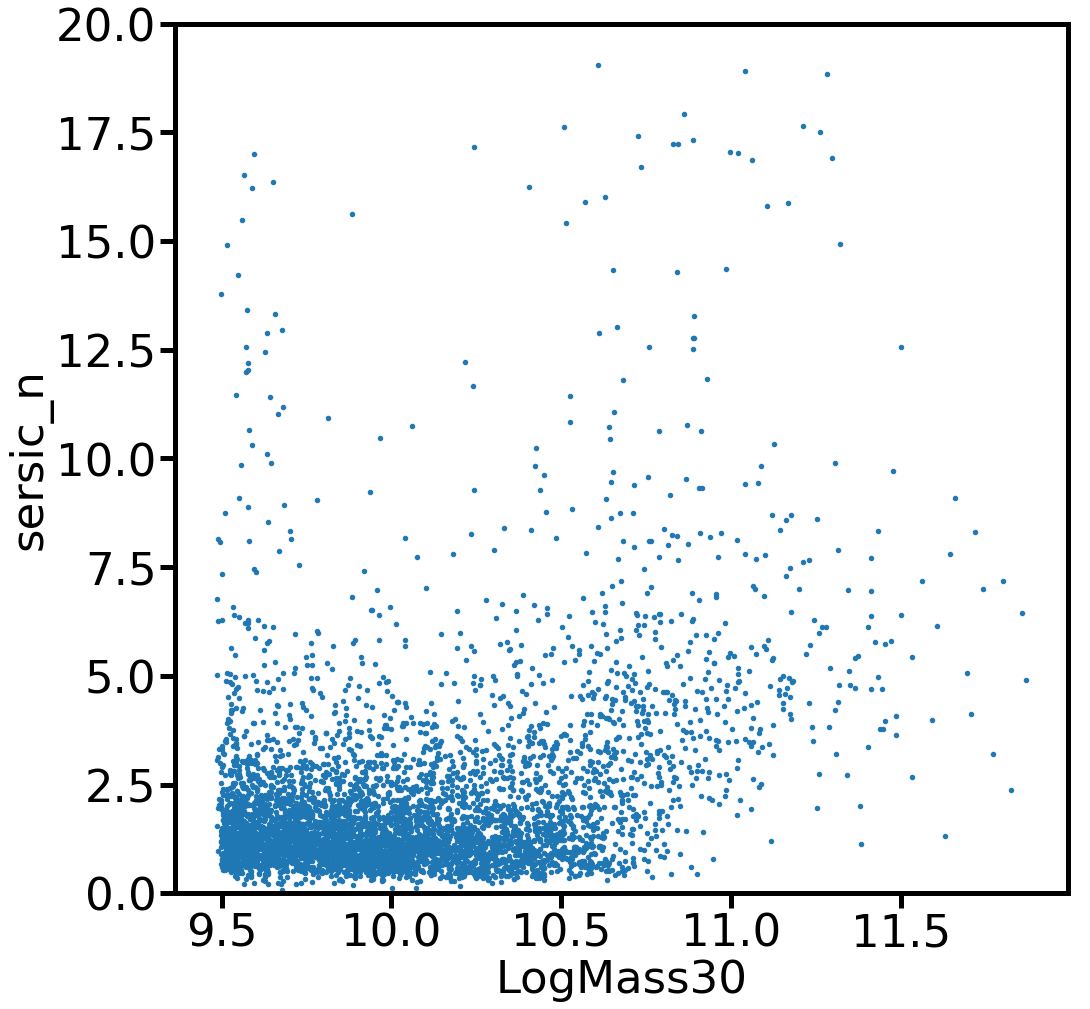

In [174]:
dfL.plot.scatter('LogMass30','sersic_n')
plt.ylim(0,20)

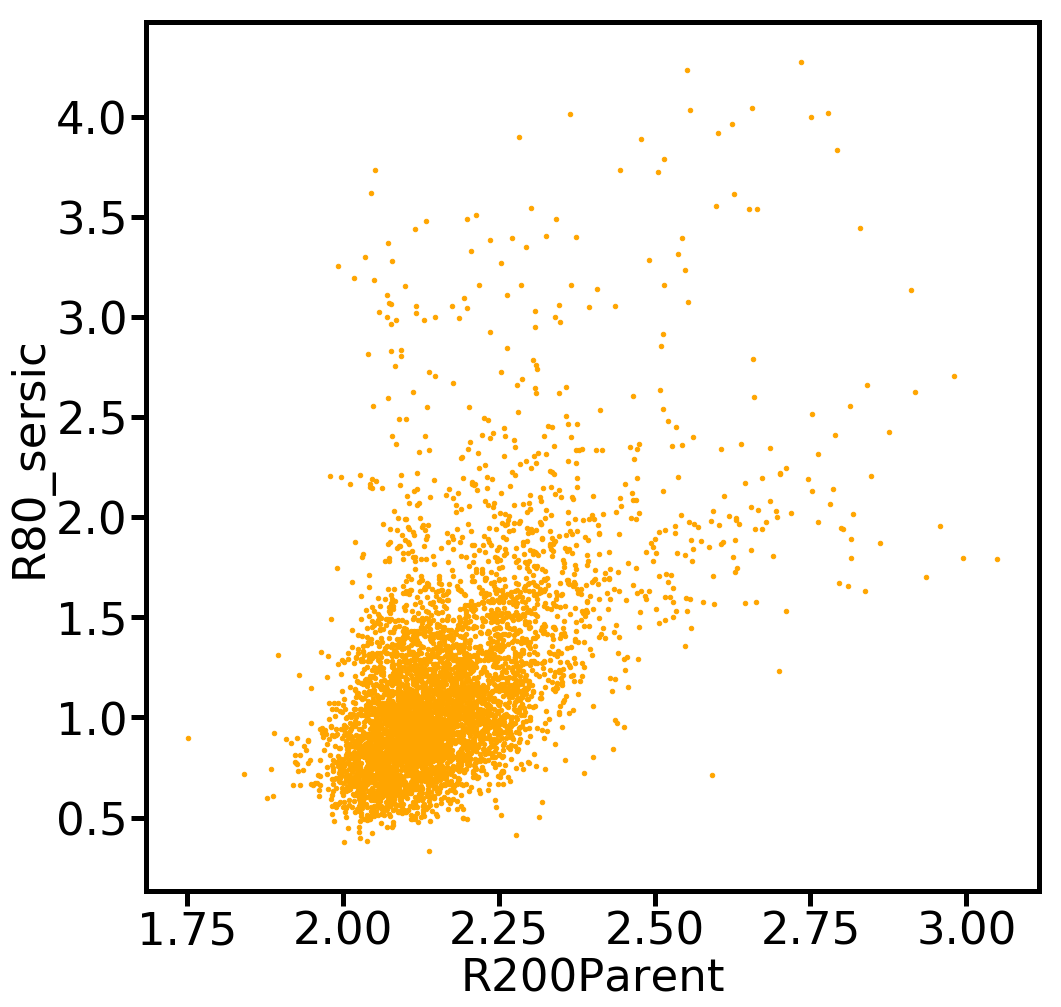

In [169]:
fig,ax =plt.subplots(1,1)
dfL.plot.scatter('R200Parent','R80_sersic', ax=ax, color='orange')
#dfL.query('flag_sersic==0').plot.scatter('R200Parent','sersic_rhalf', ax=ax, color='blue')


### for R50

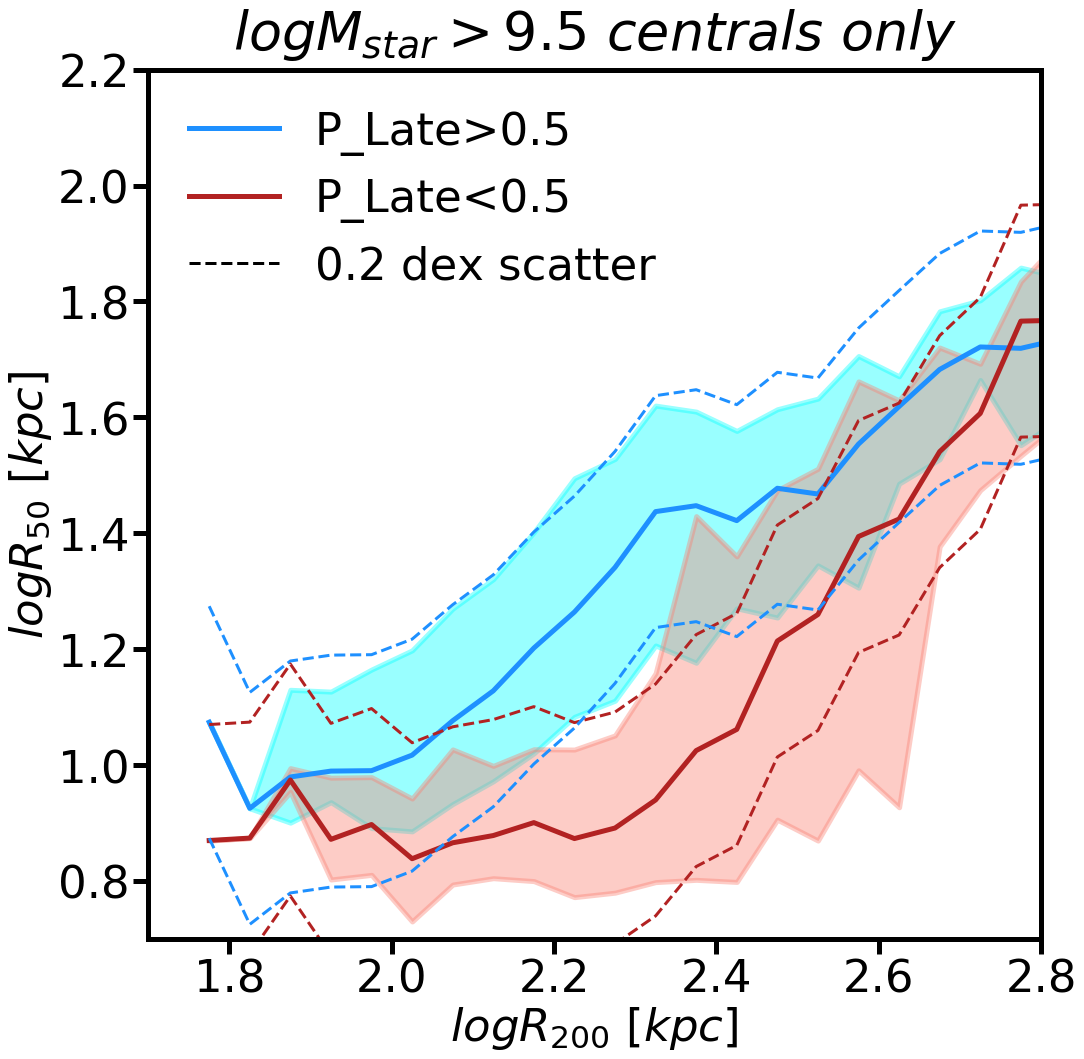

In [66]:
width = 0.05
rhalobins = np.arange(1.5,3,width)
weights = df['P_Late_comp'].values
low_LTGs,med_LTGs,up_LTGs = make_percentiles(dfL['R200Parent'].values, dfL['r50'].values, 
                               rhalobins)
weigths = 1-weights
low_ETGs,med_ETGs,up_ETGs = make_percentiles(dfE['R200Parent'].values, dfE['r50'].values, 
                               rhalobins)

rhb = rhalobins[1:] -width/2.
plt.plot(rhb, med_LTGs, color='dodgerblue',lw=5, label='P_Late>0.5' )
plt.fill_between(rhb,low_LTGs,up_LTGs, color='cyan', alpha=0.4,lw=5)
plt.plot(rhb, med_ETGs, color='firebrick' ,lw=5,label='P_Late<0.5')
plt.fill_between(rhb,low_ETGs,up_ETGs, color='salmon', alpha=0.4,lw=5)


plt.plot(rhb, med_LTGs+0.2, color='dodgerblue', ls='--',lw=3)
plt.plot(rhb, med_ETGs+0.2, color='firebrick', ls='--',lw=3)
plt.plot(rhb, med_LTGs-0.2, color='dodgerblue', ls='--',lw=3)
plt.plot(rhb, med_ETGs-0.2, color='firebrick', ls='--',lw=3)

plt.plot(rhb, 2000*med_LTGs-0.2, color='black', ls='--',lw=3, label='0.2 dex scatter')

plt.ylim(0.7,2.2)
plt.xlim(1.7,2.8)
plt.xlabel(r'$logR_{200} \  [kpc]$')
plt.ylabel(r'$logR_{50} \ [kpc]$')
plt.title(r'$logM_{star}>9.5 \ centrals \ only$')
plt.legend(frameon=False)
plt.savefig('R50R200_TNG_0.2scatt.png')

In [122]:
dfL.columns

Index(['Illustris_ID_2_1', 'asymmetry', 'concentration', 'deviation',
       'ellipticity_asymmetry', 'ellipticity_centroid', 'elongation_asymmetry',
       'elongation_centroid', 'flag', 'flag_sersic', 'flux_circ', 'flux_ellip',
       'gini', 'gini_m20_bulge', 'gini_m20_merger', 'intensity', 'm20',
       'multimode', 'num_badpixels', 'nx_stamp', 'ny_stamp',
       'orientation_asymmetry', 'orientation_centroid', 'outer_asymmetry',
       'r20', 'r50', 'r80', 'rhalf_circ', 'rhalf_ellip', 'rmax_circ',
       'rmax_ellip', 'rpetro_circ', 'rpetro_ellip', 'runtime',
       'sersic_amplitude', 'sersic_ellip', 'sersic_n', 'sersic_rhalf',
       'sersic_theta', 'sersic_xc', 'sersic_yc', 'shape_asymmetry', 'sky_mean',
       'sky_median', 'sky_sigma', 'smoothness', 'sn_per_pixel', 'subfind_id',
       'xc_asymmetry', 'xc_centroid', 'xmax_stamp', 'xmin_stamp',
       'yc_asymmetry', 'yc_centroid', 'ymax_stamp', 'ymin_stamp', 'LogMass30',
       'subhaloIDs', 'DR7ID', 'P_Late_comp', 'Sigma_ale

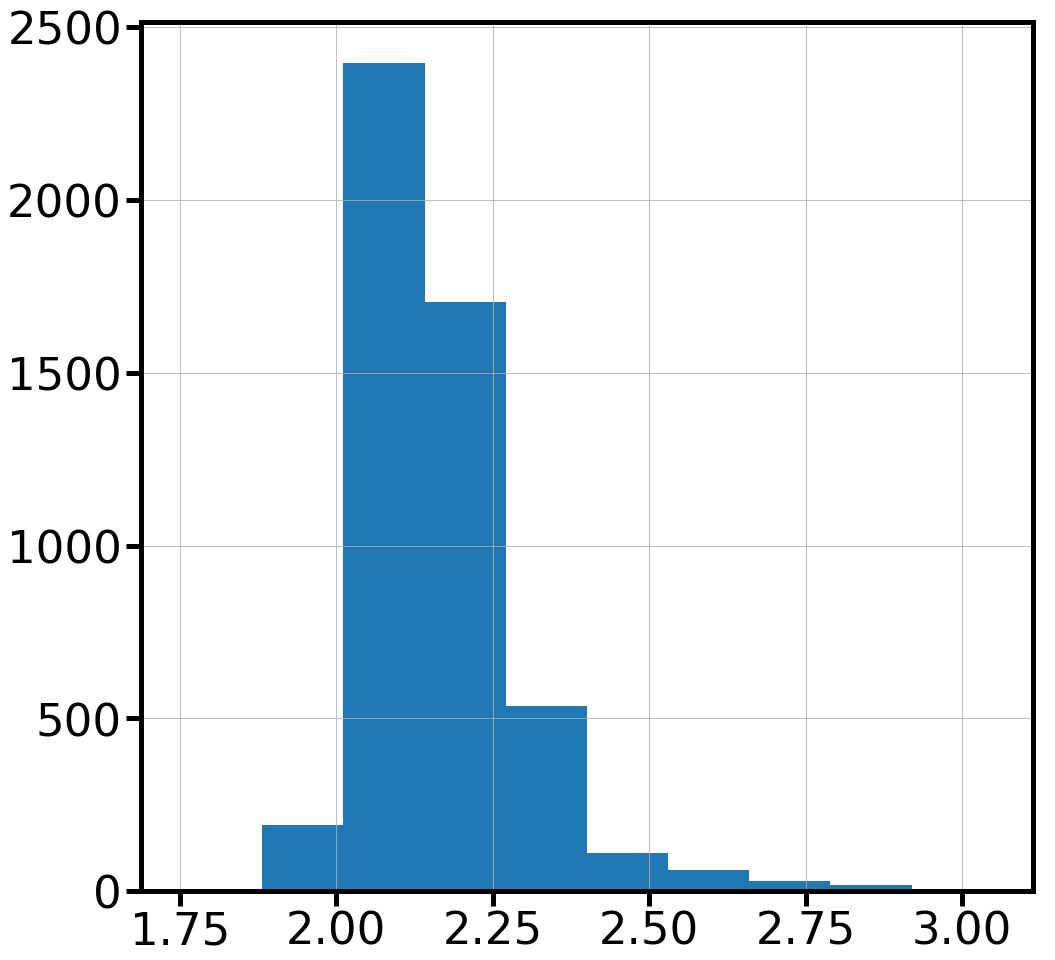

In [138]:
dfL.R200Parent.hist()

# jstar

9.5 10.0
[       nan        nan        nan        nan 2.19991046 2.32072497
 2.50934537 2.64223871        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan] [       nan        nan        nan        nan 2.36587934 2.53537134
 2.6343896  2.77141649        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan] [       nan        nan        nan        nan 2.56897712 2.61984007
 2.69095494 2.86325955        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan]
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan] [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan] [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan]
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan] [nan nan nan nan nan nan nan nan 

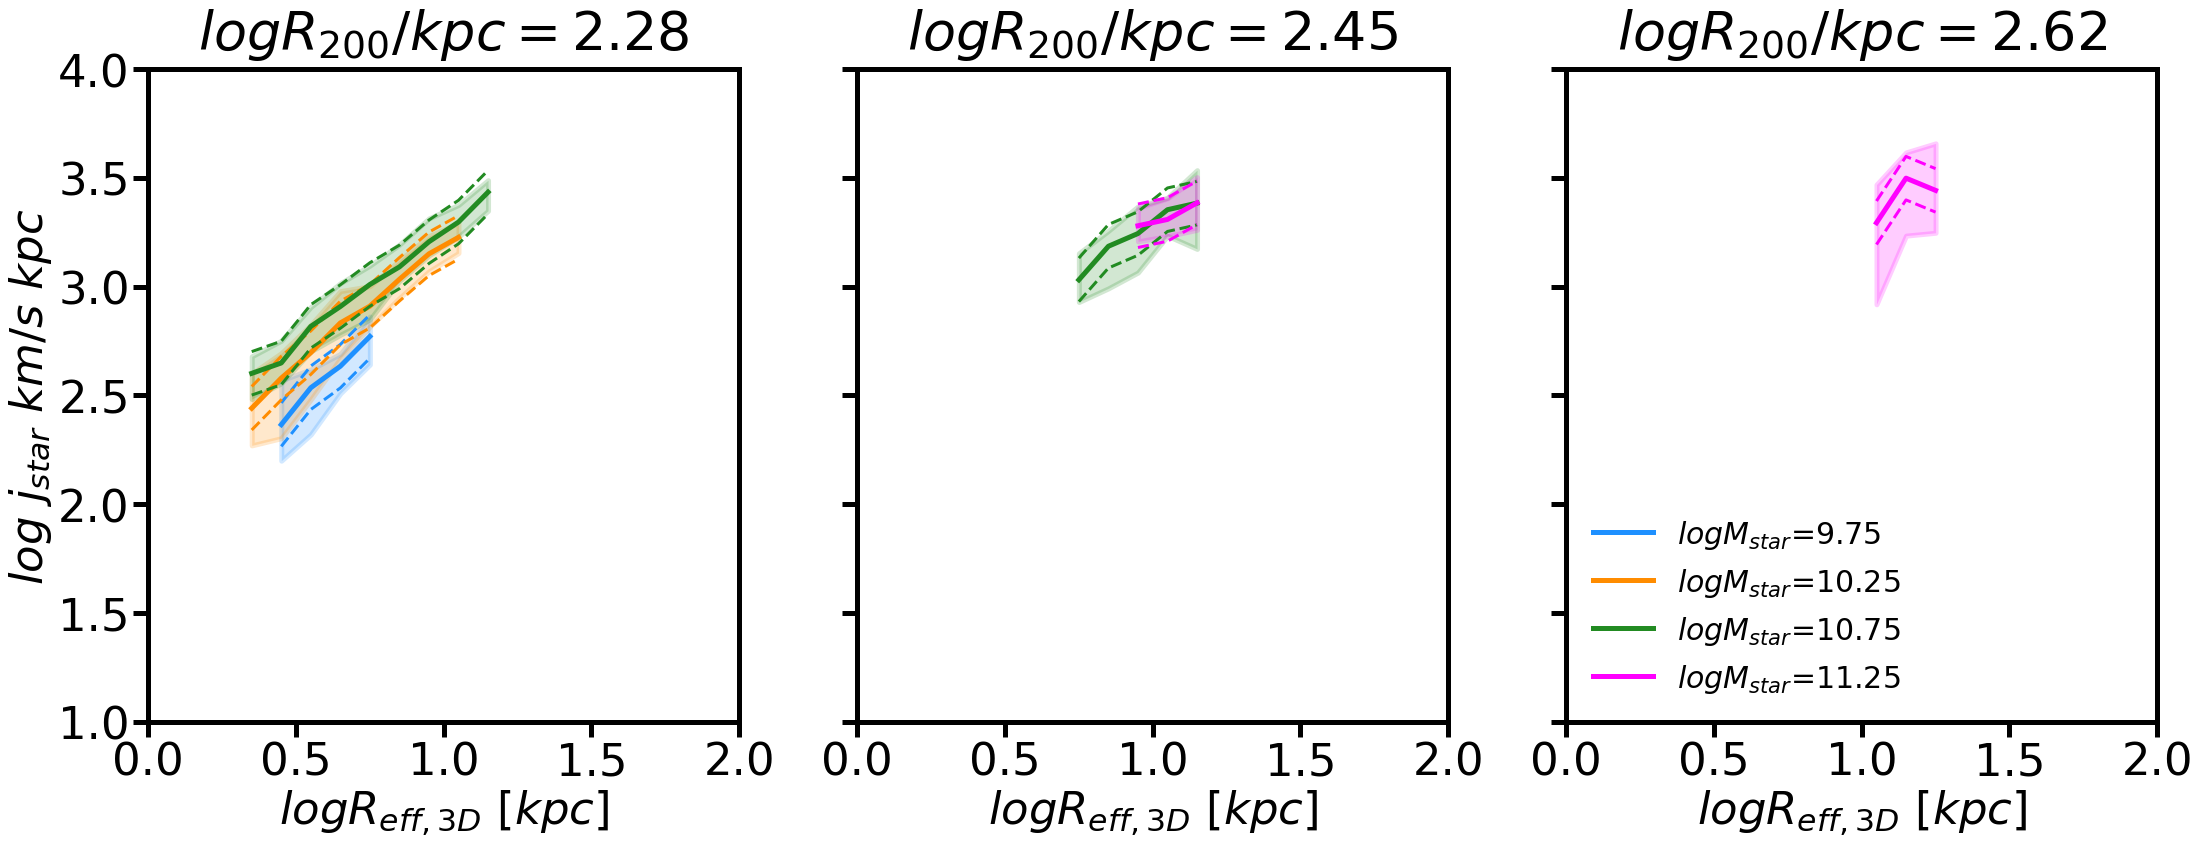

In [18]:
# width = 0.1
rhalobins = np.linspace(2.2,2.7,4)
mstarbins = np.linspace(9.5,11.5,5)

colors = ['dodgerblue','darkorange','forestgreen','magenta']
# cecolors = ['cyan','gold',]
fig, ax = plt.subplots(1,3, sharex=True, sharey=True, figsize=(36,12))


for j,mstar in enumerate(mstarbins[1:]):
    
    print(mstarbins[j],mstarbins[j+1])
    dfL_ = dfL[(dfL['LogMass30']>mstarbins[j]) & (dfL['LogMass30']<mstarbins[j+1])]

    for i,this_ax in enumerate(ax.ravel()):

        dfL_1 = dfL_[(dfL_['R200Parent']>rhalobins[i]) & (dfL_['R200Parent']<rhalobins[i+1])]
        rebins = np.arange(0,2,width)
        low_LTGs,med_LTGs,up_LTGs = make_percentiles(dfL_1['Re'].values, dfL_1['jstar_all'], 
                                       rebins)
        if j==0:
            print(low_LTGs,med_LTGs,up_LTGs)
    #weigths = 1-weights
    #low_ETGs,med_ETGs,up_ETGs = make_percentiles(dfE['Re'].values, dfE['jstar_1re'], 
                                   #rebins)

        rhb = rebins[1:] -width/2.
        medd = (mstarbins[j]+mstarbins[j+1])/2
        this_ax.plot(rhb, med_LTGs, color=colors[j],lw=5, label=r'$logM_{star}$='+str(np.round(medd,2)) )
        this_ax.fill_between(rhb,low_LTGs,up_LTGs, color=colors[j], alpha=0.2,lw=5)
        #plt.plot(rhb, med_ETGs, color='firebrick' ,lw=5,label='P_Late<0.5')
        #plt.fill_between(rhb,low_ETGs,up_ETGs, color='salmon', alpha=0.4,lw=5)


        this_ax.plot(rhb, med_LTGs+0.1, color=colors[j], ls='--',lw=3)
        #plt.plot(rhb, med_ETGs+0.2, color='firebrick', ls='--',lw=3)
        this_ax.plot(rhb, med_LTGs-0.1, color=colors[j], ls='--',lw=3)
        medd = (rhalobins[i]+rhalobins[i+1])/2
        this_ax.set_title(r'$logR_{200}/kpc=$'+str(np.round(medd,2)))
    #plt.plot(rhb, med_ETGs-0.2, color='firebrick', ls='--',lw=3)

    

        

#plt.axvline(completeness, color='gray', label='completeness limit')

        
    
    ax[0].set_ylabel('$log \ j_{star} \ km/s \ kpc$')
   # ax[1].set_ylabel('$logj_{star} \ km/s \ kpc$')
   # ax[2].set_ylabel('$logj_{star} \ km/s \ kpc$')
    for k in range(3):
        ax[k].set_xlabel('$logR_{eff,3D} \ [kpc]$')
    
ax[1].plot(rhb, 2000*rhb-0.2, color='black', ls='--',lw=3, label='0.2 dex scatter')
    
for this_ax in ax.ravel():
    this_ax.set_ylim(1,4)
    this_ax.set_xlim(0,2.)
ax[2].legend(fontsize=30,frameon=False)    
plt.savefig('/home/lz1f17/Pictures/Paper/simulations/correlations_Re_jstarall_r200_all.png')
    #plt.close()
    

    
#plt.xlabel(r'$logR_{e,3D} \  [kpc]$')
#plt.ylabel(r'$logj_{star}(<1R_{e,3D}) \ [kpc]$')
#plt.title(r'$logM_{star}>9.5 \ centrals \ only$')
#plt.legend(frameon=False, fontsize=25)
#plt.tight_layout()
#plt.savefig('/home/lz1f17/Pictures/Paper/jstar_1re_Re3d_TNG.png')

In [15]:
10**0.1

1.2589254117941673

9.5 10.0
10.0 10.5
10.5 11.0
11.0 11.5


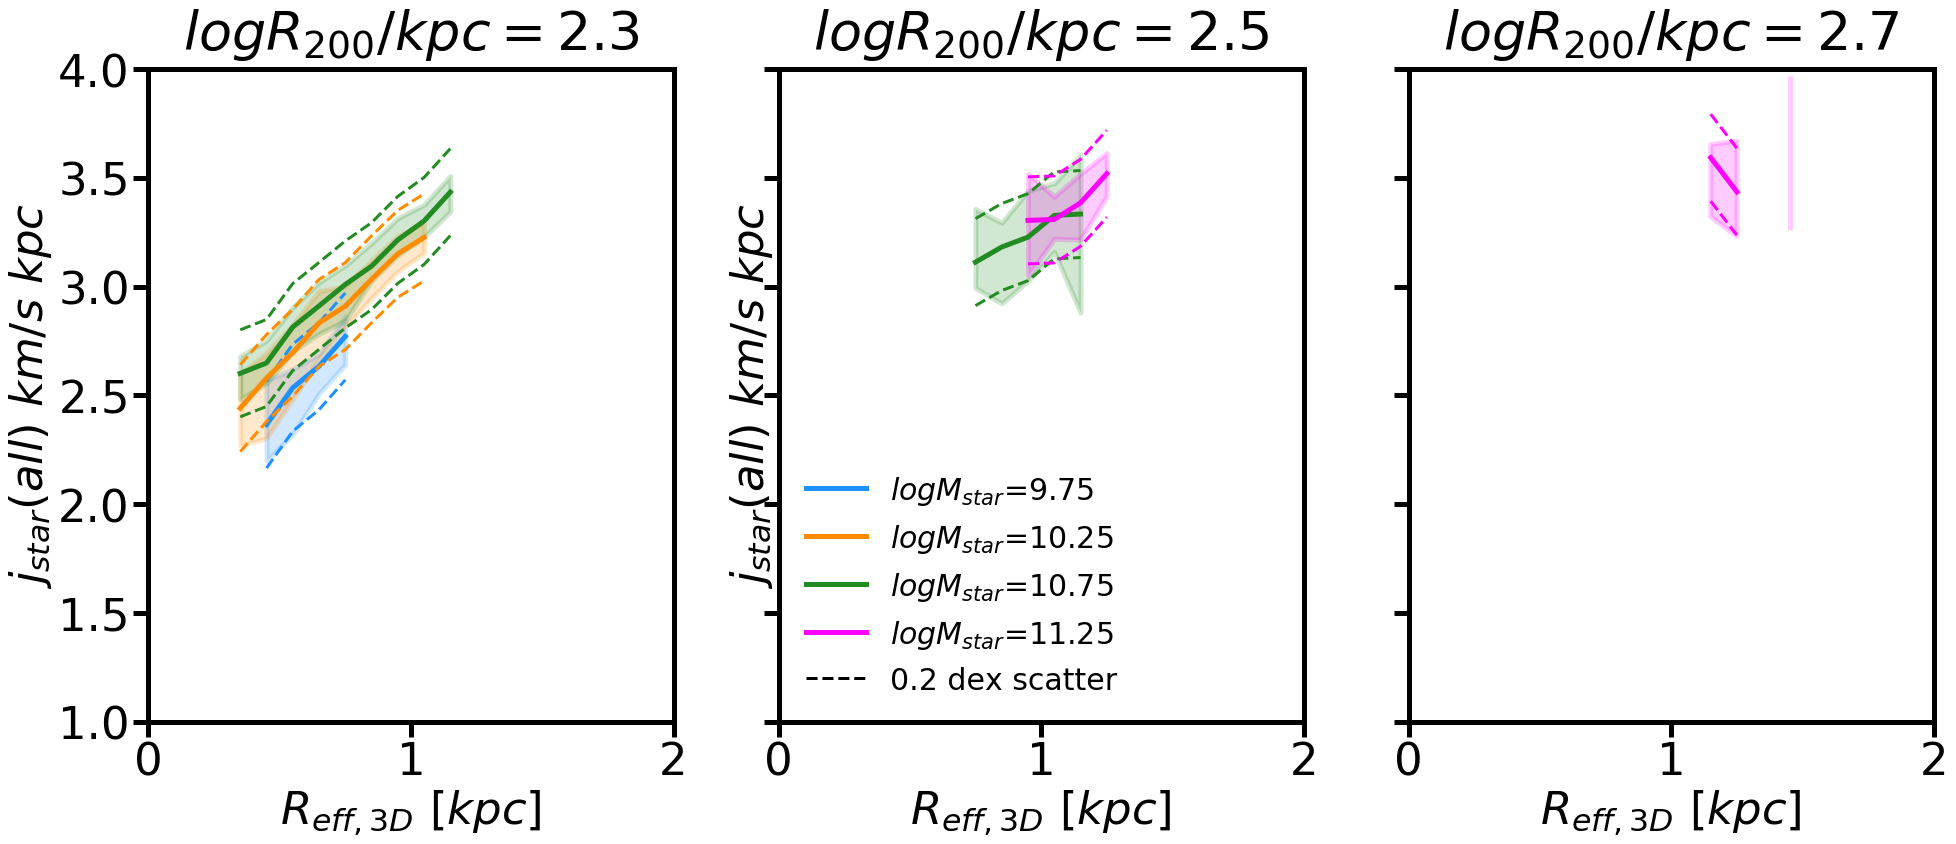

In [123]:
# width = 0.1
rhalobins = np.linspace(2.2,2.8,4)
mstarbins = np.linspace(9.5,11.5,5)

colors = ['dodgerblue','darkorange','forestgreen','magenta']
# cecolors = ['cyan','gold',]
fig, ax = plt.subplots(1,3, sharex=True, sharey=True, figsize=(32,12))


for j,mstar in enumerate(mstarbins[1:]):
    
    print(mstarbins[j],mstarbins[j+1])
    dfL_ = dfL[(dfL['LogMass30']>mstarbins[j]) & (dfL['LogMass30']<mstarbins[j+1])]

    for i,this_ax in enumerate(ax.ravel()):

        dfL_1 = dfL_[(dfL_['R200Parent']>rhalobins[i]) & (dfL_['R200Parent']<rhalobins[i+1])]
        rebins = np.arange(0,2,width)
        low_LTGs,med_LTGs,up_LTGs = make_percentiles(dfL_1['Re'].values, dfL_1['jstar_all'], 
                                       rebins)
    #weigths = 1-weights
    #low_ETGs,med_ETGs,up_ETGs = make_percentiles(dfE['Re'].values, dfE['jstar_1re'], 
                                   #rebins)

        rhb = rebins[1:] -width/2.
        medd = (mstarbins[j]+mstarbins[j+1])/2
        this_ax.plot(rhb, med_LTGs, color=colors[j],lw=5, label=r'$logM_{star}$='+str(np.round(medd,2)) )
        this_ax.fill_between(rhb,low_LTGs,up_LTGs, color=colors[j], alpha=0.2,lw=5)
        #plt.plot(rhb, med_ETGs, color='firebrick' ,lw=5,label='P_Late<0.5')
        #plt.fill_between(rhb,low_ETGs,up_ETGs, color='salmon', alpha=0.4,lw=5)


        this_ax.plot(rhb, med_LTGs+0.2, color=colors[j], ls='--',lw=3)
        #plt.plot(rhb, med_ETGs+0.2, color='firebrick', ls='--',lw=3)
        this_ax.plot(rhb, med_LTGs-0.2, color=colors[j], ls='--',lw=3)
        medd = (rhalobins[i]+rhalobins[i+1])/2
        this_ax.set_title(r'$logR_{200}/kpc=$'+str(np.round(medd,2)))
    #plt.plot(rhb, med_ETGs-0.2, color='firebrick', ls='--',lw=3)

    

        

#plt.axvline(completeness, color='gray', label='completeness limit')

        
    
    ax[0].set_ylabel('$j_{star}(all) \ km/s \ kpc$')
    ax[1].set_ylabel('$j_{star}(all) \ km/s \ kpc$')

    for k in range(3):
        ax[k].set_xlabel('$R_{eff,3D} \ [kpc]$')
    
ax[1].plot(rhb, 2000*rhb-0.2, color='black', ls='--',lw=3, label='0.2 dex scatter')
    
for this_ax in ax.ravel():
    this_ax.set_ylim(1,4)
    this_ax.set_xlim(0,2.)
ax[1].legend(fontsize=30,frameon=False)    
#plt.savefig('/home/lz1f17/Pictures/Paper/simulations/correlations_Re_jstarall_r200_all.png')
    #plt.close()
    

    
#plt.xlabel(r'$logR_{e,3D} \  [kpc]$')
#plt.ylabel(r'$logj_{star}(<1R_{e,3D}) \ [kpc]$')
#plt.title(r'$logM_{star}>9.5 \ centrals \ only$')
#plt.legend(frameon=False, fontsize=25)
#plt.tight_layout()
#plt.savefig('/home/lz1f17/Pictures/Paper/jstar_1re_Re3d_TNG.png')

mstar= 9.783333333333333, rhalo=2.3, sigma_up=0.3093102674462598, sigma_low=0.2643218571603323
mstar= 9.783333333333333, rhalo=2.3, sigma_up=0.22180600194887967, sigma_low=0.21578518476404618
mstar= 9.783333333333333, rhalo=2.3, sigma_up=0.11987988561036467, sigma_low=0.4058409560481757
mstar= 10.35, rhalo=2.3, sigma_up=0.3295625361162231, sigma_low=0.15395473567715756
mstar= 10.35, rhalo=2.3, sigma_up=0.30052946694416116, sigma_low=0.2007399561346621
mstar= 10.35, rhalo=2.3, sigma_up=0.2837788033088051, sigma_low=0.2156156763283117
mstar= 10.916666666666666, rhalo=2.3, sigma_up=0.24818709965472774, sigma_low=0.13416368251336674
mstar= 10.916666666666666, rhalo=2.3, sigma_up=0.29965528445129586, sigma_low=0.15113666100667755
mstar= 10.916666666666666, rhalo=2.3, sigma_up=0.23844449304690762, sigma_low=0.18112144500162985
mstar= 10.916666666666666, rhalo=2.5, sigma_up=0.20704971482834233, sigma_low=0.3209305991465956
mstar= 10.916666666666666, rhalo=2.5, sigma_up=0.3547093300285771, sig

/home/lz1f17/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "
/home/lz1f17/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "
/home/lz1f17/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "
/home/lz1f17/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


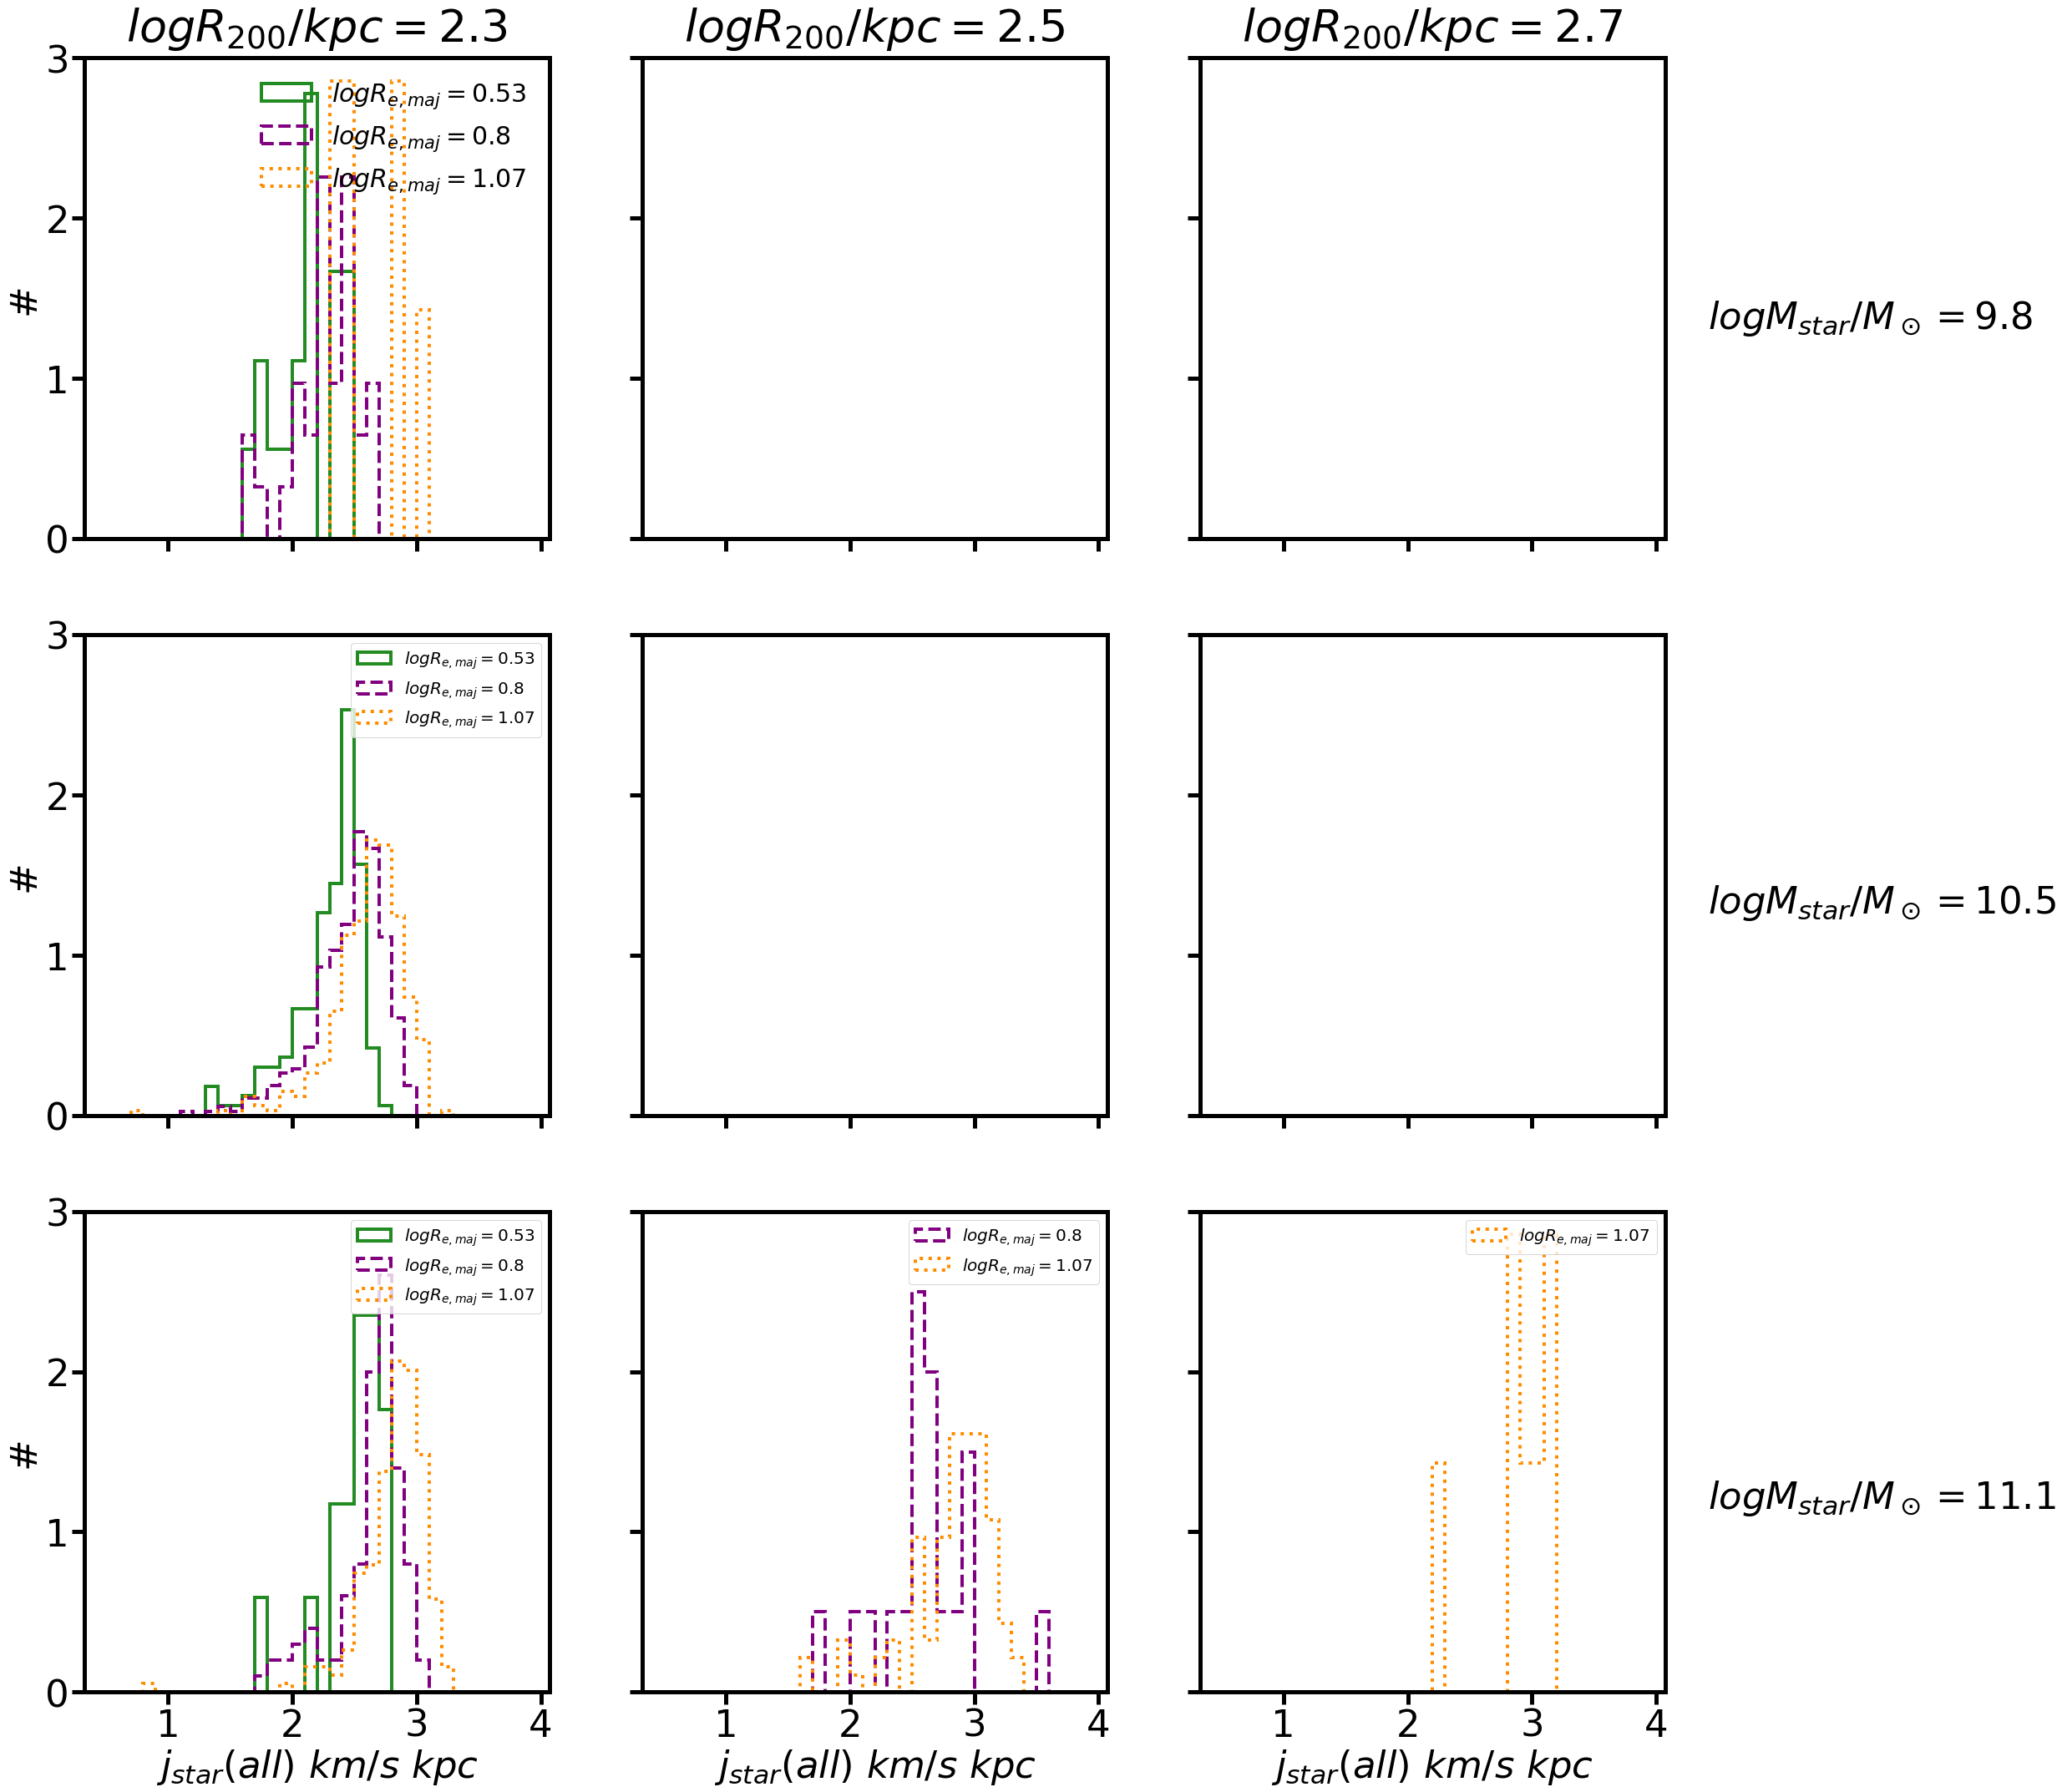

In [188]:
# width = 0.1
rhalobins = np.linspace(2.2,2.8,4)
mstarbins = np.linspace(9.5,11.2,4)
rebins = np.linspace(0.4,1.2,4)
colors = ['forestgreen','purple','darkorange','brown']
linestyles = ['-','--',':','-.']
# cecolors = ['cyan','gold',]
fig, ax = plt.subplots(3,3, sharex=True, sharey=True, figsize=(36,36))



    
for j,mstar in enumerate(mstarbins[1:]):
    medd = (mstarbins[j]+mstarbins[j+1])/2
    dfL_ = dfL[(dfL['LogMass30']>mstarbins[j]) & (dfL['LogMass30']<mstarbins[j+1])]
    for i, rh in enumerate(rhalobins[1:]):
        dfL_1 = dfL_[(dfL_['R200Parent']>rhalobins[i]) & (dfL_['R200Parent']<rhalobins[i+1])]
        meddh = (rhalobins[i]+rhalobins[i+1])/2
        ax[0][i].set_title(r'$logR_{200}/kpc=$'+str(np.round(meddh,2)))
        for k,rb in enumerate(rebins[1:]):
            
            if len(dfL_1)>10:

                #try:
                #low,up = np.percentile(dfL_1[df.R200Parent>completeness]['jstar_2re'].values, [0.5,99.5])
                dfL_2 = dfL_1[(dfL_1['rhalf_ellip']>rebins[k]) & (dfL_1['rhalf_ellip']<rebins[k+1])]
                meddre = (rebins[k]+rebins[k+1])/2
                if len(dfL_2)>5:
                   
                    jstarbins = np.arange(0.5,4,0.1)

                    ax[j][i].hist(dfL_2['jstar_2re'], bins=jstarbins, label=r'$logR_{e,maj}=$'+str(np.round(meddre,2)),
                             histtype='step', lw=4, normed=True, color=colors[k], ls=linestyles[k])
                    low,med,up = np.percentile(dfL_2['jstar_2re'], [16,50,84])
                #rebins = np.arange(0,2,width)
                #low_LTGs,med_LTGs,up_LTGs = make_percentiles(dfL_1['Re'].values, dfL_1['jstar_all'], 
                #                               rebins)
            #weigths = 1-weights
            #low_ETGs,med_ETGs,up_ETGs = make_percentiles(dfE['Re'].values, dfE['jstar_1re'], 
                #rebins)
                  #  except:
                 #       pass
                    print('mstar= {}, rhalo={}, sigma_up={}, sigma_low={}'.format(medd,meddh, med-low, up-med))
    #plt.plot(rhb, med_ETGs-0.2, color='firebrick', ls='--',lw=3)

    

        

#plt.axvline(completeness, color='gray', label='completeness limit')

        
    
    

    for k in range(3):
        ax[2][k].set_xlabel('$j_{star}(all) \ km/s \ kpc$')
        ax[k][0].set_ylabel('#')
        
    
#for this_ax in ax.ravel():
#    this_ax.set_ylim(1,4)
#    this_ax.set_xlim(0,2.)
for this_ax in ax.ravel():
    this_ax.legend(fontsize=20)

ax[0][0].legend(fontsize=30,frameon=False)    
#plt.savefig('/home/lz1f17/Pictures/Paper/simulations/correlations_Re_jstarall_r200_all.png')
    #plt.close()
    
fig.text(0.82,0.755, '$logM_{star}/M_\odot=9.8$')
fig.text(0.82,0.485, '$logM_{star}/M_\odot=10.5$')
fig.text(0.82,0.21, '$logM_{star}/M_\odot=11.1$')
plt.subplots_adjust(left=0.07,right=0.8)

#plt.xlabel(r'$logR_{e,3D} \  [kpc]$')
#plt.ylabel(r'$logj_{star}(<1R_{e,3D}) \ [kpc]$')
#plt.title(r'$logM_{star}>9.5 \ centrals \ only$')
#plt.legend(frameon=False, fontsize=25)
#plt.tight_layout()
#plt.savefig('/home/lz1f17/Pictures/Paper/jstar_1re_Re3d_TNG.png')

/home/lz1f17/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/lz1f17/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/lz1f17/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/lz1f17/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/lz1f17/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/lz1f17/anaconda3/lib/python3.6/site-packages/ipykernel_

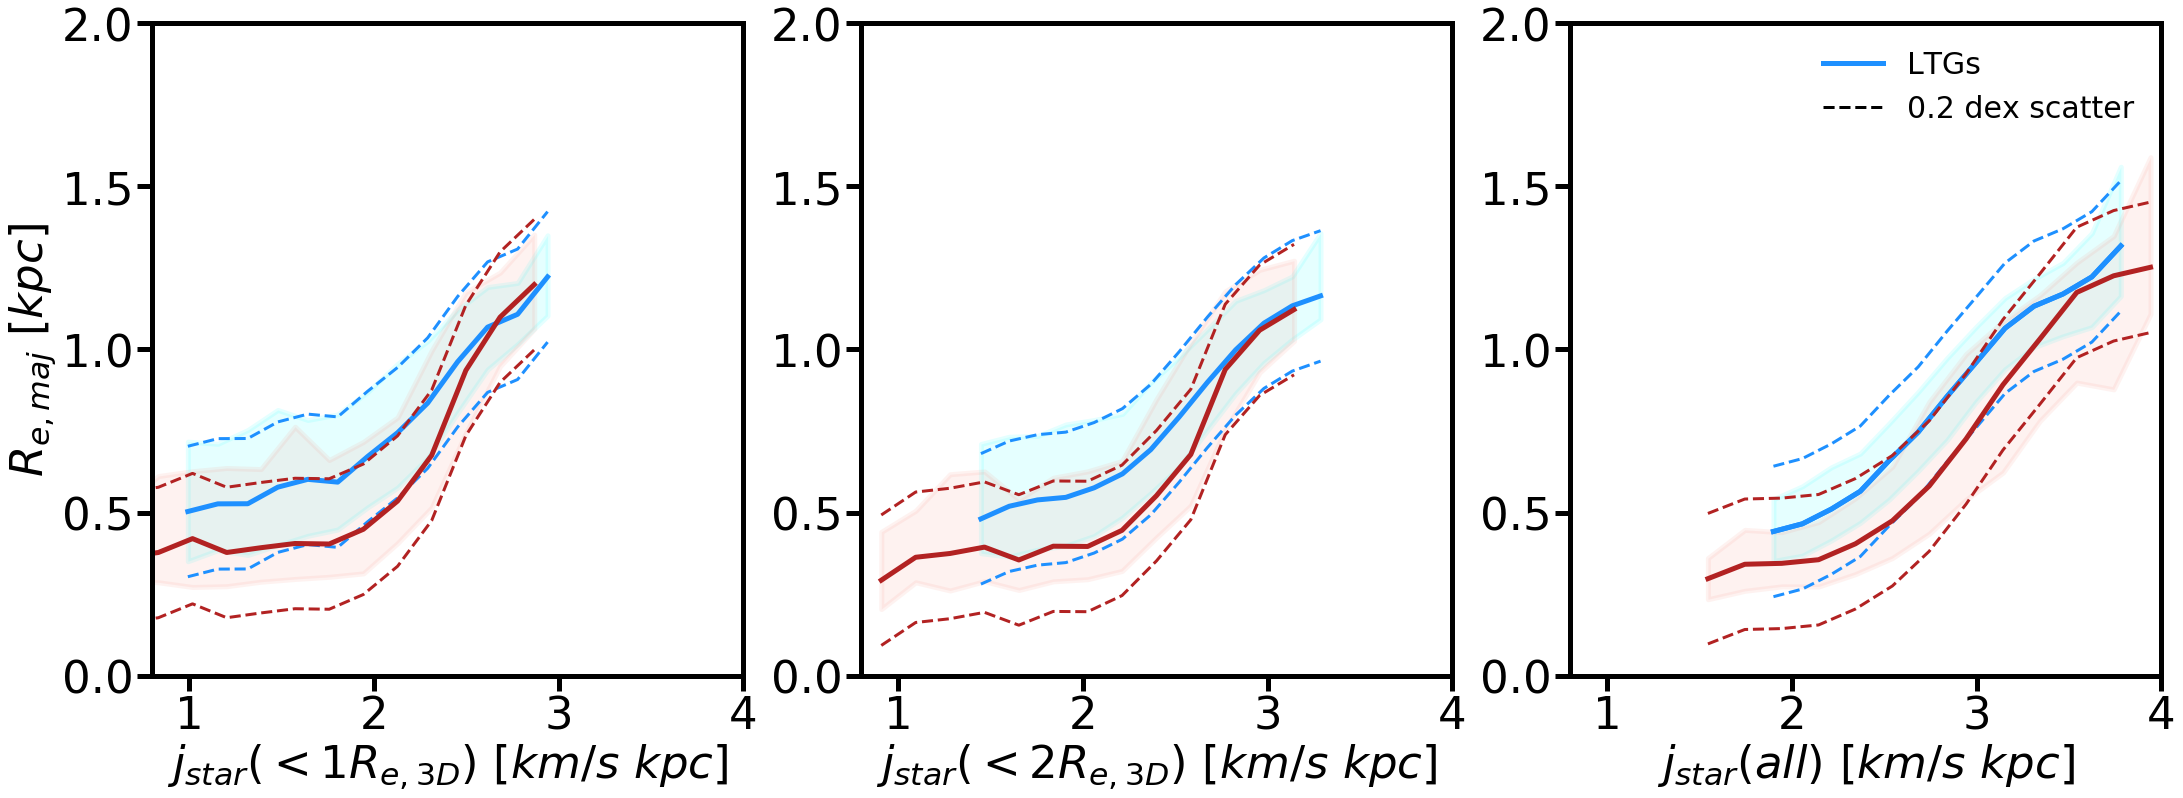

In [17]:


fig,ax = plt.subplots(1,3, figsize=(36,12))

colors = ['forestgreen','darkorange','purple']
facecolors = ['lime','gold','hotpink']

choices = ['jstar_1re','jstar_2re','jstar_all']
xlabels = ['$j_{star}(<1R_{e,3D}) \ [km/s \ kpc]$', '$j_{star}(<2R_{e,3D}) \ [km/s \ kpc]$',\
          '$j_{star}(all) \ [km/s \ kpc]$']
for i, this_ax in enumerate(ax.ravel()):

    low,up = np.percentile(dfL[df.R200Parent>completeness][choices[i]].values, [0.5,99.5])
    jstarbins = np.linspace(low,up,14)
    low_LTGs,med_LTGs,up_LTGs = make_percentiles(dfL[choices[i]], dfL['rhalf_ellip'].values , 
                               jstarbins)
    rhb = jstarbins[1:]-(jstarbins[1]-jstarbins[0])/2.

    if i==2:
        this_ax.plot(rhb, med_LTGs, color='dodgerblue',lw=5, label='LTGs' )
    this_ax.plot(rhb, med_LTGs, color='dodgerblue',lw=5)
    this_ax.fill_between(rhb,low_LTGs,up_LTGs,color='cyan', alpha=0.1,lw=5)
    this_ax.plot(rhb, med_LTGs+0.2, color='dodgerblue', ls='--',lw=3)
    this_ax.plot(rhb, med_LTGs-0.2, color='dodgerblue', ls='--',lw=3)
    this_ax.set_xlabel(xlabels[i])
    
    
    low,up = np.percentile(dfE[df.R200Parent>completeness][choices[i]].values, [0.5,99.5])
    jstarbins = np.linspace(low,up,14)
    low_LTGs,med_LTGs,up_LTGs = make_percentiles(dfE[choices[i]], dfE['rhalf_ellip'].values , 
                               jstarbins)
    rhb = jstarbins[1:]-(jstarbins[1]-jstarbins[0])/2.

    this_ax.plot(rhb, med_LTGs, color='firebrick',lw=5 )
    this_ax.fill_between(rhb,low_LTGs,up_LTGs,color='salmon', alpha=0.1,lw=5)
    this_ax.plot(rhb, med_LTGs+0.2, color='firebrick', ls='--',lw=3)
    this_ax.plot(rhb, med_LTGs-0.2, color='firebrick', ls='--',lw=3)
    this_ax.set_xlabel(xlabels[i])
    
ax[0].set_ylabel('$R_{e,maj} \ [kpc]$')
ax[2].plot(rhb, 2000*rhb-0.2, color='black', ls='--',lw=3, label='0.2 dex scatter')

for this_ax in ax.ravel():
    this_ax.set_xlim(0.8,4)
    this_ax.set_ylim(0,2.)
    

ax[2].legend(frameon=False, fontsize=30)

In [189]:
from astropy.stats import bootstrap
from astropy.utils import NumpyRNGContext

In [195]:
            with NumpyRNGContext(1):
                resample = bootstrap(dfL_[choices[i]].values, 30).flatten()

(array([0.43438929, 0.43438929, 0.65158394, 0.65158394, 0.65158394,
        1.30316788, 1.08597324, 0.86877859, 0.86877859, 1.52036253,
        1.95475182, 1.52036253, 0.43438929, 0.        , 0.65158394,
        0.21719465, 0.43438929, 0.        , 0.        , 0.21719465]),
 array([2.87584085, 2.94778092, 3.019721  , 3.09166108, 3.16360116,
        3.23554124, 3.30748132, 3.3794214 , 3.45136147, 3.52330155,
        3.59524163, 3.66718171, 3.73912179, 3.81106187, 3.88300195,
        3.95494203, 4.0268821 , 4.09882218, 4.17076226, 4.24270234,
        4.31464242]),
 <a list of 20 Patch objects>)

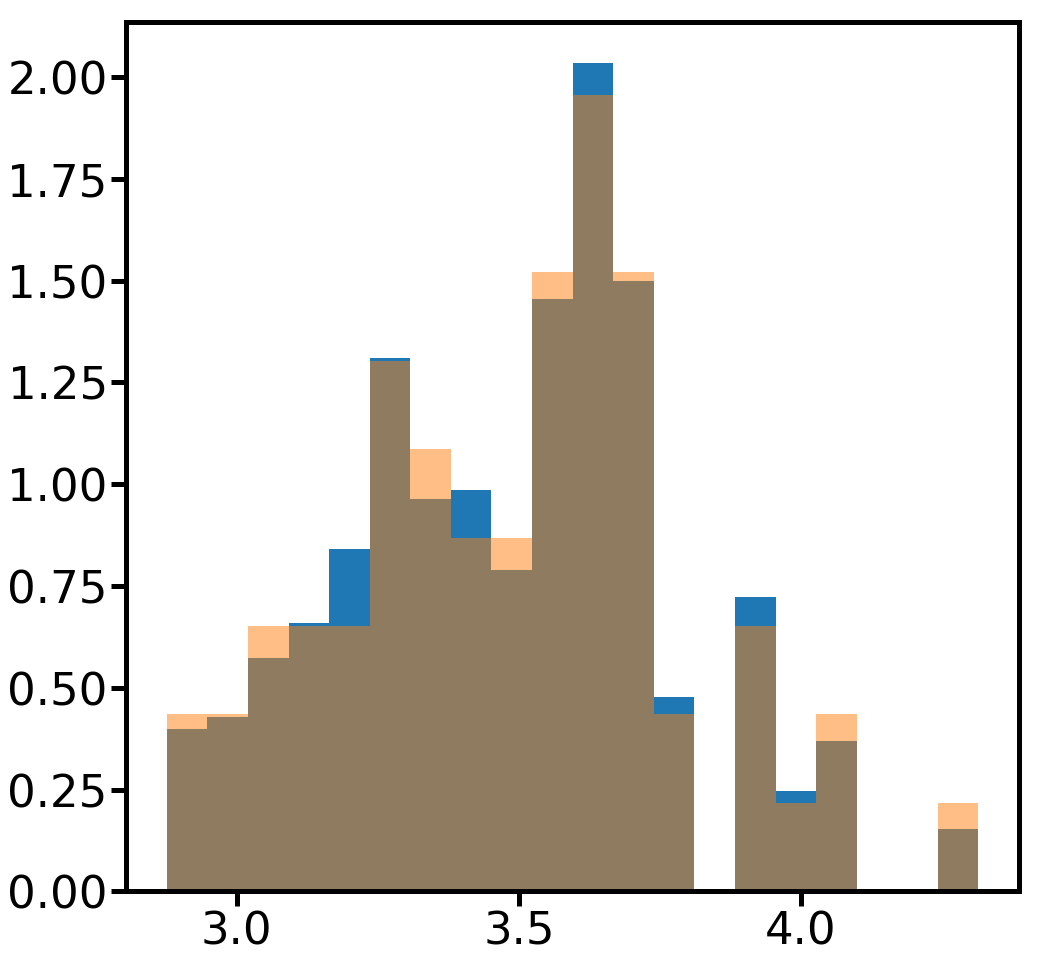

In [198]:
plt.hist(resample,bins=20,normed=True)
plt.hist(dfL_[choices[i]].values, normed=True, alpha=0.5, bins=20)

In [212]:
plt.subplots_adjust?

Signature: plt.subplots_adjust(*args, **kwargs)
Docstring:
Tune the subplot layout.

call signature::

  subplots_adjust(left=None, bottom=None, right=None, top=None,
                  wspace=None, hspace=None)

The parameter meanings (and suggested defaults) are::

  left  = 0.125  # the left side of the subplots of the figure
  right = 0.9    # the right side of the subplots of the figure
  bottom = 0.1   # the bottom of the subplots of the figure
  top = 0.9      # the top of the subplots of the figure
  wspace = 0.2   # the amount of width reserved for blank space between subplots,
                 # expressed as a fraction of the average axis width
  hspace = 0.2   # the amount of height reserved for white space between subplots,
                 # expressed as a fraction of the average axis height

The actual defaults are controlled by the rc file
File:      ~/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py
Type:      function


64
64
64


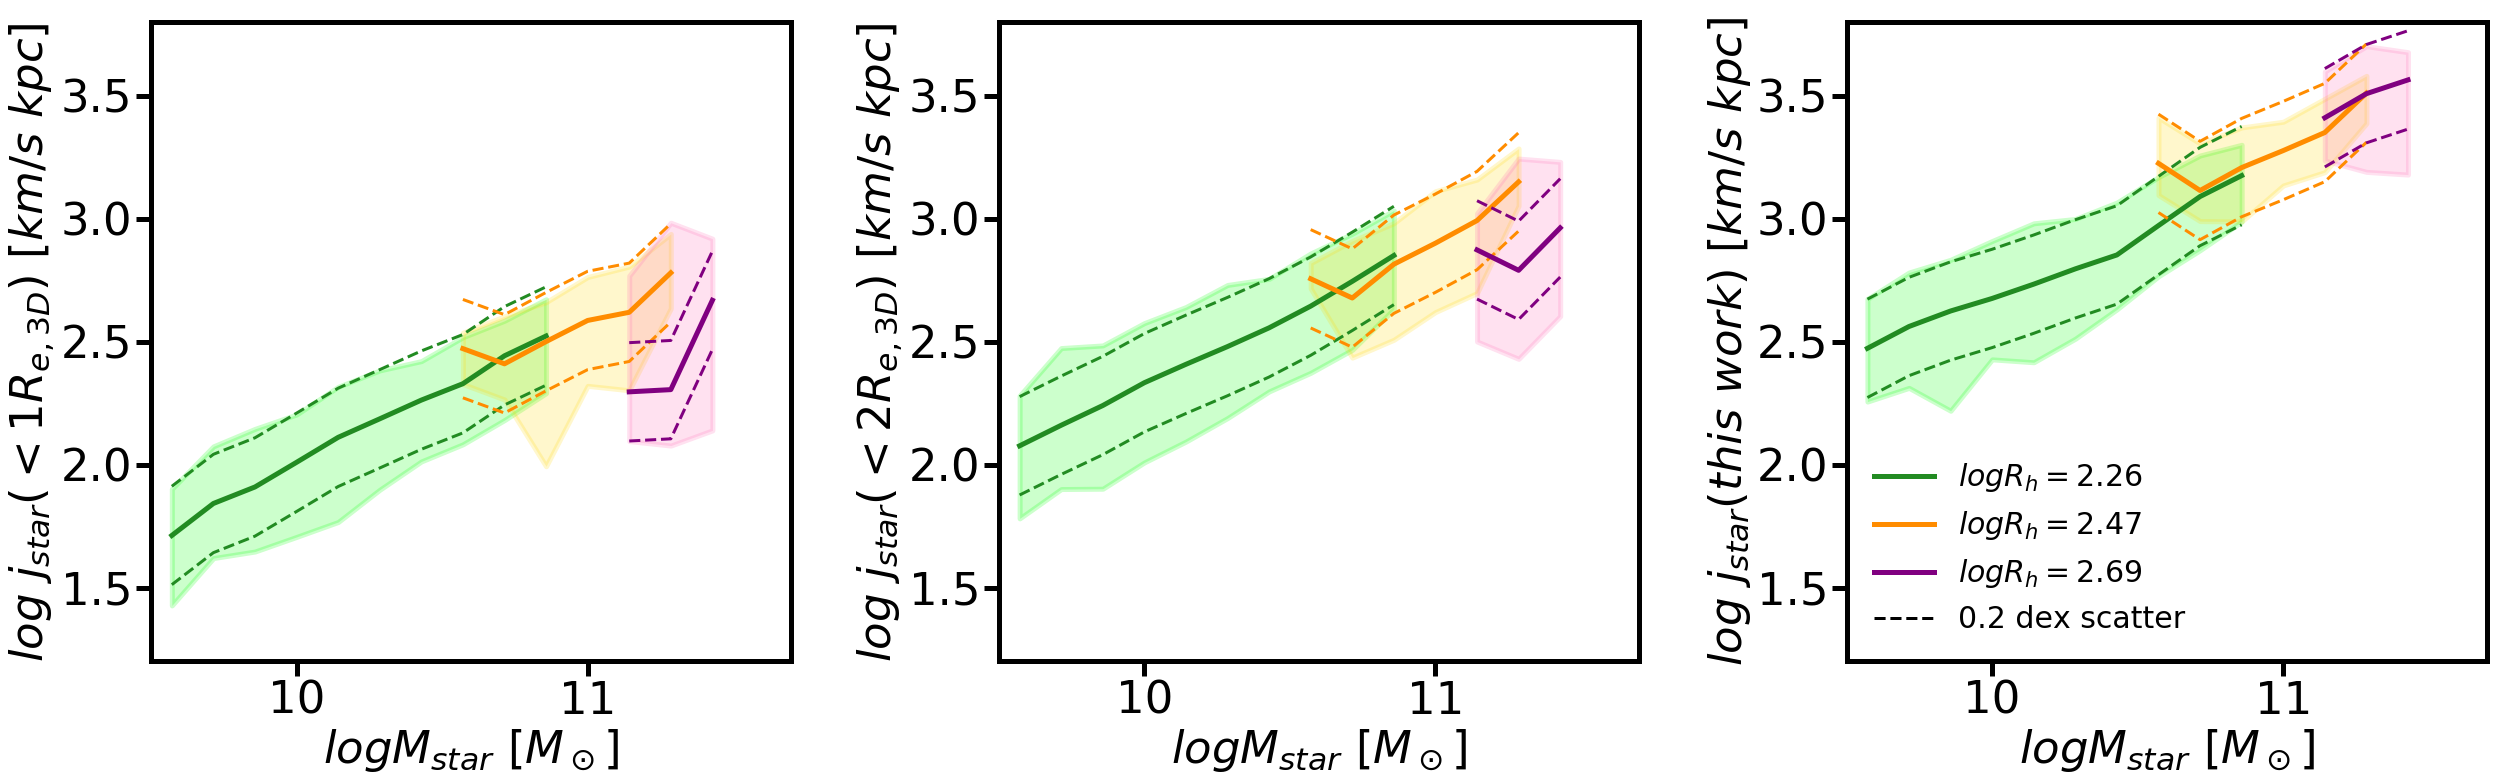

In [19]:


fig,ax = plt.subplots(1,3, figsize=(36,12))

colors = ['forestgreen','darkorange','purple']
facecolors = ['lime','gold','hotpink']

choices = ['jstar_1re','jstar_2re','jstar_all']
xlabels = ['$log \ j_{star}(<1R_{e,3D}) \ [km/s \ kpc]$', '$log \ j_{star}(<2R_{e,3D}) \ [km/s \ kpc]$',\
          '$log \ j_{star}(this \ work) \ [km/s \ kpc]$']
for i, this_ax in enumerate(ax.ravel()):

    #low,up = np.percentile(dfL[df.R200Parent>completeness][choices[i]].values, [0.5,99.5])
    jstarbins = np.linspace(9.5,11.5,15) #np.linspace(low,up,14)
    
    rhalobins = np.linspace(2.15,2.8,4)
    
    for j,b in enumerate(rhalobins[1:]):
        dfL_ = dfL[(dfL['R200Parent']>rhalobins[j]) & (dfL['R200Parent']<rhalobins[j+1])]
        
        if j==2:
            
            print(len(dfL_))
        
        if len(dfL_)>10:

            low_LTGs,med_LTGs,up_LTGs = make_percentiles(dfL_['LogMass30'], dfL_[choices[i]].values , 
                               jstarbins)
            rhb = jstarbins[1:]-(jstarbins[1]-jstarbins[0])/2.

            meddh = (rhalobins[j]+rhalobins[j+1])/2
            this_ax.plot(rhb, med_LTGs, color=colors[j],lw=5, label='$logR_{h}=$'+str(np.round(meddh,2)))
            this_ax.fill_between(rhb,low_LTGs,up_LTGs,color=facecolors[j], alpha=0.2,lw=5)
            this_ax.plot(rhb, med_LTGs+0.2, color=colors[j], ls='--',lw=3)
            this_ax.plot(rhb, med_LTGs-0.2, color=colors[j], ls='--',lw=3)
            this_ax.set_ylabel(xlabels[i])
            #this_ax.set_xlabel('$logM_{star} \ [M_\odot]$')    
    
#for i, this_ax in enumerate(ax[1].ravel()):

    #low,up = np.percentile(dfL[df.R200Parent>completeness][choices[i]].values, [0.5,99.5])
#    jstarbins = np.linspace(9.5,11.5,15) #np.linspace(low,up,14)
    
#    rhalobins = np.linspace(completeness,2.8,4)
    
#    for j,b in enumerate(rhalobins[1:]):
#        dfL_ = dfE[(dfE['R200Parent']>rhalobins[j]) & (dfE['R200Parent']<rhalobins[j+1])]
#        if j==2:
            
#            print(len(dfL_))
        
#        if len(dfL_)>10:
#            with NumpyRNGContext(1):
#                resample = bootstrap(dfL_[choices[i]].values, 20).flatten()
#            low_LTGs,med_LTGs,up_LTGs = make_percentiles(dfL_['LogMass30'], dfL_[choices[i]].values , 
#                               jstarbins)
#            rhb = jstarbins[1:]-(jstarbins[1]-jstarbins[0])/2.###

#            meddh = (rhalobins[j]+rhalobins[j+1])/2#
#            this_ax.plot(rhb, med_LTGs, color=colors[j],lw=5, label='$logR_{200}=$'+str(np.round(meddh,2)))
#            this_ax.fill_between(rhb,low_LTGs,up_LTGs,color=facecolors[j], alpha=0.2,lw=5)
#            this_ax.plot(rhb, med_LTGs+0.2, color=colors[j], ls='--',lw=3)
#            this_ax.plot(rhb, med_LTGs-0.2, color=colors[j], ls='--',lw=3)
#            this_ax.set_ylabel(xlabels[i])
            this_ax.set_xlabel('$logM_{star} \ [M_\odot]$')   

ax[2].plot(rhb, 2000*rhb-0.2, color='black', ls='--',lw=3, label='0.2 dex scatter')

for this_ax in ax.ravel():
    this_ax.set_ylim(1.2,3.8)
    this_ax.set_xlim(9.5,11.7)
#fig.text(0.93,0.75,'LTGs')
#fig.text(0.93,0.25,'ETGs')
#plt.subplots_adjust(left=0.05,right=0.9, wspace=0.28)
ax[2].legend(frameon=False, fontsize=30)
plt.tight_layout()
plt.savefig('/home/lz1f17/Pictures/Paper/simulations/Mstar_jstar_allEstimates.png')

In [15]:
s,i,_,_,_ = linregress(dfL.LogMass30,dfL.jstar_2re)
s

0.5289756503494963

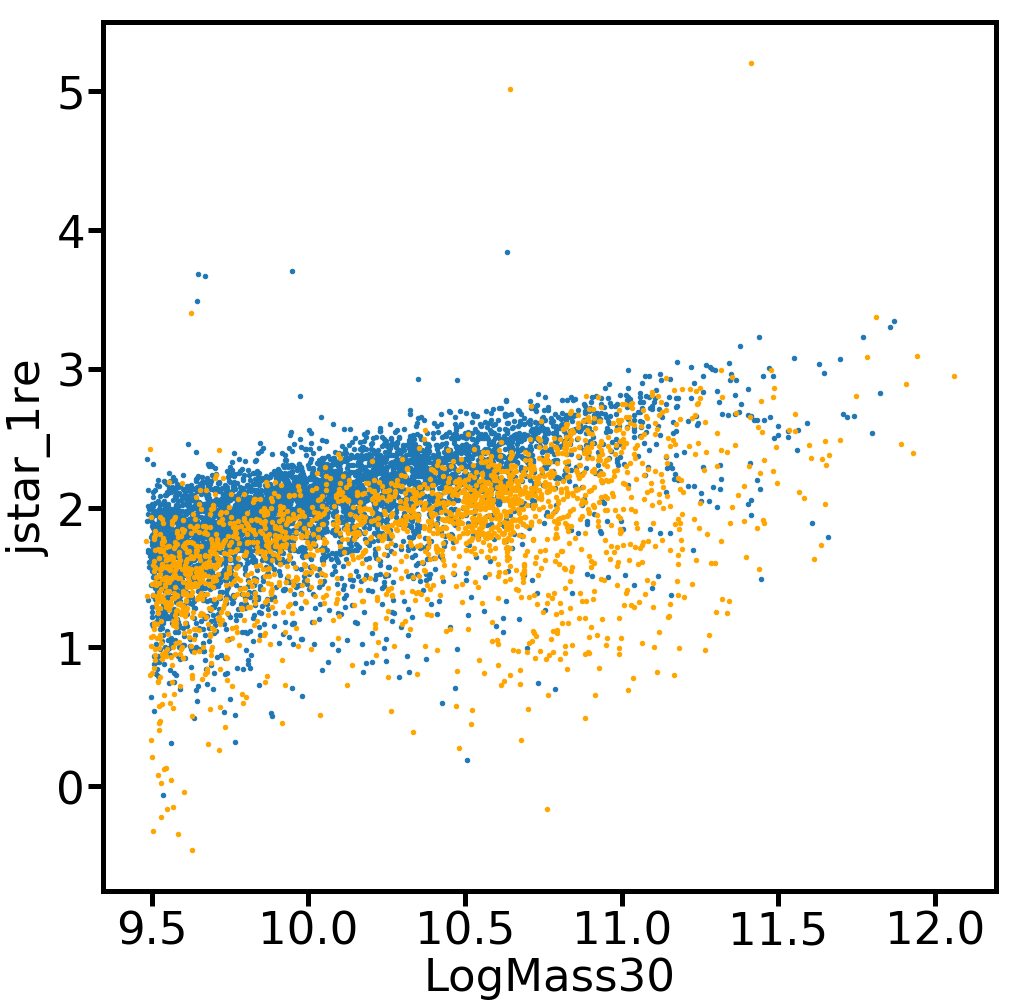

In [211]:
fig,ax = plt.subplots(1,1)
dfS0 = df[(df.P_Late_comp*df.P_S0_comp<]
dfL.plot.scatter(x='LogMass30',y='jstar_1re', ax=ax)
dfE.plot.scatter(x='LogMass30',y='jstar_1re', ax=ax,color='orange')

In [132]:
s,i,_,_,_ = linregress(dfL.LogMass30-11, dfL.jstar_2re)

In [133]:
s,i

(0.5289756503494961, 2.826377695249721)

In [129]:
bces.bces(y1=dfL.LogMass30,y1err=0, y2=dfL.jstar_all, y2err=0, cerr=0)

(array([0.63769568, 1.29839539, 0.91509073, 0.87417932]),
 array([ -3.78072943, -10.43327304,  -6.57380266,  -6.16186832]),
 array([0.00911988, 0.02401626, 0.0103015 , 0.01446106]),
 array([0.09240863, 0.24174159, 0.10478264, 0.14669459]),
 array([-0.00084185, -0.00580304, -0.00107837, -0.00212014]))

In [126]:
bces.bces?

Signature: bces.bces(y1, y1err, y2, y2err, cerr)
Docstring:
Does the entire regression calculation for 4 slopes:
OLS(Y|X), OLS(X|Y), bisector, orthogonal.
Fitting form: Y=AX+B.

Usage:

>>> a,b,aerr,berr,covab=bces(x,xerr,y,yerr,cov)

Output:

- a,b : best-fit parameters a,b of the linear regression 
- aerr,berr : the standard deviations in a,b
- covab : the covariance between a and b (e.g. for plotting confidence bands)

Arguments:

- x,y : data
- xerr,yerr: measurement errors affecting x and y
- cov : covariance between the measurement errors
(all are arrays)

v1 Mar 2012: ported from bces_regress.f. Added covariance output.
Rodrigo Nemmen, http://goo.gl/8S1Oo
        
File:      ~/anaconda3/lib/python3.6/site-packages/bces/bces.py
Type:      function


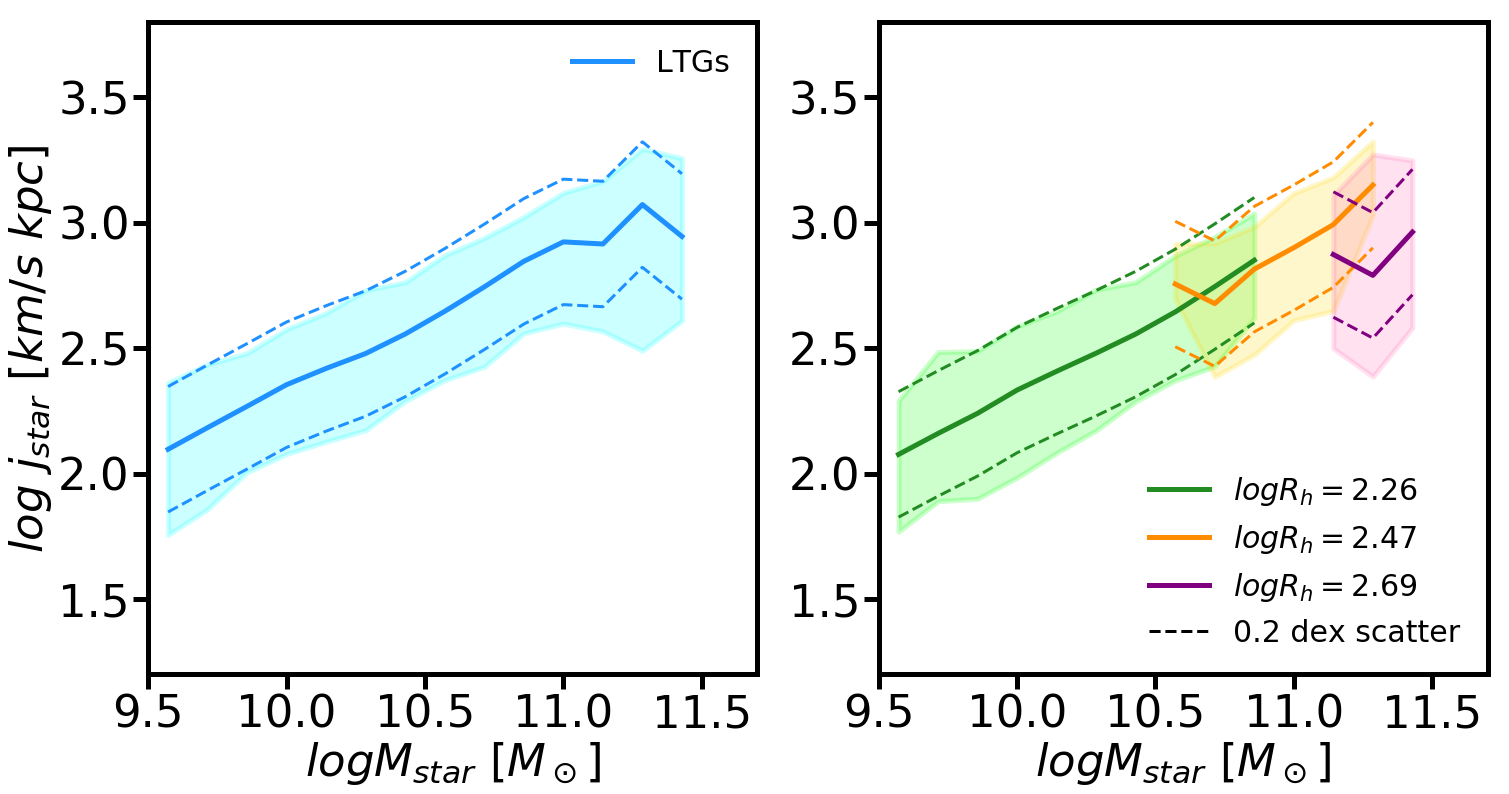

In [136]:

fig,ax = plt.subplots(1,2, figsize=(24,12))

colors = ['forestgreen','darkorange','purple']
facecolors = ['lime','gold','hotpink']

choices = ['jstar_1re','jstar_2re','jstar_all']
xlabels = ['$j_{star}(<1R_{e,3D}) \ [km/s \ kpc]$', '$j_{star}(<2R_{e,3D}) \ [km/s \ kpc]$',\
          '$log\ j_{star} \ [km/s \ kpc]$']
for i, this_ax in enumerate(ax.ravel()):

    #low,up = np.percentile(dfL[df.R200Parent>completeness][choices[i]].values, [0.5,99.5])
    jstarbins = np.linspace(9.5,11.5,15) #np.linspace(low,up,14)
    rhb = jstarbins[1:]-(jstarbins[1]-jstarbins[0])/2.
    rhalobins = np.linspace(2.15,2.8,4)
    
    if i==0:
        low_LTGs,med_LTGs,up_LTGs = make_percentiles(dfL['LogMass30'], dfL['jstar_2re'].values , 
                               jstarbins)
        this_ax.plot(rhb, med_LTGs, color='dodgerblue',lw=5, label='LTGs')
        this_ax.fill_between(rhb,low_LTGs,up_LTGs,color='cyan', alpha=0.2,lw=5)
        this_ax.plot(rhb, med_LTGs+0.25, color='dodgerblue', ls='--',lw=3)
        this_ax.plot(rhb, med_LTGs-0.25, color='dodgerblue', ls='--',lw=3)
        this_ax.set_ylabel(xlabels[2])
        this_ax.set_xticks([9.5,10,10.5,11.,11.5])
        this_ax.set_xlabel('$logM_{star} \ [M_\odot]$')
        
    else:
        for j,b in enumerate(rhalobins[1:]):
            dfL_ = dfL[(dfL['R200Parent']>rhalobins[j]) & (dfL['R200Parent']<rhalobins[j+1])]

            if len(dfL_)>10:
                low_LTGs,med_LTGs,up_LTGs = make_percentiles(dfL_['LogMass30'], dfL_['jstar_2re'].values , 
                                   jstarbins)


                meddh = (rhalobins[j]+rhalobins[j+1])/2
                this_ax.plot(rhb, med_LTGs, color=colors[j],lw=5, label='$logR_{h}=$'+str(np.round(meddh,2)))
                this_ax.fill_between(rhb,low_LTGs,up_LTGs,color=facecolors[j], alpha=0.2,lw=5)
                this_ax.plot(rhb, med_LTGs+0.25, color=colors[j], ls='--',lw=3)
                this_ax.plot(rhb, med_LTGs-0.25, color=colors[j], ls='--',lw=3)
                #this_ax.set_ylabel(xlabels[2])
                #this_ax.set_xlabel('$logM_{star} \ [M_\odot]$')    

                this_ax.set_xticks([9.5,10,10.5,11.,11.5])
                this_ax.set_xlabel('$logM_{star} \ [M_\odot]$')   

ax[1].plot(rhb, 2000*rhb-0.2, color='black', ls='--',lw=3, label='0.2 dex scatter')

for this_ax in ax.ravel():
    this_ax.set_ylim(1.2,3.8)
    this_ax.set_xlim(9.5,11.7)
#fig.text(0.93,0.75,'LTGs')
#fig.text(0.93,0.25,'ETGs')
#plt.subplots_adjust(left=0.05,right=0.9, wspace=0.28)
ax[1].legend(frameon=False, fontsize=30)
ax[0].legend(frameon=False, fontsize=30)

#plt.tight_layout(2replt.savefig('/home/lz1f17/Pictures/Paper/simulations/Mstar_jstar_allEstimates_LTGs.png')

In [288]:
bces.bces(y1=dfL['LogMass30'].values, y1err=1, y2=dfL['jstar_all'].values, y2err=1, cerr=np.cov(dfL['LogMass30'], dfL['jstar_all'].values))

(array([3.09113327e-02, 3.35949631e+01, 1.00114457e+00, 1.79994179e+00]),
 array([   2.32894381, -335.62537325,   -7.44027333,  -15.48331214]),
 array([0.00378852, 0.89946068, 0.00458593, 3.71665985]),
 array([ 0.04013785,  8.95946011,  0.0452053 , 37.41928186]),
 array([-1.50842062e-04, -8.05719940e+00, -2.06361474e-04, -1.39074740e+02]))

In [293]:
bces.bces?

Signature: bces.bces(y1, y1err, y2, y2err, cerr)
Docstring:
Does the entire regression calculation for 4 slopes:
OLS(Y|X), OLS(X|Y), bisector, orthogonal.
Fitting form: Y=AX+B.

Usage:

>>> a,b,aerr,berr,covab=bces(x,xerr,y,yerr,cov)

Output:

- a,b : best-fit parameters a,b of the linear regression 
- aerr,berr : the standard deviations in a,b
- covab : the covariance between a and b (e.g. for plotting confidence bands)

Arguments:

- x,y : data
- xerr,yerr: measurement errors affecting x and y
- cov : covariance between the measurement errors
(all are arrays)

v1 Mar 2012: ported from bces_regress.f. Added covariance output.
Rodrigo Nemmen, http://goo.gl/8S1Oo
        
File:      ~/anaconda3/lib/python3.6/site-packages/bces/bces.py
Type:      function


[2.98505053 3.17266913] [3.73485661 4.08012611]


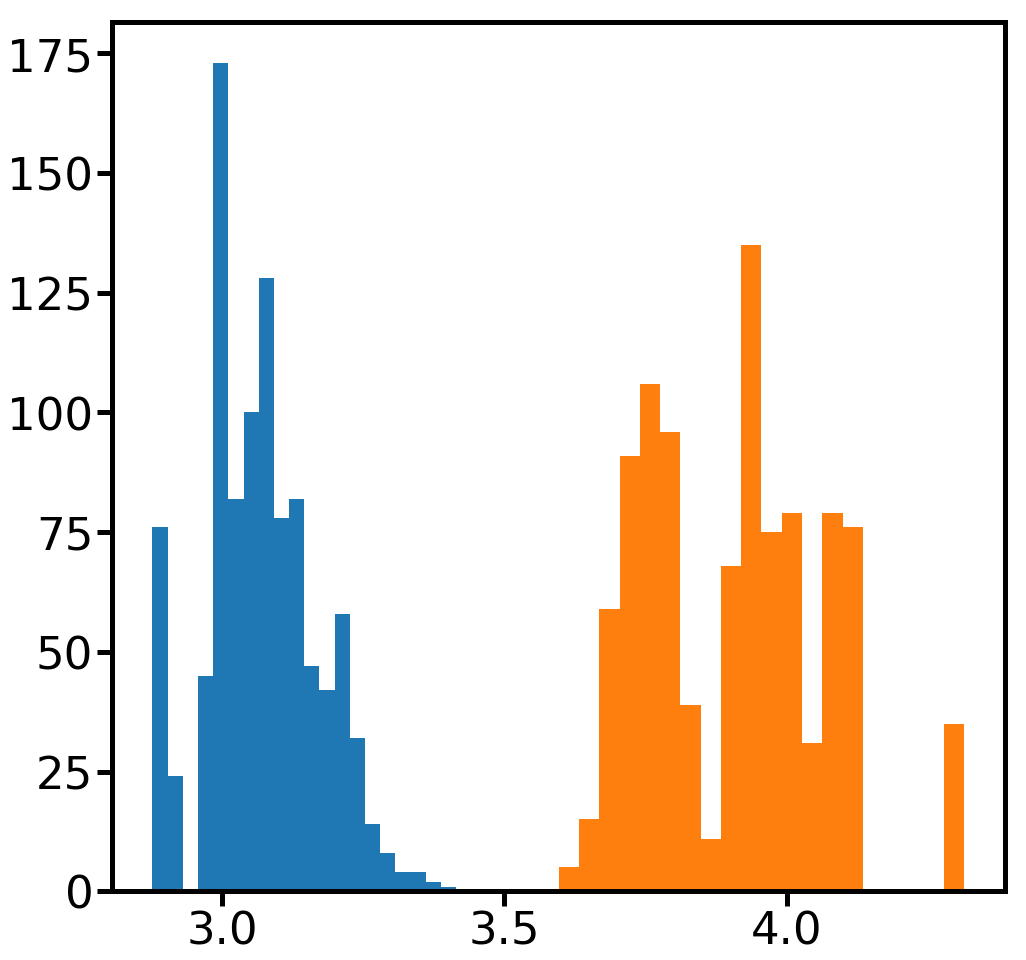

In [245]:
    rhalobins = np.linspace(completeness,2.8,4)
    
    for j,b in enumerate(rhalobins[1:]):
        dfL_ = dfL[(dfL['R200Parent']>rhalobins[j]) & (dfL['R200Parent']<rhalobins[j+1])]
        
        if len(dfL_)>10:
            low_LTGs,med_LTGs,up_LTGs = [],[],[]
            
            if j==2:
                with NumpyRNGContext(1):
                    resample = bootstrap(dfL_['jstar_all'].values, 1000)
                    for sample in resample:
                        L,M,U = make_percentiles(dfL_['LogMass30'], sample , 
                               jstarbins)
                        low_LTGs.append(L)
                        med_LTGs.append(M)
                        up_LTGs.append(U)
                print(np.percentile(np.array(low_LTGs).T[-2],[16,84]), np.percentile(np.array(up_LTGs).T[-2], [16,84]))
                plt.hist(np.array(low_LTGs).T[-2], bins=20)
                plt.hist(np.array(up_LTGs).T[-2], bins=20)

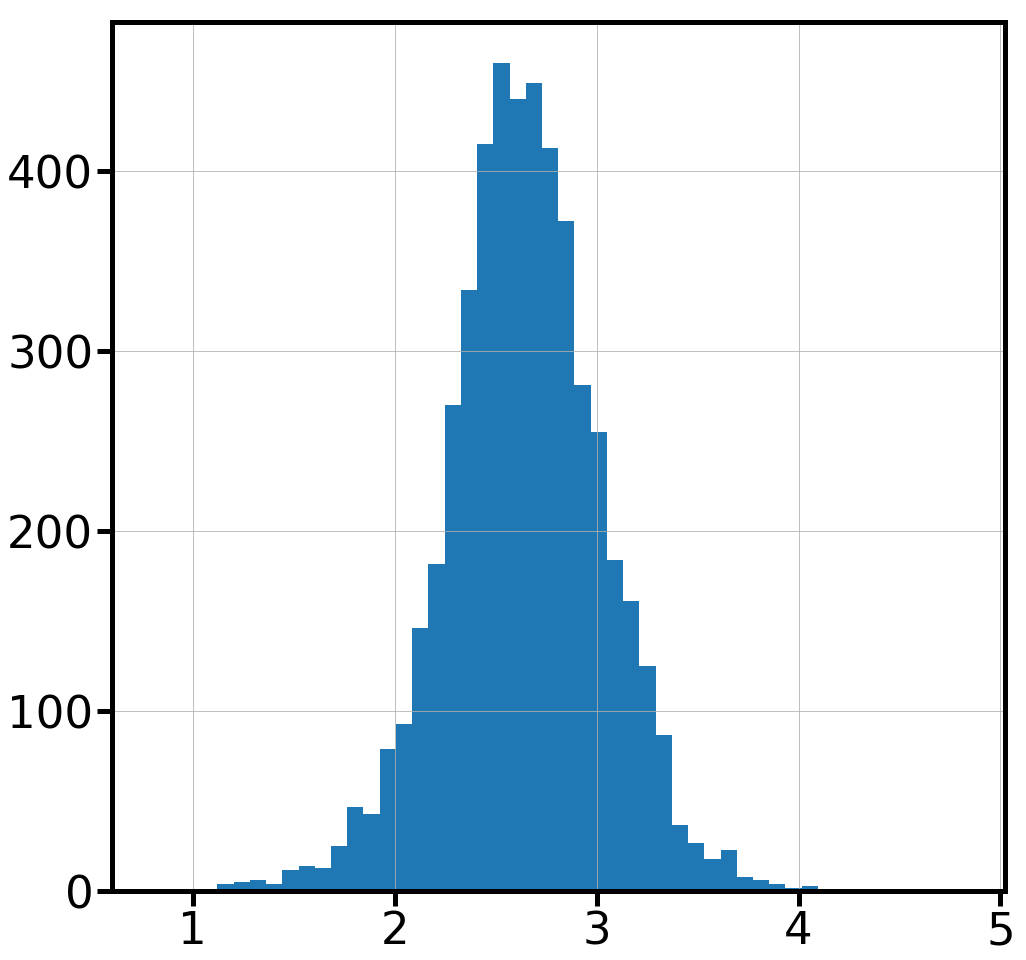

In [23]:
dfL.jstar_all.hist(bins=50)

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import colorcet as cc
from mpl_toolkits.axes_grid1 import make_axes_locatable

def multiline(xs, ys, c, bubu=None, ax=None, **kwargs):
    """Plot lines with different colorings

    Parameters
    ----------
    xs : iterable container of x coordinates
    ys : iterable container of y coordinates
    c : iterable container of numbers mapped to colormap
    ax (optional): Axes to plot on.
    kwargs (optional): passed to LineCollection

    Notes:
        len(xs) == len(ys) == len(c) is the number of line segments
        len(xs[i]) == len(ys[i]) is the number of points for each line (indexed by i)

    Returns
    -------
    lc : LineCollection instance.
    """

    # find axes
    ax = plt.gca() if ax is None else ax

    # create LineCollection
    segments = np.array([np.column_stack([x, y]) for x, y in zip(xs, ys)])
    lc = LineCollection(segments, **kwargs)

    # set coloring of line segments
    #    Note: I get an error if I pass c as a list here... not sure why.
    lc.set_array(np.asarray(c))

    # add lines to axes and rescale 
    #    Note: adding a collection doesn't autoscalee xlim/ylim
    ax.add_collection(lc)
    ax.autoscale()
    ax.set_title(bubu
                )
    return lc

In [45]:
jstar['sub'] = jstar['sJ_star_2re']-jstar['sJ_star_all']
dfL = df.query('P_Late_comp>0.5')# & P_Sab_comp<0.5')
dfE = df.query('P_Late_comp<0.5 ')
dfEll = df[(1-df.P_Late_comp)*(1-df.P_S0_comp)>0.5]
dfS0 = df[(1-df.P_Late_comp)*(df.P_S0_comp)>0.5]

dfL = dfL.rename(columns={'sJ_star_2re':'jstar_2re', 'sJ_star_all':'jstar_all','sJ_star_1re':'jstar_1re'})
dfEll = dfEll.rename(columns={'sJ_star_2re':'jstar_2re', 'sJ_star_all':'jstar_all','sJ_star_1re':'jstar_1re'})
dfS0 = dfS0.rename(columns={'sJ_star_2re':'jstar_2re', 'sJ_star_all':'jstar_all','sJ_star_1re':'jstar_1re'})

No handles with labels found to put in legend.


9.5 10.0
10.0 10.5
10.5 11.0
11.0 11.5


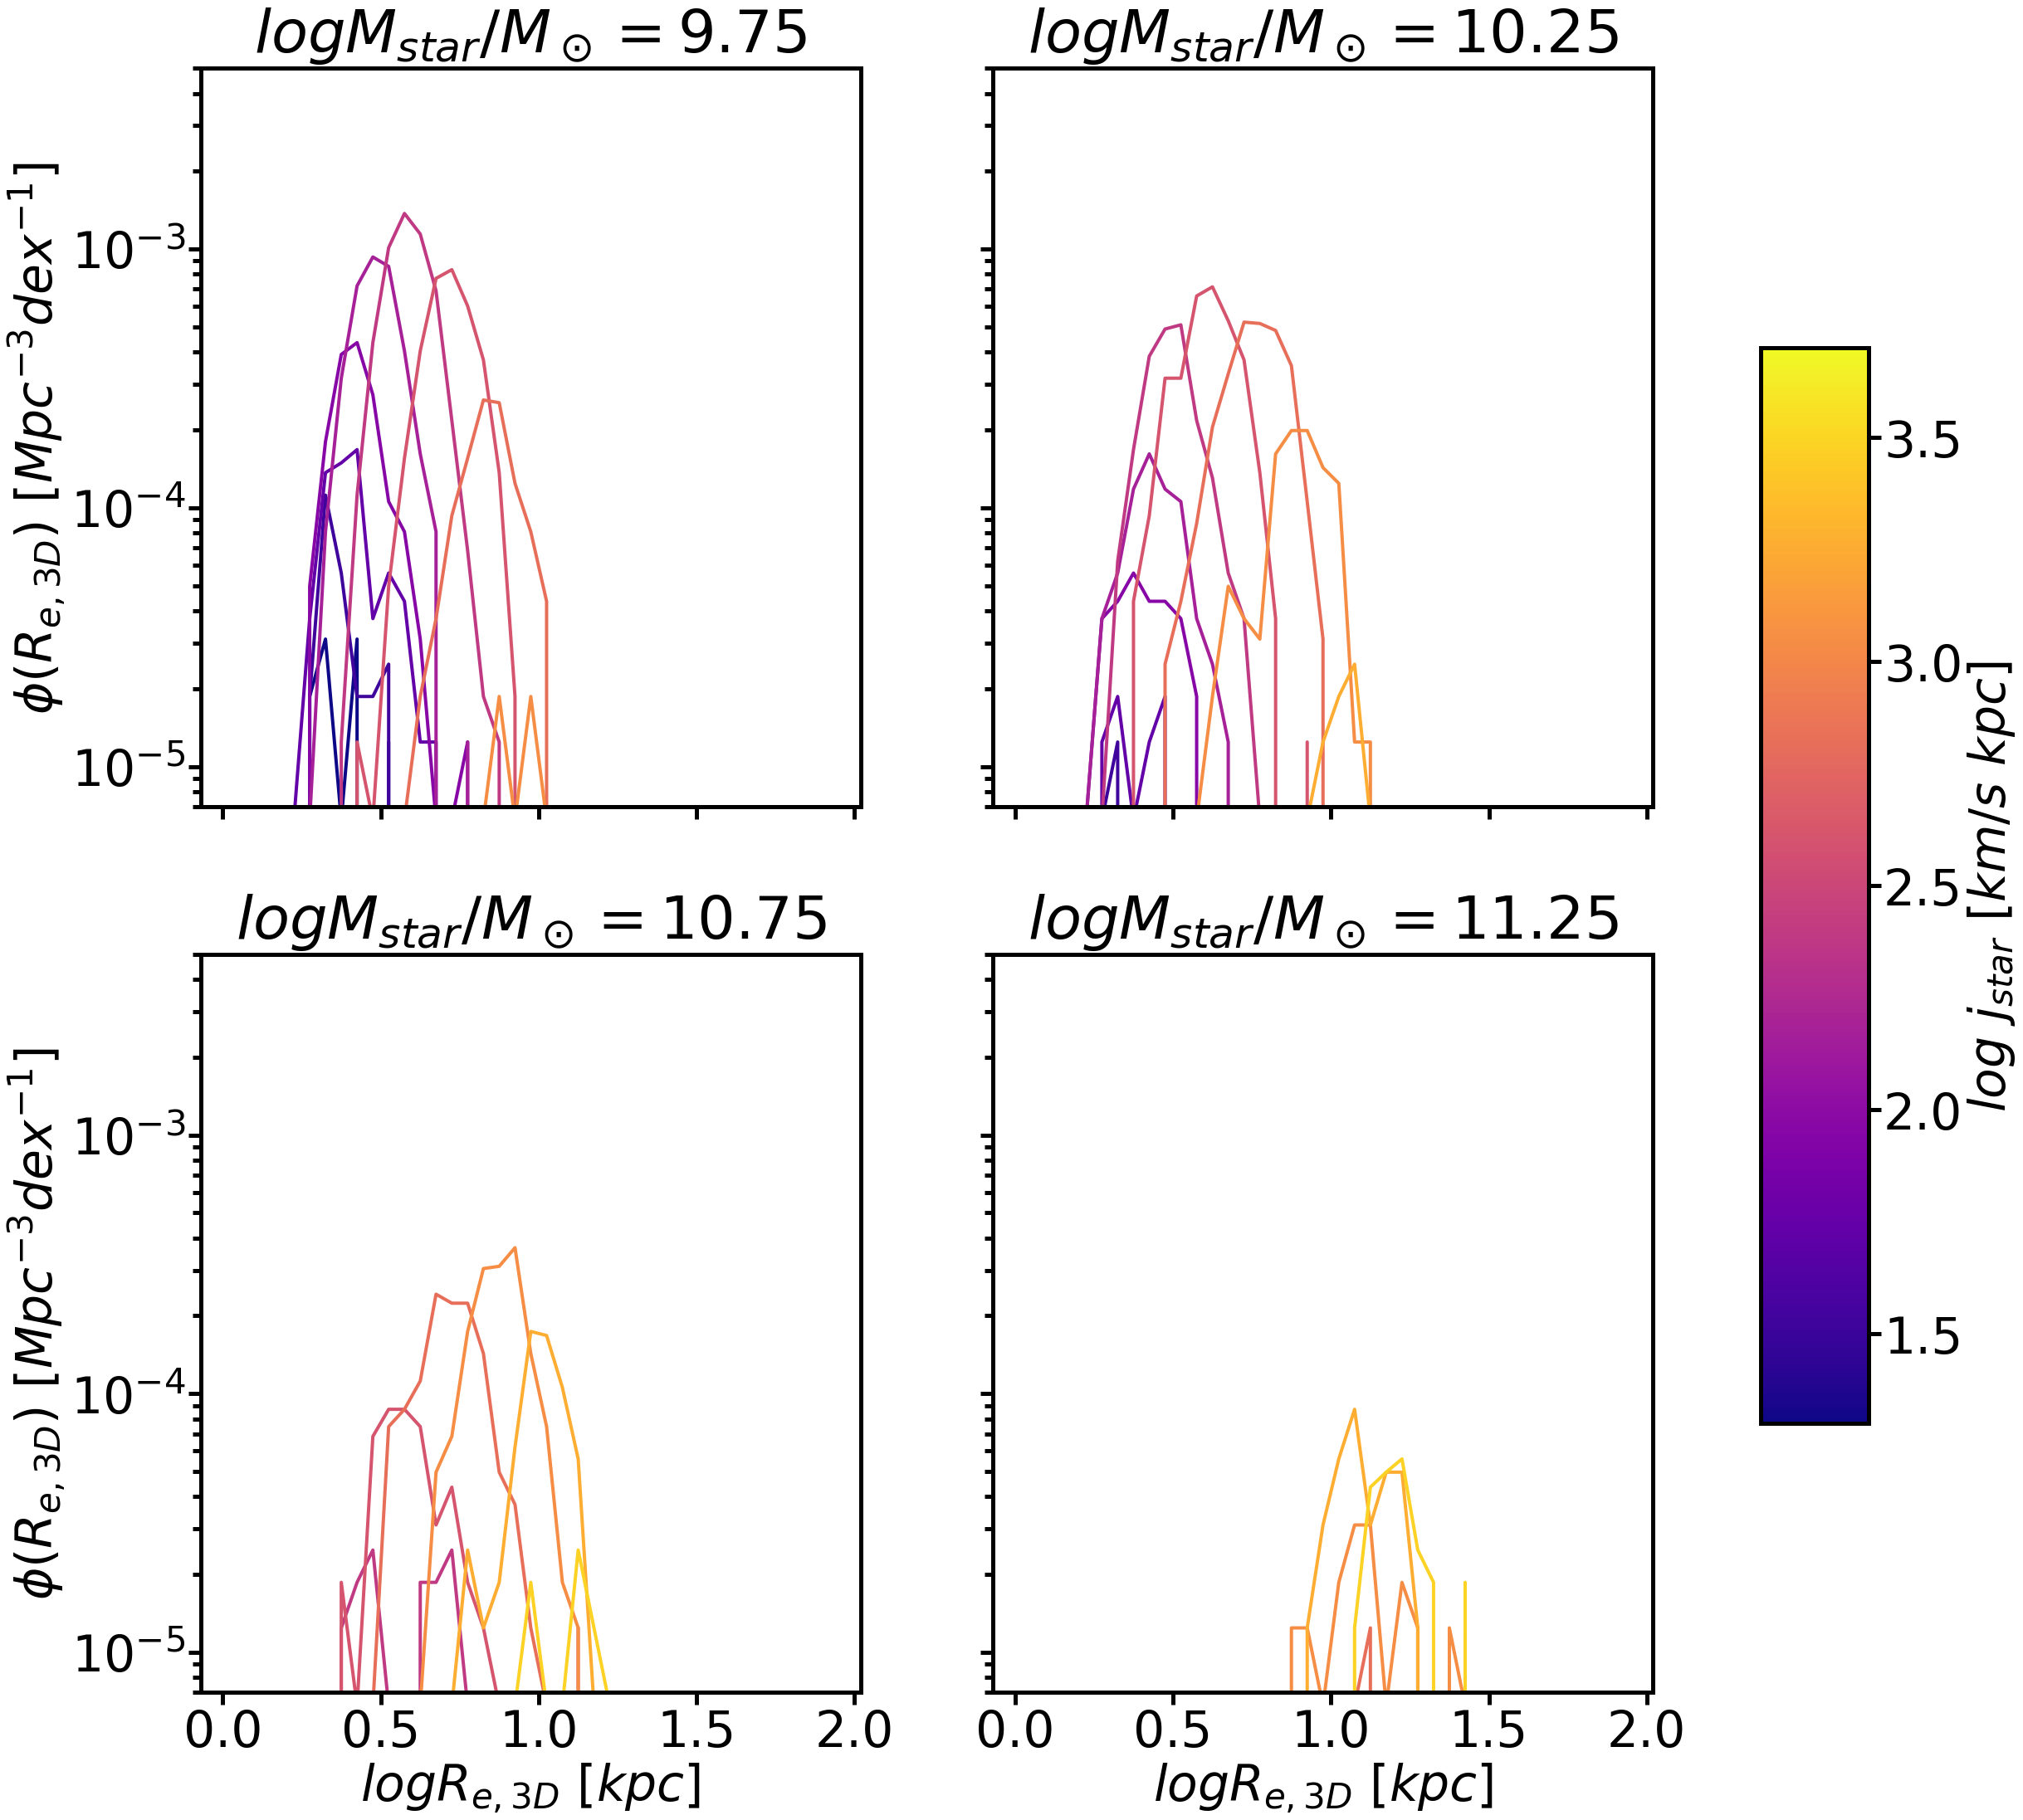

In [23]:
rewidth = 0.05
jstarbins = np.linspace(1.3,3.7,12)
mstarbins = np.linspace(9.5,11.5,5)
plt.rcParams['font.size']= 60
rebins = np.arange(0,2,rewidth)
rr = rebins[1:]-rewidth/2.

colors = ['dodgerblue','darkorange','forestgreen','magenta','firebrick','limegreen','gray','gold','navy','deeppink']
# cecolors = ['cyan','gold',]
fig, ax = plt.subplots(2,2, sharex=True, sharey=True, figsize=(36,36))
Vol = (100/cosmol.h)**3


for j,this_ax in enumerate(ax.ravel()):
    
    print(mstarbins[j],mstarbins[j+1])
    dfL_ = dfL[(dfL['LogMass30']>mstarbins[j]) & (dfL['LogMass30']<mstarbins[j+1])]

    a = []
    b =[]
    j =[]
    for i,j_star in enumerate(jstarbins[1:]):

        dfL_1 = dfL_[(dfL_['jstar_all']>jstarbins[i]) & (dfL_['jstar_all']<jstarbins[i+1])]
        a.append(np.histogram(dfL_1['Re'].values, bins=rebins)[0]/rewidth/Vol)
        b.append(rebins[1:] -rewidth/2.)
        j.append(jstarbins)
        
    yint = np.arange(0, np.shape(a)[0]*10, 10)
    lc = multiline(b,a, c=jstarbins,cmap=mpl.cm.plasma, ax=this_ax, lw=4)
    
    
        
    
        #this_ax.plot(rhb, hist/rewidth/Vol, color=colors[i],lw=5, label=r'$logj_{star}$='+str(np.round(medd,2)) )
        #this_ax.fill_between(rhb,low_LTGs,up_LTGs, color=colors[j], alpha=0.2,lw=5)
        #plt.plot(rhb, med_ETGs, color='firebrick' ,lw=5,label='P_Late<0.5')
        #plt.fill_between(rhb,low_ETGs,up_ETGs, color='salmon', alpha=0.4,lw=5)
    #medd = (mstarbins[j]+mstarbins[j+1])/2
    #this_ax.set_title(r'$logM_{star}/M_\odot=$'+str(np.round(medd,2)))
    this_ax.set_yscale('log')
    this_ax.set_ylim(7.e-6,5.e-3)
    
    ax[0][0].set_ylabel('$\phi(R_{e,3D}) \ [Mpc^{-3}dex^{-1}$]')
    ax[1][0].set_ylabel('$\phi(R_{e,3D}) \ [Mpc^{-3}dex^{-1}$]')
   # ax[0].set_xlabel('$logR_{e,3D} \ [kpc]$')
    for k in range(2):
        ax[1][k].set_xlabel('$logR_{e,3D} \ [kpc]$')
    
plt.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7], aspect=10)
cbar = fig.colorbar(lc, cax=cbar_ax, orientation='vertical')
cbar.set_label('$log \ j_{star} \ [km/s \ kpc] $')

for i,(this_ax,m) in enumerate(zip(ax.ravel(),mstarbins)):
    medd = (mstarbins[i]+mstarbins[i+1])/2
    this_ax.set_title(r'$logM_{star}/M_\odot=$'+str(np.round(medd,2)))
    this_ax.set_xticks([0,0.5,1,1.5,2])
ax[1][1].legend(fontsize=30,frameon=False)    
plt.savefig('/home/lz1f17/Pictures/Paper/simulations/sizefunct_jstarbins_all.png')
    #plt.close()
    

14
14


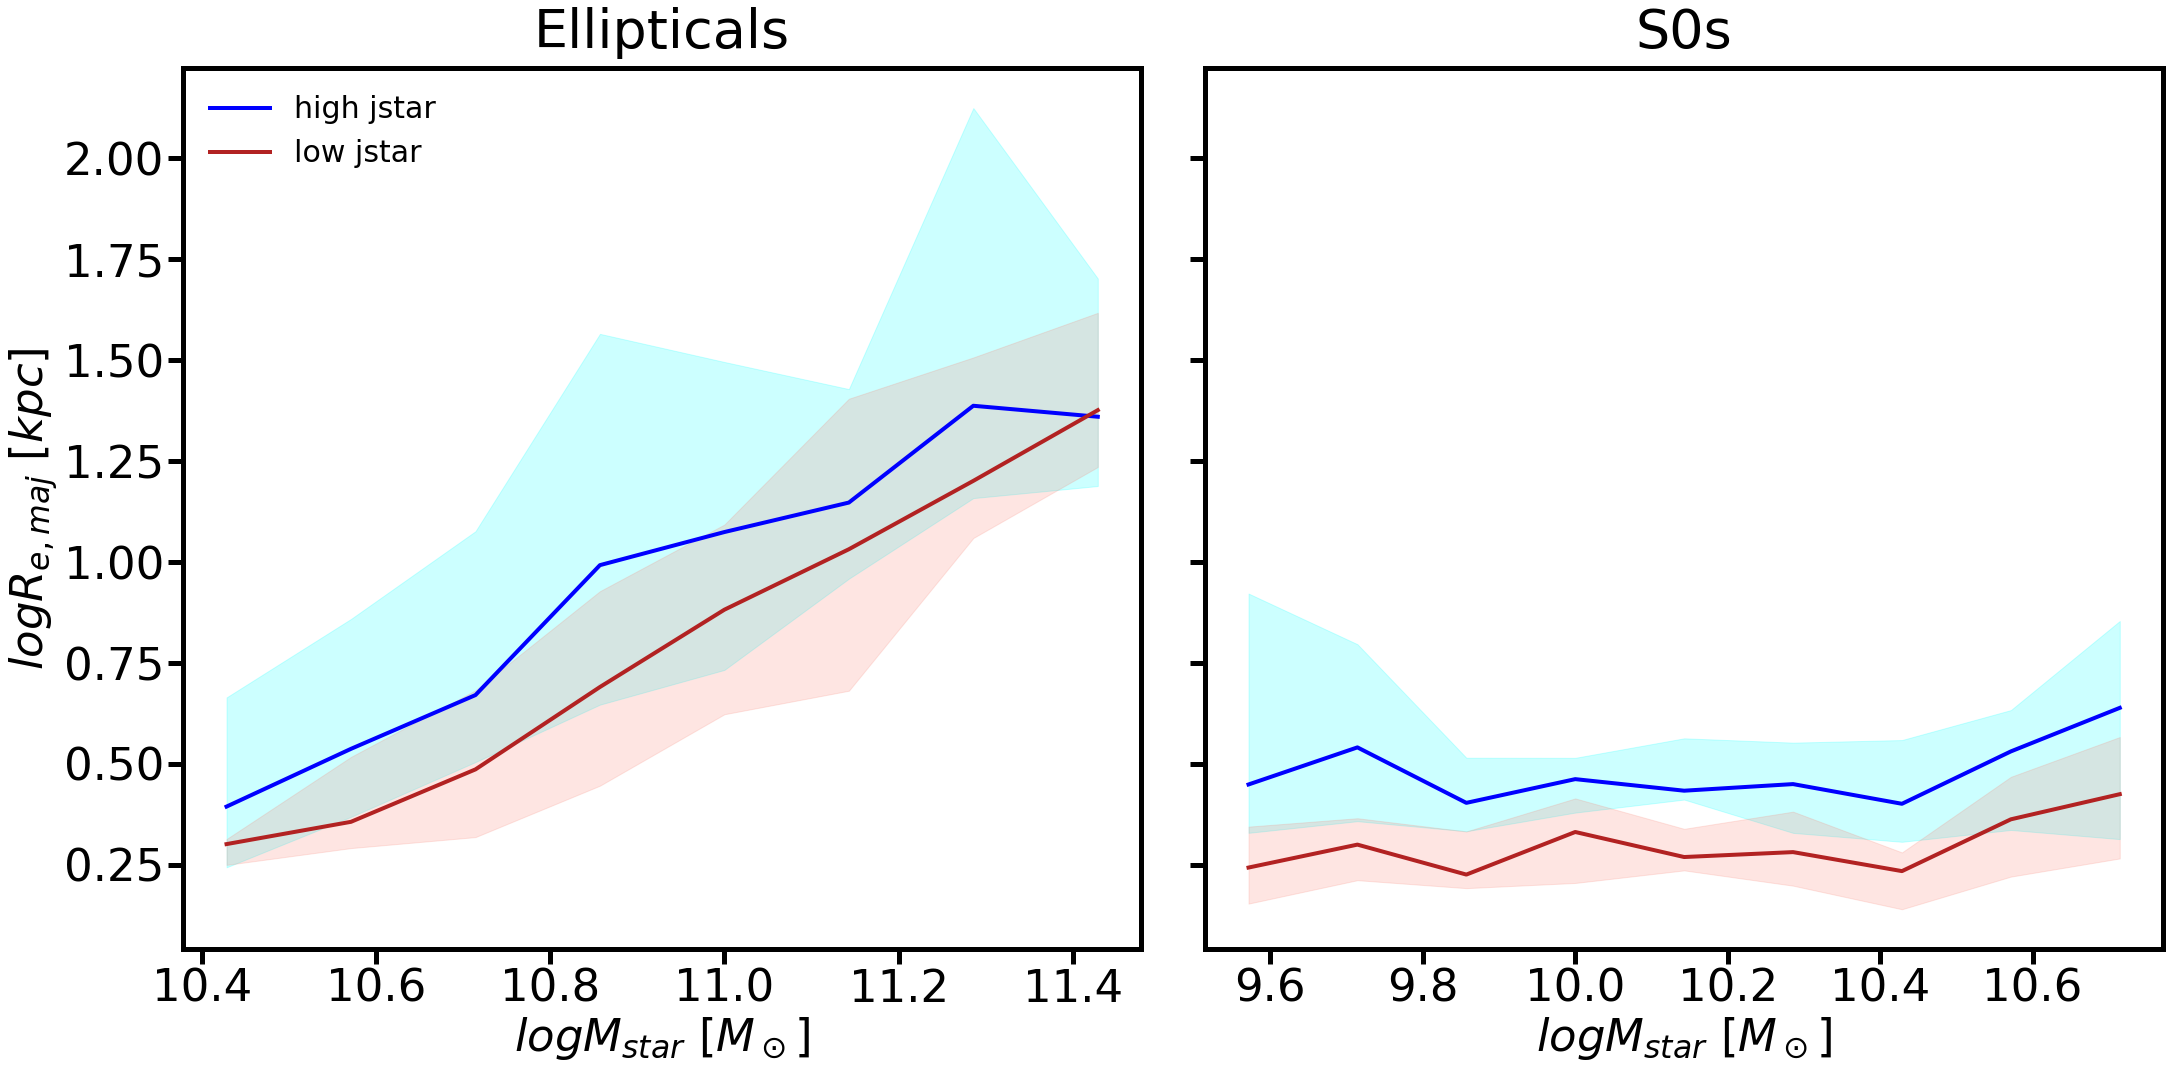

In [58]:


colors = ['forestgreen','darkorange','purple']
facecolors = ['lime','gold','hotpink']

choices = ['jstar_1re','jstar_2re','jstar_all']
xlabels = ['$j_{star}(<1R_{e,3D}) \ [km/s \ kpc]$', '$j_{star}(<2R_{e,3D}) \ [km/s \ kpc]$',\
          '$log\ j_{star} \ [km/s \ kpc]$']

fig,(ax1,ax2) = plt.subplots(1,2, sharey=True, figsize=(32,16))
    #low,up = np.percentile(dfL[df.R200Parent>completeness][choices[i]].values, [0.5,99.5])
Mstarbins = np.linspace(9.5,11.5,15) #np.linspace(low,up,14)
Mb = Mstarbins[1:]-(Mstarbins[1]-Mstarbins[0])/2.
rhalobins = np.linspace(2.15,2.8,4)
    
low_LTGs,med_LTGs,up_LTGs = make_percentiles(dfEll['LogMass30'], dfEll['jstar_all'].values , 
                       Mstarbins)
        
up_low_ = []
med_low_ = [] 
low_low_ = [] 
up_high_ = []
med_high_ = [] 
low_high_ = [] 
for j,b in enumerate(Mstarbins[1:]):
        dfL_ = dfEll[(dfEll['LogMass30']>=Mstarbins[j]) & (dfEll['LogMass30']<Mstarbins[j+1])]

        if len(dfL_>15):
            dfL_low = dfL_[dfL_['jstar_all']<=med_LTGs[j]]
            dfL_high = dfL_[dfL_['jstar_all']>med_LTGs[j]]
            if len(dfL_low)>5:
                low_low,med_low,up_low = np.percentile(dfL_low['sersic_rhalf'],[16,50,84])   # size of galaxies with jstar lower than the mean
                up_low_.append(up_low)
                med_low_.append(med_low)
                low_low_.append(low_low)
            else:
                up_low_.append(np.nan)
                med_low_.append(np.nan)
                low_low_.append(np.nan)                
            if len(dfL_high)>5:
                low_high,med_high,up_high = np.percentile(dfL_high['sersic_rhalf'],[16,50,84])   # size of galaxies with jstar higher than the mean
                up_high_.append(up_high)
                med_high_.append(med_high)
                low_high_.append(low_high)
            else:
                up_high_.append(np.nan)
                med_high_.append(np.nan)
                low_high_.append(np.nan) 
        else:
            up_high_.append(np.nan)
            med_high_.append(np.nan)
            low_high_.append(np.nan) 
            up_low_.append(np.nan)
            med_low_.append(np.nan)
            low_low_.append(np.nan)  
            
ax1.plot(Mb, med_high_, color='blue', lw=4, label='high jstar')
ax1.fill_between(Mb,low_high_, up_high_, color='cyan', alpha=0.2)
ax1.plot(Mb, med_low_, color='firebrick', lw=4, label='low jstar')
ax1.fill_between(Mb,low_low_, up_low_, color='salmon', alpha=0.2)
ax1.legend(frameon=False, fontsize=30, loc='upper left')
ax1.set_ylabel('$log R_{e,maj} \ [kpc]$')
ax1.set_xlabel('$log M_{star} \ [M_\odot]$')
ax1.set_title('Ellipticals')
print(len(med_high_))



low_LTGs,med_LTGs,up_LTGs = make_percentiles(dfS0['LogMass30'], dfS0['jstar_all'].values , 
                       Mstarbins)
up_low_ = []
med_low_ = [] 
low_low_ = [] 
up_high_ = []
med_high_ = [] 
low_high_ = [] 
for j,b in enumerate(Mstarbins[1:]):
        dfL_ = dfS0[(dfS0['LogMass30']>=Mstarbins[j]) & (dfS0['LogMass30']<Mstarbins[j+1])]

        if len(dfL_>15):
            dfL_low = dfL_[dfL_['jstar_all']<=med_LTGs[j]]
            dfL_high = dfL_[dfL_['jstar_all']>med_LTGs[j]]
            if len(dfL_low)>5:
                low_low,med_low,up_low = np.percentile(dfL_low['sersic_rhalf'],[16,50,84])   # size of galaxies with jstar lower than the mean
                up_low_.append(up_low)
                med_low_.append(med_low)
                low_low_.append(low_low)
            else:
                up_low_.append(np.nan)
                med_low_.append(np.nan)
                low_low_.append(np.nan)                
            if len(dfL_high)>5:
                low_high,med_high,up_high = np.percentile(dfL_high['sersic_rhalf'],[16,50,84])   # size of galaxies with jstar higher than the mean
                up_high_.append(up_high)
                med_high_.append(med_high)
                low_high_.append(low_high)
            else:
                up_high_.append(np.nan)
                med_high_.append(np.nan)
                low_high_.append(np.nan) 
        else:
            up_high_.append(np.nan)
            med_high_.append(np.nan)
            low_high_.append(np.nan) 
            up_low_.append(np.nan)
            med_low_.append(np.nan)
            low_low_.append(np.nan)  
                
print(len(med_high_))
ax2.plot(Mb, med_high_, color='blue', lw=4, label='high jstar')
ax2.fill_between(Mb,low_high_, up_high_, color='cyan', alpha=0.2)
ax2.plot(Mb, med_low_, color='firebrick', lw=4, label='low jstar')
ax2.fill_between(Mb,low_low_, up_low_, color='salmon', alpha=0.2)
#ax2.legend()
#ax2.ylabel('$log R_{e,maj} \ [kpc]$')
ax2.set_xlabel('$log M_{star} \ [M_\odot]$')
ax2.set_title('S0s')
plt.tight_layout()
plt.savefig('/home/lz1f17/Pictures/Paper/simulations/sizemass_Ell_S0_jstar.png')

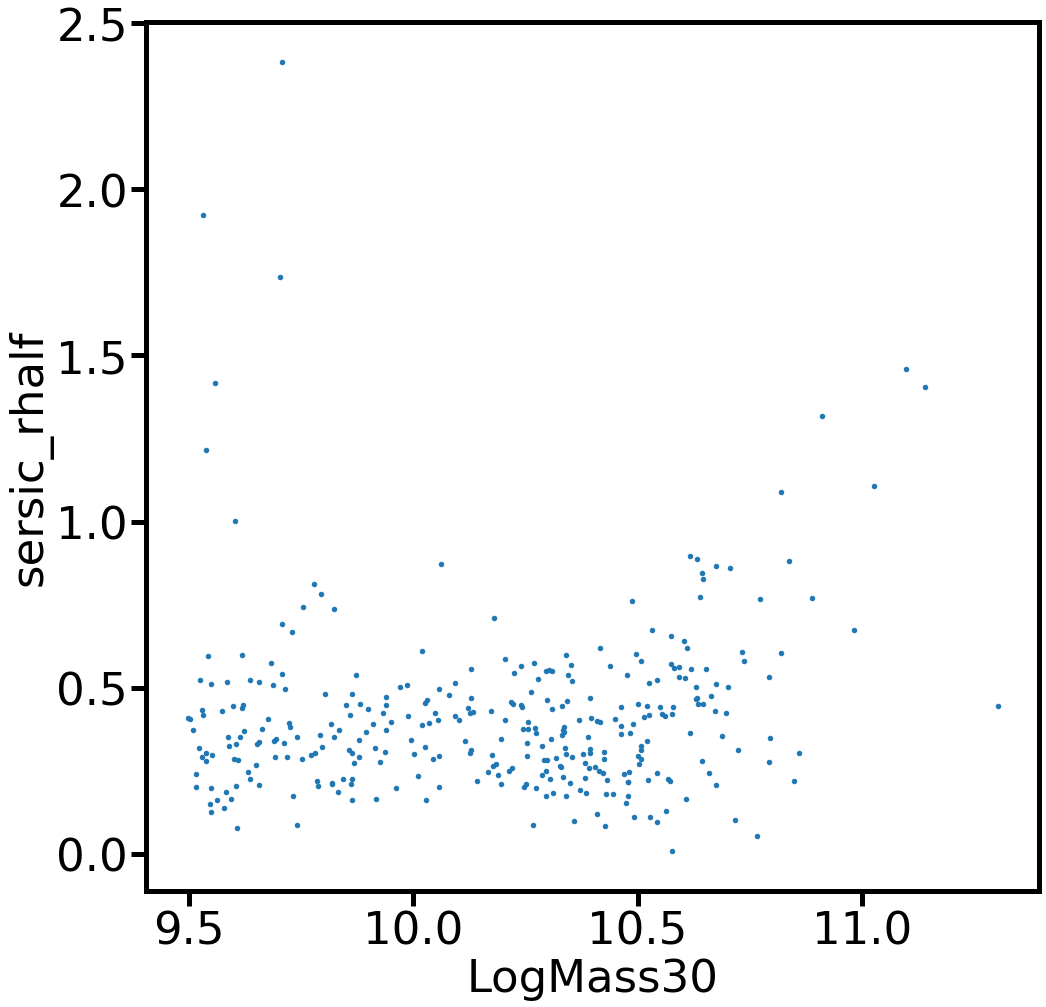

In [55]:
dfS0.plot.scatter('LogMass30', 'sersic_rhalf')

In [ ]:
rewidth = 0.1
jstarbins = np.linspace(1.3,3.6,10)
mstarbins = np.linspace(9.5,11.,5)

rebins = np.arange(0,2,rewidth)
rr = rebins[1:]-rewidth/2.

colors = ['dodgerblue','darkorange','forestgreen','magenta','firebrick','limegreen','gray','gold','navy','deeppink']
# cecolors = ['cyan','gold',]
fig, ax = plt.subplots(2,2, sharex=True, sharey=True, figsize=(24,24))
Vol = (100/cosmol.h)**3

for j,this_ax in enumerate(ax.ravel()):
    
    print(mstarbins[j],mstarbins[j+1])
    dfL_ = dfL[(dfL['LogMass30']>mstarbins[j]) & (dfL['LogMass30']<mstarbins[j+1])]

    for i,j_star in enumerate(jstarbins[1:]):

        dfL_1 = dfL_[(dfL_['jstar_all']>jstarbins[i]) & (dfL_['jstar_all']<jstarbins[i+1])]
        hist = np.histogram(dfL_1['Re'].values, bins=rebins)[0]
        rhb = rebins[1:] -rewidth/2.
        medd = (jstarbins[i]+jstarbins[i+1])/2
        this_ax.plot(rhb, hist/rewidth/Vol, color=colors[i],lw=5, label=r'$logj_{star}$='+str(np.round(medd,2)) )
        #this_ax.fill_between(rhb,low_LTGs,up_LTGs, color=colors[j], alpha=0.2,lw=5)
        #plt.plot(rhb, med_ETGs, color='firebrick' ,lw=5,label='P_Late<0.5')
        #plt.fill_between(rhb,low_ETGs,up_ETGs, color='salmon', alpha=0.4,lw=5)
    medd = (mstarbins[j]+mstarbins[j+1])/2
    this_ax.set_title(r'$logM_{star}/M_\odot=$'+str(np.round(medd,2)))
    this_ax.set_yscale('log')
    #plt.plot(rhb, med_ETGs-0.2, color='firebrick', ls='--',lw=3)

    

        

#plt.axvline(completeness, color='gray', label='completeness limit')

        
    
    ax[0][0].set_ylabel('$\phi(R_{eff,3D}) \ [Mpc^{-3}dex^{-1}$')
    ax[1][0].set_ylabel('$\phi(R_{eff,3D}) \ [Mpc^{-3}dex^{-1}$')

    for k in range(2):
        ax[1][k].set_xlabel('$R_{eff,3D} \ [kpc]$')
    
    
#for this_ax in ax.ravel():
#    this_ax.set_ylim(1,4)
#    this_ax.set_xlim(0,2.)
ax[1][1].legend(fontsize=30,frameon=False)    
plt.savefig('/home/lz1f17/Pictures/Paper/simulations/sizefunct_jstarbins_all.png')
    #plt.close()

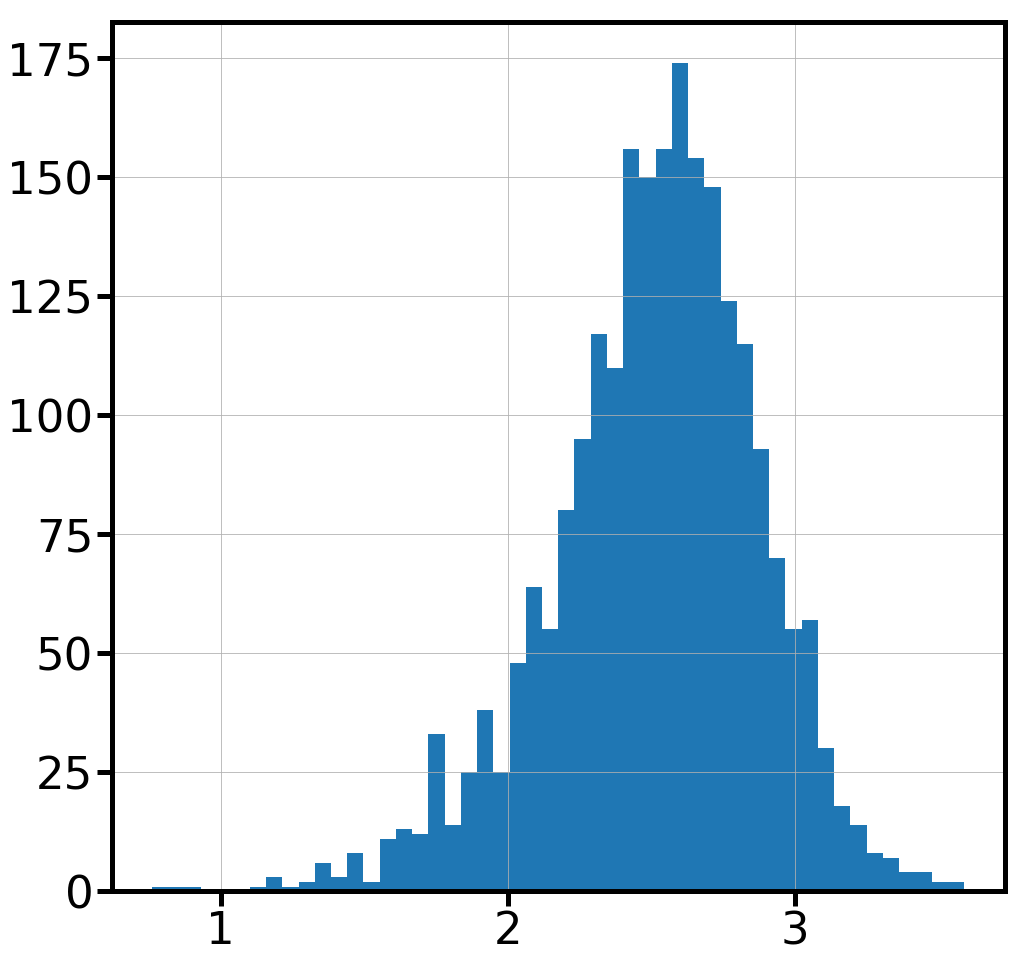

In [111]:
dfL.jstar_2re[df.R200Parent>completeness].hist(bins=50)

In [116]:
np.percentile(dfL.jstar_all[df.R200Parent>completeness].values, [0.5,99.5])

array([1.82179872, 3.85998899])

# Size functions in bins of R200

2.15 2.3375
2.3375 2.525
2.525 2.7125
2.7125 2.9


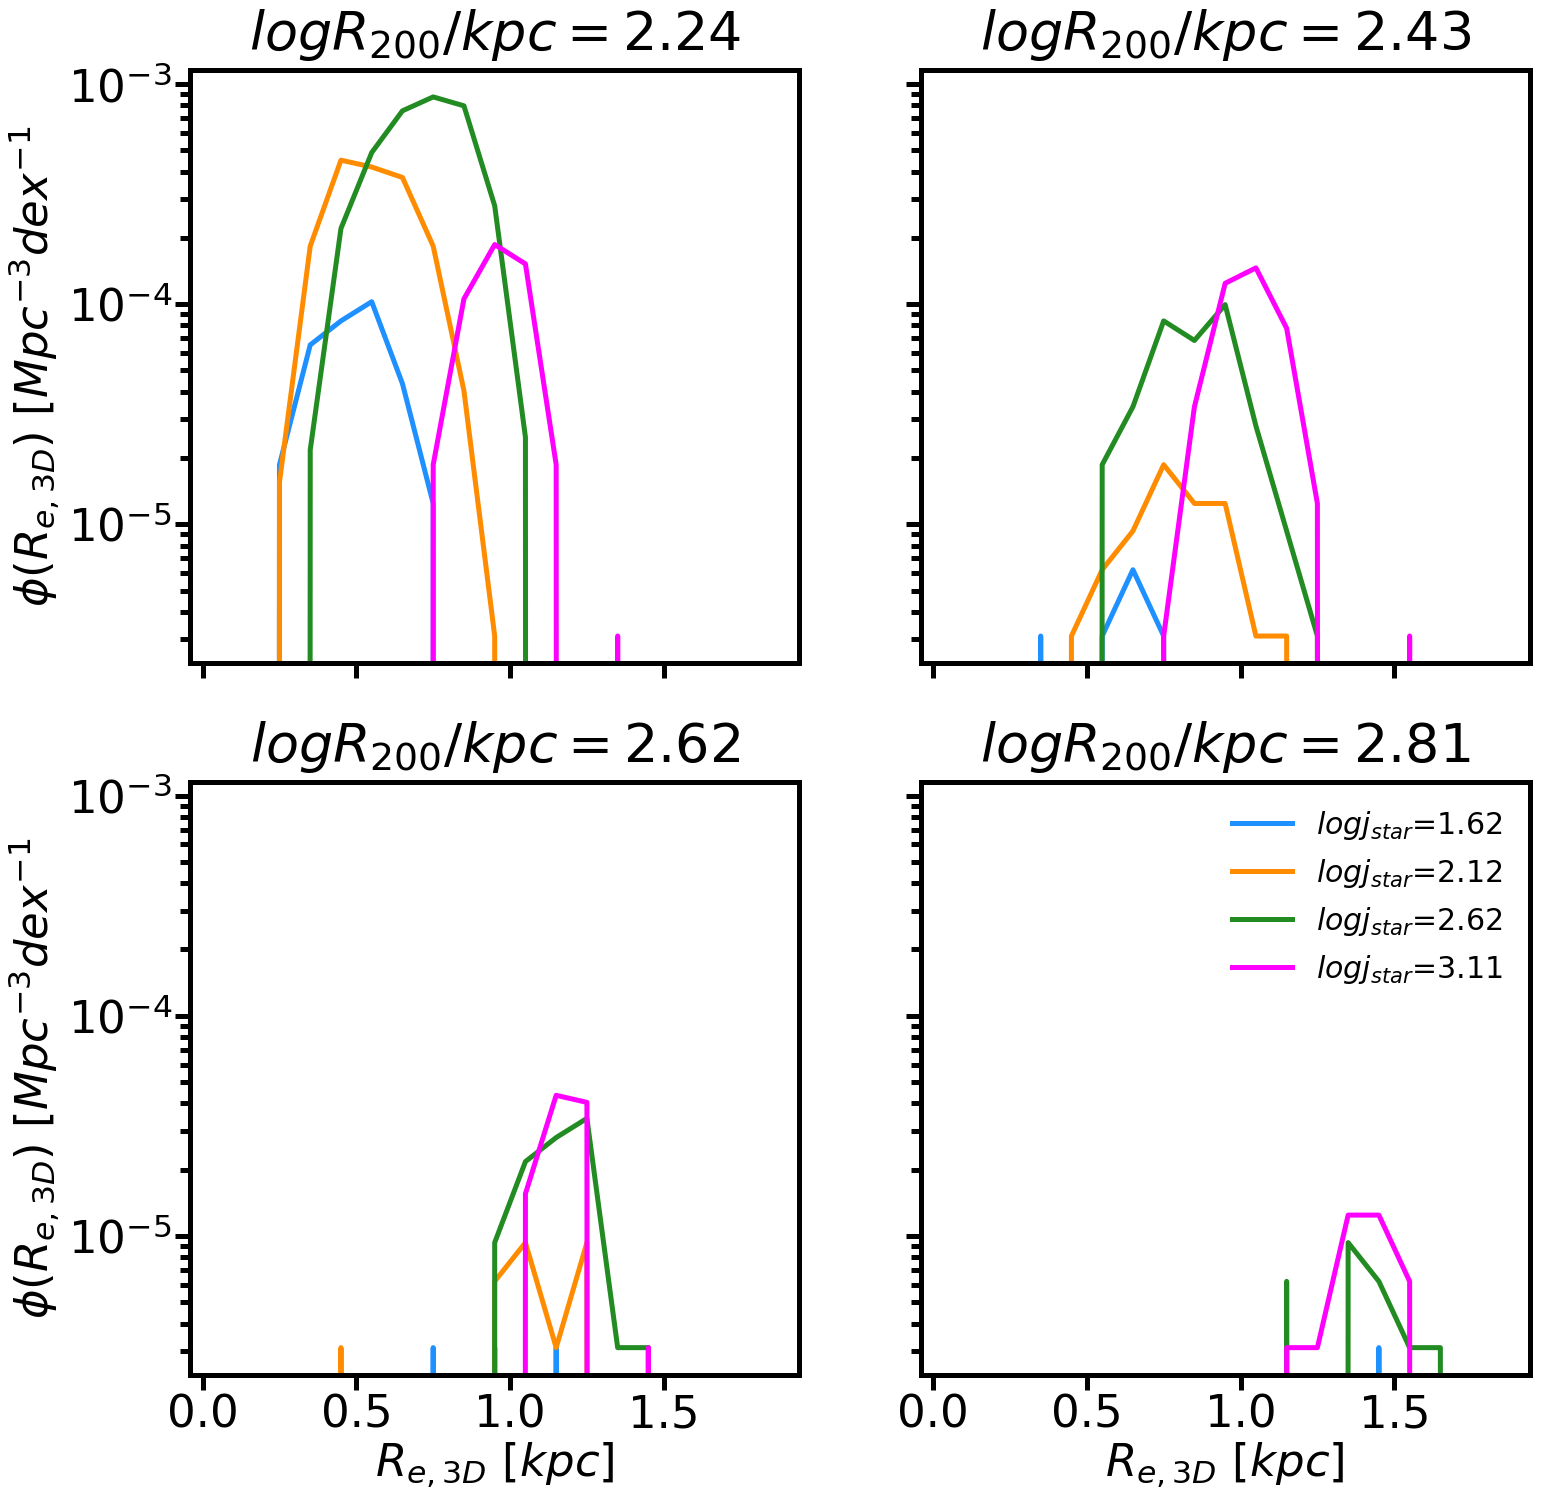

In [120]:
rewidth = 0.1
low,up = np.percentile(dfL.jstar_2re[df.R200Parent>completeness].values, [0.5,99.5])
jstarbins = np.linspace(low,up,5)
halobins = np.linspace(2.15,2.9,5)
dfL.R200Parent
rebins = np.arange(0,2,rewidth)
rr = rebins[1:]-rewidth/2.

colors = ['dodgerblue','darkorange','forestgreen','magenta','firebrick']
# cecolors = ['cyan','gold',]
fig, ax = plt.subplots(2,2, sharex=True, sharey=True, figsize=(24,24))
Vol = (100/cosmol.h)**3

for j,this_ax in enumerate(ax.ravel()):
    
    print(halobins[j],halobins[j+1])
    dfL_ = dfL[(dfL['R200Parent']>halobins[j]) & (dfL['R200Parent']<halobins[j+1])]

    for i,j_star in enumerate(jstarbins[1:]):

        dfL_1 = dfL_[(dfL_['jstar_2re']>jstarbins[i]) & (dfL_['jstar_2re']<jstarbins[i+1])]
        hist = np.histogram(dfL_1['Re'].values, bins=rebins)[0]
        rhb = rebins[1:] -rewidth/2.
        medd = (jstarbins[i]+jstarbins[i+1])/2
        this_ax.plot(rhb, hist/rewidth/Vol, color=colors[i],lw=5, label=r'$logj_{star}$='+str(np.round(medd,2)) )
        #this_ax.fill_between(rhb,low_LTGs,up_LTGs, color=colors[j], alpha=0.2,lw=5)
        #plt.plot(rhb, med_ETGs, color='firebrick' ,lw=5,label='P_Late<0.5')
        #plt.fill_between(rhb,low_ETGs,up_ETGs, color='salmon', alpha=0.4,lw=5)
    medd = (halobins[j]+halobins[j+1])/2
    this_ax.set_title(r'$logR_{200}/kpc=$'+str(np.round(medd,2)))
    this_ax.set_yscale('log')
    #plt.plot(rhb, med_ETGs-0.2, color='firebrick', ls='--',lw=3)

    

        

#plt.axvline(completeness, color='gray', label='completeness limit')

        
    
    ax[0][0].set_ylabel('$\phi(R_{e,3D}) \ [Mpc^{-3}dex^{-1}$')
    ax[1][0].set_ylabel('$\phi(R_{e,3D}) \ [Mpc^{-3}dex^{-1}$')

    for k in range(2):
        ax[1][k].set_xlabel('$R_{e,3D} \ [kpc]$')
    
    
#for this_ax in ax.ravel():
#    this_ax.set_ylim(1.e-8,1.e-2)
#    this_ax.set_xlim(0,2.)
ax[1][1].legend(fontsize=30,frameon=False)    
plt.savefig('/home/lz1f17/Pictures/Paper/simulations/sizefunct_rhalo_jstarbins_2re.png')
    #plt.close()
    

# Stellar mass halo mass

In [38]:
dfL.SatSM

0        9.735087
2        9.551648
3        9.678596
4       10.128549
5       10.074846
          ...    
7215     9.415175
7216     9.308417
7218     9.793956
7220     9.404319
7221     9.399238
Name: SatSM, Length: 5053, dtype: float64

setting halo mass function...
selecting halos from the catalogs..


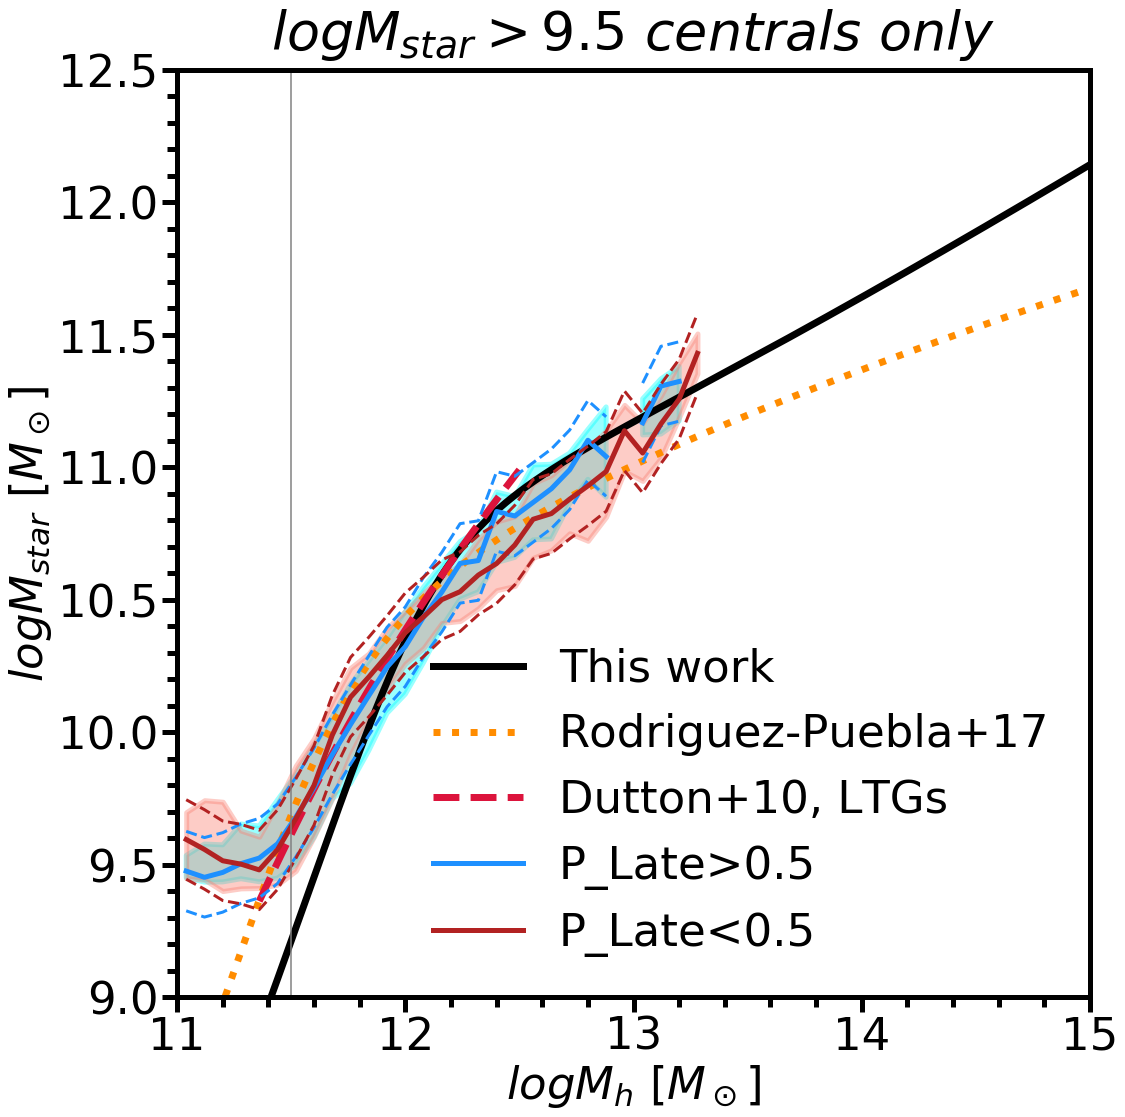

In [44]:
import numpy as np
import pandas as pd
#from colossus.halo import *
from scipy.interpolate import interp1d
import colossus.cosmology.cosmology as cosmo
import sys
sys.path.append("/home/lz1f17/PhD/projects/")
from SMHM_RP17 import * #Use parametrization from Behroozi et al. 2013
from SMHM_B13_z0 import *
from set_haloMF import *
import matplotlib.pyplot as plt
from colossus.halo import concentration, mass_so
import matplotlib as mpl

#Cosmology
cosmol=cosmo.setCosmology('planck15')    #cosmology for colossus. By default hmf uses planck15
cosmo.setCurrent(cosmol)
#om=0.3
#cosmol.Om0=om
#la=1-om
#cosmol.h=0.7
#h=cosmol.h
plt.rcParams['ytick.minor.visible']=True
plt.rcParams['xtick.minor.visible']=True
plt.rcParams['axes.linewidth']=5
plt.rcParams['xtick.major.size'] =15
plt.rcParams['ytick.major.size'] =15
plt.rcParams['xtick.minor.size'] =10
plt.rcParams['ytick.minor.size'] =10
plt.rcParams['xtick.major.width'] =5
plt.rcParams['ytick.major.width'] =5
plt.rcParams['xtick.minor.width'] =5
plt.rcParams['ytick.minor.width'] =5
mpl.rcParams['axes.titlepad'] = 20 
plt.rcParams['figure.figsize'] = (16,16)
plt.rcParams['font.size']=45
om=cosmol.Om0
h=cosmol.h
la = 1-om
def SMHM():

    x= 10**np.arange(9,11,0.01)
    y0 = 10**1.61
    x0 =10**10.4
    alpha= -0.5
    gamma=1

    HMSM = x*y0*(x/x0)**alpha*(0.5+0.5*(x/x0))**(-alpha/gamma)

    SMHM = interp1d(np.log10(HMSM),np.log10(x), fill_value='extrapolate')

    return SMHM

def extract_catalog(N,M):
    f=interp1d(N,M)
    array_cumul=np.arange(min(N),max(N))
    cat=f(array_cumul)
    
    return cat
redshifts = [0.1]#,0.5,1.,1.5,2.,2.5,3]
colors= ['blue','magenta','brown','crimson','green']
subhmf_choice=None
Vol=(500.)**3

zz=0.1
M10,eps0,alfa0, delta0,gamma0,_=np.loadtxt('../B13/parameters_z'+str(zz)+'_newcat.txt',unpack=True)
M10,eps0,alfa0,delta0,gamma0=M10[0],eps0[0],alfa0[0], delta0[0],gamma0[0]




print('setting halo mass function...')
halos = np.arange(11,15,0.01)
print('selecting halos from the catalogs..')

xx = halos-np.log10(m1(zz,M10))
vec_B13 = mean_SMHM(xx,zz,M10,eps0,alfa0, delta0,gamma0)


plt.plot(halos,vec_B13,color='black',lw = 7,label='This work')

x=halos-np.log10(m1R(zz))
vec_RP17=mean_SMHM_RP17(x,zz)

plt.plot(halos,vec_RP17,color='darkorange',ls=':', lw=7, label='Rodriguez-Puebla+17')


smhm = SMHM()
smhm_D10 = smhm(halos)
m = np.ma.masked_inside(smhm_D10,9.35,11.).mask
smhm_d10 = smhm_D10[m]
halos= halos[m]

plt.plot(halos, smhm_d10, ls='--', color='crimson',lw=7, label='Dutton+10, LTGs')

plt.ylabel('$logM_{star} \ [M_\odot]$')
plt.xlabel('$logM_h \ [M_\odot]$')
plt.legend(fontsize=25, frameon=False)
plt.tight_layout()
plt.xlim(11,15)
plt.ylim(9,12.5)





masscompleteness = np.log10(mass_so.R_to_M(10**(completeness)*cosmol.h, mdef='200c', z=0.04658)/cosmol.h)

width = 0.08
mhalobins = np.arange(11,15,width)
weights = df['P_Late_comp'].values
low_LTGs,med_LTGs,up_LTGs = make_percentiles(dfL['ParentDM'].values, dfL['SatSM'].values-np.log10(cosmol.h), 
                               mhalobins)
weigths = 1-weights
low_ETGs,med_ETGs,up_ETGs = make_percentiles(dfE['ParentDM'].values, dfE['SatSM'].values-np.log10(cosmol.h), 
                               mhalobins)

rhb = mhalobins[1:] -width/2.
plt.plot(rhb, med_LTGs, color='dodgerblue',lw=5, label='P_Late>0.5' )
plt.plot(rhb, med_LTGs+0.15, color='dodgerblue',lw=3, ls='--')#, label='P_Late>0.5' )
plt.plot(rhb, med_LTGs-0.15, color='dodgerblue',lw=3, ls='--')#, label='P_Late>0.5' )
plt.fill_between(rhb,low_LTGs,up_LTGs, color='cyan', alpha=0.4,lw=5)

plt.plot(rhb, med_ETGs, color='firebrick' ,lw=5,label='P_Late<0.5')
plt.plot(rhb, med_ETGs+0.15, color='firebrick' ,lw=3, ls='--')#,label='P_Late<0.5')
plt.plot(rhb, med_ETGs-0.15, color='firebrick' ,lw=3, ls='--')#,label='P_Late<0.5')
plt.fill_between(rhb,low_ETGs,up_ETGs, color='salmon', alpha=0.4,lw=5)

plt.axvline(masscompleteness, color='gray')
#plt.plot(rhb, 2000*med_LTGs-0.2, color='black', ls='--',lw=3, label='0.2 dex scatter')

#plt.ylim(0.7,2.2)
#plt.xlim(1.7,2.8)
plt.ylabel(r'$logM_{star} \  [M_\odot]$')
plt.xlabel(r'$logM_h \ [M_\odot]$')
plt.title(r'$logM_{star}>9.5 \ centrals \ only$')
plt.legend(frameon=False)
#plt.savefig('R50R200_TNG_0.2scatt.png')

In [99]:
dfL.columns

Index(['Illustris_ID_2_1', 'asymmetry', 'concentration', 'deviation',
       'ellipticity_asymmetry', 'ellipticity_centroid', 'elongation_asymmetry',
       'elongation_centroid', 'flag', 'flag_sersic', 'flux_circ', 'flux_ellip',
       'gini', 'gini_m20_bulge', 'gini_m20_merger', 'intensity', 'm20',
       'multimode', 'num_badpixels', 'nx_stamp', 'ny_stamp',
       'orientation_asymmetry', 'orientation_centroid', 'outer_asymmetry',
       'r20', 'r50', 'r80', 'rhalf_circ', 'rhalf_ellip', 'rmax_circ',
       'rmax_ellip', 'rpetro_circ', 'rpetro_ellip', 'runtime',
       'sersic_amplitude', 'sersic_ellip', 'sersic_n', 'sersic_rhalf',
       'sersic_theta', 'sersic_xc', 'sersic_yc', 'shape_asymmetry', 'sky_mean',
       'sky_median', 'sky_sigma', 'smoothness', 'sn_per_pixel', 'subfind_id',
       'xc_asymmetry', 'xc_centroid', 'xmax_stamp', 'xmin_stamp',
       'yc_asymmetry', 'yc_centroid', 'ymax_stamp', 'ymin_stamp', 'LogMass30',
       'subhaloIDs', 'DR7ID', 'P_Late_comp', 'Sigma_ale

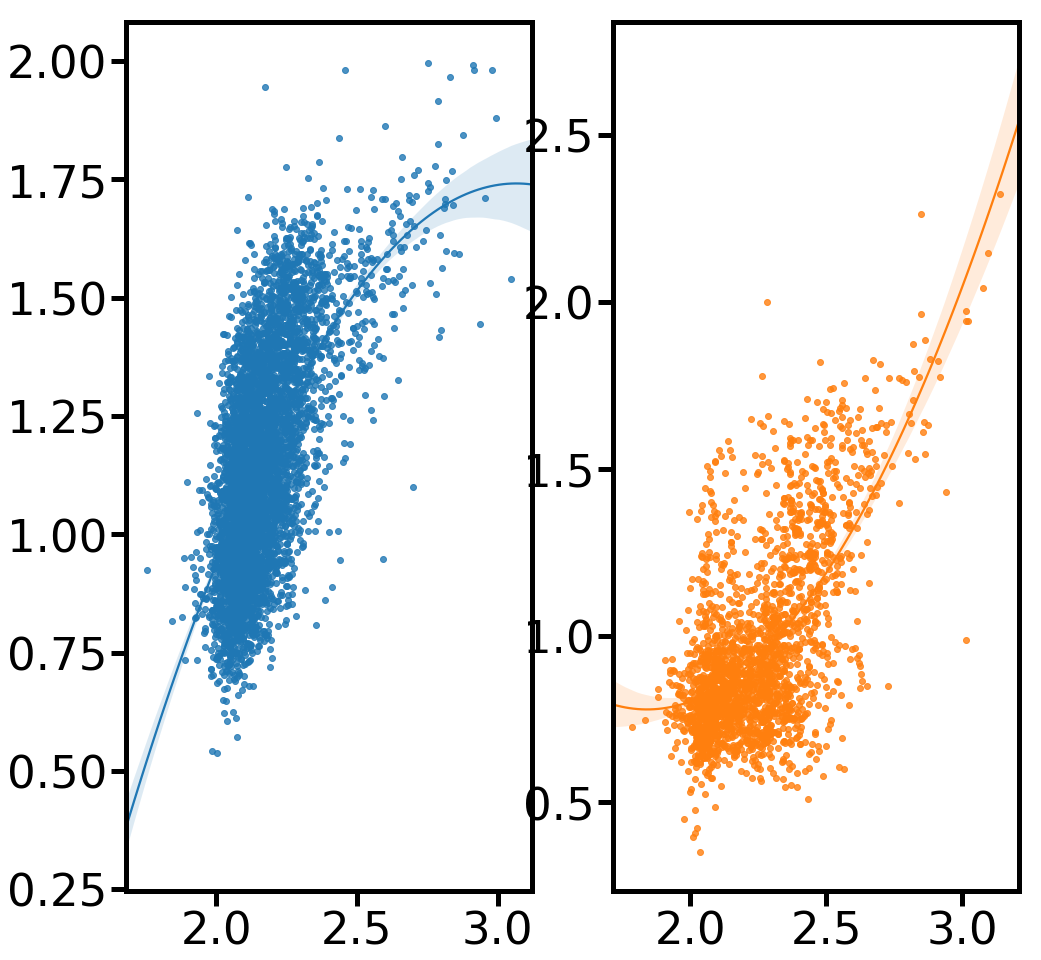

In [32]:
dfL = df.query('P_Late_comp>0.5')
dfE = df.query('P_Late_comp<0.5')
fig, ax = plt.subplots(1,2)
sns.regplot(dfL['R200Parent'].values, dfL['rhalf_ellip'].values, ax= ax[0],order=2 )
sns.regplot(dfE['R200Parent'].values, dfE['rhalf_ellip'].values, ax= ax[1],order=2 )

In [59]:
np.sqrt(0.2**2-0.1**2)

0.17320508075688776